In [1]:
import matplotlib
import sys
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.font_manager as fm
import gseapy as gp

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn import metrics

from cmapPy.pandasGEXpress.parse import parse
from scipy import stats
from pandas import DataFrame as df
from matplotlib import pyplot as plt
from matplotlib.ft2font import FT2Font
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def get_font(*args, **kwargs):
    return FT2Font(*args, **kwargs)

fm.get_font = get_font

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Global Path

In [2]:
data_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/data/'
gsea_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/GSEA/'

In [3]:
poseidon_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/'

In [40]:
panel_home = poseidon_home + 'panels/Figure3_new/'

# Data

In [4]:
# L1000 gene info
bing_landmark = pd.read_csv(data_home + 'CMAP2020_Cancer/landmark_and_bings_L1000.csv',
                            header=0, index_col=0, sep=',', dtype={'Official NCBI gene symbol': 'str'}, converters={'Official NCBI gene symbol': None})
bing_landmark

Official NCBI gene symbol
Official NCBI gene id                          
5720                                      PSME1
7416                                      VDAC1
55847                                     CISD1
10174                                    SORBS3
25803                                     SPDEF
...                                         ...
5137                                      PDE1C
51233                                    DRICH1
4340                                        MOG
1656                                       DDX6
23620                                     NTSR2

[10174 rows x 1 columns]

In [57]:
sig_info = pd.read_csv(data_home + 'CMAP2020_Cancer/siginfo_beta.txt',
                            header=0, index_col='sig_id', sep='\t')

/home/dyang-server/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,3,4,28,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
skcm_sig_info = pd.read_csv(data_home + 'CMAP2020_Cancer/SKCM/skcm_2020_tash_sig_info.csv',
                            header=0, index_col=0, sep=',')

In [6]:
# shRNA perturbations that targeting these genes should be able to inhibit the expression of sig_defc_91061_up
## read original lv5 signature matrix
skcm_trt_sh_original = pd.read_csv(data_home + '/CMAP2020_Cancer/SKCM/CMAP2020_lv5_trt_sh_merged.csv',
                                   header=0, index_col=0, sep=',')
skcm_trt_sh_original.index = skcm_trt_sh_original.index.astype(int)
skcm_trt_sh_original = skcm_trt_sh_original[skcm_trt_sh_original.index.isin(bing_landmark.index)].rename(index=bing_landmark['Official NCBI gene symbol'])

In [7]:
# compound perturbations
## read original lv5 signature matrix
skcm_trt_cp_original = pd.read_csv(data_home + '/CMAP2020_Cancer/SKCM/CMAP2020_lv5_trt_cp_merged.csv',
                                   header=0, index_col=0, sep=',')
skcm_trt_cp_original.index = skcm_trt_cp_original.index.astype(int)
skcm_trt_cp_original = skcm_trt_cp_original[skcm_trt_cp_original.index.isin(bing_landmark.index)].rename(index=bing_landmark['Official NCBI gene symbol'])

In [7]:
compound_info = pd.read_csv(data_home + '/CMAP2020_Cancer/compoundinfo_beta.txt',
                            header=0, index_col=1, sep='\t')
compound_info = compound_info.groupby(level=0).first()
compound_info

pert_id  target  \
cmap_name                                       
1-EBIO                  BRD-K70586315     NaN   
1-HYDROXYANTHRAQUINONE  BRD-K62620932     NaN   
1-HYDROXYPHENAZINE      BRD-K66151076     NaN   
1-NAPHTHYLAMINE         BRD-K05741221     NaN   
1-NITRONAPHTHALENE      BRD-K72839221     NaN   
...                               ...     ...   
zolpidem                BRD-K44876623  GABRA1   
zonisamide              BRD-A28095882  SCN11A   
zopiclone               BRD-A34309505  GABRA1   
zosuquidar              BRD-K70557564   ABCB1   
zoxazolamine            BRD-K66353228     NaN   

                                                    moa  \
cmap_name                                                 
1-EBIO                                              NaN   
1-HYDROXYANTHRAQUINONE                              NaN   
1-HYDROXYPHENAZINE                                  NaN   
1-NAPHTHYLAMINE                                     NaN   
1-NITRONAPHTHALENE                                  NaN   
...                                                 ...   
zolpidem                Benzodiazepine receptor agonist   
zonisamide                       Sodium channel blocker   
zopiclone                         GABA receptor agonist   
zosuquidar                     P-glycoprotein inhibitor   
zoxazolamine                                        NaN   

                                                         canonical_smiles  \
cmap_name                                                                   
1-EBIO                                               CCn1c2ccccc2[nH]c1=O   
1-HYDROXYANTHRAQUINONE                                                NaN   
1-HYDROXYPHENAZINE                                                    NaN   
1-NAPHTHYLAMINE                                                       NaN   
1-NITRONAPHTHALENE                                                    NaN   
...                                                                   ...   
zolpidem                        CN(C)C(=O)Cc1c(nc2ccc(C)cn12)-c1ccc(C)cc1   
zonisamide                           CN1C2CCC1CC(C2)OC(c3ccccc3)c4ccccc4N   
zopiclone                CN1CCN(CC1)C(=O)OC2N(C(=O)c3nccnc23)c4ccc(Cl)cn4   
zosuquidar              O[C@@H](COc1cccc2ncccc12)CN1CCN(CC1)[C@@H]1c2c...   
zoxazolamine                                           Nc1nc2cc(Cl)ccc2o1   

                                          inchi_key compound_aliases  
cmap_name                                                             
1-EBIO                  CXUCKELNYMZTRT-UHFFFAOYSA-N              NaN  
1-HYDROXYANTHRAQUINONE                          NaN              NaN  
1-HYDROXYPHENAZINE                              NaN              NaN  
1-NAPHTHYLAMINE                                 NaN              NaN  
1-NITRONAPHTHALENE                              NaN              NaN  
...                                             ...              ...  
zolpidem                ZAFYATHCZYHLPB-UHFFFAOYSA-N              NaN  
zonisamide              KZFDKINRISJFCO-UHFFFAOYSA-N              NaN  
zopiclone               GBBSUAFBMRNDJC-UHFFFAOYSA-N              NaN  
zosuquidar              IHOVFYSQUDPMCN-DBEBIPAYSA-N              NaN  
zoxazolamine            YGCODSQDUUUKIV-UHFFFAOYSA-N              NaN  

[33627 rows x 6 columns]

In [8]:
compound_info['moa'].value_counts()

Dopamine receptor antagonist                        64
Cyclooxygenase inhibitor                            62
Adrenergic receptor antagonist                      56
Histamine receptor antagonist                       54
Serotonin receptor antagonist                       50
                                                    ..
Cardiac myosin activator                             1
Protein tyrosine kinase activator                    1
Histamine N-methyltransferase inhibitor              1
GABA aminotransferase activator                      1
Glutamate receptor negative allosteric modulator     1
Name: moa, Length: 581, dtype: int64

# Rank list creation

In [7]:
def pre_rank_initialize(path, matrix):
    # make pre-rank folders
    if path not in os.listdir(gsea_home + '/SKCM/'):
        os.mkdir(gsea_home + '/SKCM/' + path)

    for p in matrix.columns:
        tmp = df(matrix[p]).sort_values(by=p, ascending=False)
        p_rename = '__'.join(p.split(':'))
        tmp.to_csv(gsea_home + '/SKCM/' + path + '/' + p_rename + '.rnk', header=None, sep='\t')
    
    return

In [8]:
# shRNA
# pre_rank_initialize(path='shRNA_all', matrix=skcm_trt_cp_original)

# drug
pre_rank_initialize(path='compound_all', matrix=skcm_trt_cp_original)

# Pre-rank Run

In [10]:
# Run by block
def pre_rank_run(block_index, block_matrix, path, cmap_name):
    prerank_nes = df(index=['NREC_profile', 'REC_profile'], columns=block_matrix.columns)
    prerank_fdr = df(index=['NREC_profile', 'REC_profile'], columns=block_matrix.columns)
    prerank_es = df(index=['NREC_profile', 'REC_profile'], columns=block_matrix.columns)

    for p in block_matrix.columns:
        p_rename = '__'.join(p.split(':'))
        rnk = pd.read_csv(gsea_home + '/SKCM/' + path + '/' + p_rename + '.rnk', header=None, sep="\t")
        pre_res = gp.prerank(rnk=rnk, gene_sets=gsea_home + '/gene_sets/NREC_REC_91061.gmt',
                             processes=1,
                             permutation_num=1000, # reduce number to speed up testing
                             outdir=None, format='png', seed=0, min_size=0, max_size=10000)
        prerank_nes[p] = pre_res.res2d['nes']
        prerank_fdr[p] = pre_res.res2d['fdr']
        prerank_es[p] = pre_res.res2d['es']
    
    prerank_fdr = prerank_fdr.T
    prerank_es = prerank_es.T
    prerank_nes = prerank_nes.T
    
    prerank_fdr['cmap_name'] = cmap_name['cmap_name']
    prerank_fdr = prerank_fdr.sort_values(by='NREC_profile', ascending=True)

    prerank_es['cmap_name'] = cmap_name['cmap_name']
    prerank_es = prerank_es.sort_values(by='NREC_profile', ascending=True)

    prerank_nes['cmap_name'] = cmap_name['cmap_name']
    prerank_nes = prerank_nes.sort_values(by='NREC_profile', ascending=True)

    prerank_es.to_csv(gsea_home + 'SKCM_v2/' + path + '_results/block_' + str(block_index) + '_es_sorted_by_NREC.csv', sep=',')
    prerank_nes.to_csv(gsea_home + 'SKCM_v2/' + path + '_results/block_' + str(block_index) + '_nes_sorted_by_NREC.csv', sep=',')
    prerank_fdr.to_csv(gsea_home + 'SKCM_v2/' + path + '_results/block_' + str(block_index) + '_fdr_sorted_by_NREC.csv', sep=',')
    
    print('block ' + str(block_index) + ' finished...')
    return

## Run on compounds

In [11]:
# create the blocks
block_compounds = {}
i = 0
while i <= skcm_trt_cp_original.shape[1]:
    block_compounds[i] = skcm_trt_cp_original.columns[i : i + 500]
    i += 500
print(block_compounds.keys())

dict_keys([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500])


In [13]:
# run on the first block
pre_rank_run(block_index=0,
             block_matrix=skcm_trt_cp_original[block_compounds[0]],
             path='compound_all',
             cmap_name=skcm_sig_info)

block 0 finished...


In [14]:
# run on the second block
pre_rank_run(block_index=500,
             block_matrix=skcm_trt_cp_original[block_compounds[500]],
             path='compound_all',
             cmap_name=skcm_sig_info)

block 500 finished...


In [15]:
# run on the third block
pre_rank_run(block_index=1000,
             block_matrix=skcm_trt_cp_original[block_compounds[1000]],
             path='compound_all',
             cmap_name=skcm_sig_info)

block 1000 finished...


In [16]:
# run on the 4-th block
pre_rank_run(block_index=1500,
             block_matrix=skcm_trt_cp_original[block_compounds[1500]],
             path='compound_all',
             cmap_name=skcm_sig_info)

block 1500 finished...


In [17]:
# run on the 5-th block
pre_rank_run(block_index=2000,
             block_matrix=skcm_trt_cp_original[block_compounds[2000]],
             path='compound_all',
             cmap_name=skcm_sig_info)

block 2000 finished...


In [18]:
# run on the 6-th block
pre_rank_run(block_index=2500,
             block_matrix=skcm_trt_cp_original[block_compounds[2500]],
             path='compound_all',
             cmap_name=skcm_sig_info)

block 2500 finished...


In [19]:
# run on the 7-th block
pre_rank_run(block_index=3000,
             block_matrix=skcm_trt_cp_original[block_compounds[3000]],
             path='compound_all',
             cmap_name=skcm_sig_info)

block 3000 finished...


In [20]:
# run on the 8-th block
pre_rank_run(block_index=3500,
             block_matrix=skcm_trt_cp_original[block_compounds[3500]],
             path='compound_all',
             cmap_name=skcm_sig_info)

block 3500 finished...


In [21]:
# run on the 9-th block
pre_rank_run(block_index=4000,
             block_matrix=skcm_trt_cp_original[block_compounds[4000]],
             path='compound_all',
             cmap_name=skcm_sig_info)

block 4000 finished...


In [22]:
# run on the 10-th block
pre_rank_run(block_index=4500,
             block_matrix=skcm_trt_cp_original[block_compounds[4500]],
             path='compound_all',
             cmap_name=skcm_sig_info)

block 4500 finished...


# merge results

In [9]:
def pre_rank_merge(metric, path):
    tmp_collect = os.listdir(path)
    tmp_metric_collect = [i for i in tmp_collect if i.split('_')[2] == metric]
    tmp_results = []
    for p in tmp_metric_collect:
        tmp_r = pd.read_csv(path + '/' + p, header=0, index_col=0, sep=',')
        tmp_results.append(tmp_r)
    merged_results = pd.concat(tmp_results, axis=0)
    return merged_results

In [45]:
lung_es_compound = pd.read_csv(poseidon_home + 'shift_ability/LUNG_trt_cp.csv', header=0, index_col=0, sep=',')

In [46]:
lung_es_compound

NREC_profile  REC_profile  \
ASG003_A549_24H:K19                               -0.441402     0.598110   
DPK.CP001_A549_24H:BRD-A12230535:10               -0.514089     0.485168   
HOG002_A549_24H:BRD-A68009927-003-02-9:0.3704     -0.440266     0.535068   
REP.A018_A549_24H:J19                             -0.482491     0.484630   
ASG003_A549_24H:L16                               -0.477315     0.488966   
...                                                     ...          ...   
LJP006_A549_24H:D16                                0.347475    -0.449248   
LJP008_A549_24H:G19                                0.323963    -0.488504   
PBIOA020_A549_24H:M13                              0.406209    -0.418493   
PBIOA022_A549_24H:N07                              0.347140    -0.494842   
REP.A016_A549_24H:L14                              0.368485    -0.473852   

                                                   cmap_name  nearest_dose  \
ASG003_A549_24H:K19                            BRD-K63750851         10.00   
DPK.CP001_A549_24H:BRD-A12230535:10                 nutlin-3         10.00   
HOG002_A549_24H:BRD-A68009927-003-02-9:0.3704   daunorubicin          0.37   
REP.A018_A549_24H:J19                                AMG-232         10.00   
ASG003_A549_24H:L16                                 nutlin-3         10.00   
...                                                      ...           ...   
LJP006_A549_24H:D16                                  BI-2536          0.37   
LJP008_A549_24H:G19                              azacitidine         10.00   
PBIOA020_A549_24H:M13                          BRD-K81491172         10.00   
PBIOA022_A549_24H:N07                             CHIR-99021         10.00   
REP.A016_A549_24H:L14                            azacitidine          3.33   

                                              pert_idose  shift_ability  
ASG003_A549_24H:K19                                10 uM       1.039512  
DPK.CP001_A549_24H:BRD-A12230535:10                10 uM       0.999257  
HOG002_A549_24H:BRD-A68009927-003-02-9:0.3704    0.37 uM       0.975334  
REP.A018_A549_24H:J19                              10 uM       0.967121  
ASG003_A549_24H:L16                                10 uM       0.966280  
...                                                  ...            ...  
LJP006_A549_24H:D16                              0.37 uM      -0.796723  
LJP008_A549_24H:G19                                10 uM      -0.812467  
PBIOA020_A549_24H:M13                              10 uM      -0.824701  
PBIOA022_A549_24H:N07                              10 uM      -0.841982  
REP.A016_A549_24H:L14                            3.33 uM      -0.842337  

[6901 rows x 6 columns]

In [10]:
# merge es for compounds
merged_es_compound = pre_rank_merge(metric='es', path=gsea_home + 'SKCM_v2/compound_all_results')

In [11]:
merged_es_compound

NREC_profile  REC_profile    cmap_name
PBIOA014_A375_24H:J20     -0.488382     0.426900   PD-0325901
PBIOA014_A375_24H:J19     -0.488156     0.433945   PD-0325901
PBIOA014_A375_24H:J23     -0.487444     0.399520   PD-0325901
PBIOA014_A375_24H:J24     -0.487263     0.434500   PD-0325901
PBIOA015_A375_24H:M01     -0.485613     0.380741  vemurafenib
...                             ...          ...          ...
REP.A004_A375_24H:I20      0.285440    -0.291495      CYT-997
REP.A003_A375_24H:H13      0.289184    -0.255160   tivantinib
REP.A009_A375_24H:F19      0.300381    -0.251986      KX-2391
REP.A004_A375_24H:I22      0.317422    -0.268329      CYT-997
REP.A004_A375_24H:I21      0.324637    -0.393004      CYT-997

[4917 rows x 3 columns]

In [12]:
# merge fdr for compounds
merged_fdr_compound = pre_rank_merge(metric='fdr', path=gsea_home + 'SKCM_v2/compound_all_results')

In [13]:
merged_fdr_compound

NREC_profile  REC_profile       cmap_name
REP.B008_A375_24H:O13      0.000000     0.335020           SN-38
REP.B021_A375_24H:J07      0.000000     0.211364    JNJ-26481585
REP.B021_A375_24H:G15      0.000000     0.027434      bortezomib
REP.B021_A375_24H:E16      0.000000     0.000000         MEK-162
REP.B021_A375_24H:E15      0.000000     0.000000         MEK-162
...                             ...          ...             ...
MOAR003_A375_24H:P05       0.862702     0.064677  demeclocycline
LJP006_A375_24H:I23        0.888650     0.730496        A-443654
LJP005_A375_24H:I19        0.904913     0.018692         torin-2
MOAR003_A375_24H:I16       1.000000     0.978130      crenolanib
LJP006_A375_24H:D16        1.000000     0.939733         BI-2536

[4917 rows x 3 columns]

# Visualization

## Compounds

In [18]:
merged_es_compound = merged_es_compound.sort_values(by='NREC_profile', ascending=True)
merged_fdr_compound = merged_fdr_compound.sort_values(by='NREC_profile', ascending=True)

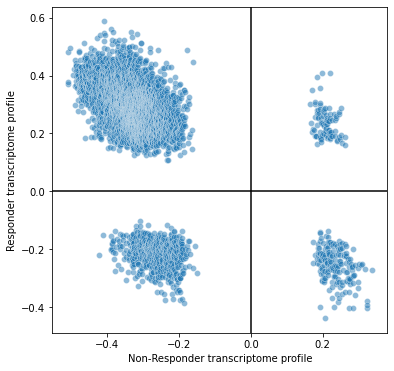

In [15]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='NREC_profile',
                y='REC_profile',
                data=merged_es_compound,
                alpha=0.5)
plt.xlabel('Non-Responder transcriptome profile')
plt.ylabel('Responder transcriptome profile')
plt.axvline(x=0., c='k')
plt.axhline(y=0., c='k')

In [16]:
merged_es_compound.describe()

NREC_profile  REC_profile
count   4917.000000  4917.000000
mean      -0.291638     0.211543
std        0.141599     0.206683
min       -0.510429    -0.437854
25%       -0.360690     0.199108
50%       -0.316565     0.271048
75%       -0.268667     0.336929
max        0.337543     0.586724

In [14]:
merged_es_compound['shift_ability'] = merged_es_compound['REC_profile'] - merged_es_compound['NREC_profile']

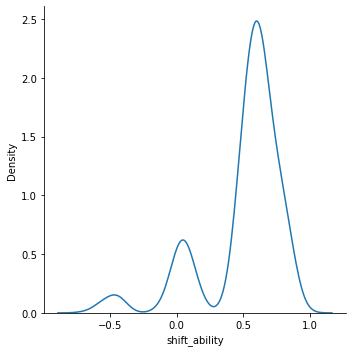

In [15]:
# distribution
sns.displot(x='shift_ability', data=merged_es_compound, kind='kde')

In [47]:
cand_compound = lung_es_compound[lung_es_compound['shift_ability'] >= 0.3]

In [48]:
cand_compound = cand_compound.sort_values(by='shift_ability', ascending=True)

In [58]:
cand_compound = cand_compound[cand_compound.index.isin(sig_info[sig_info['cell_iname'] == 'A549'].index)]

In [59]:
cand_compound

NREC_profile  REC_profile  \
DOSVAL006_A549_24H:BRD-K61606206:20               -0.161587     0.138864   
PCL001_A549_24H:BRD-K75295174:10                  -0.167271     0.136991   
CRCGN007_A549_24H:BRD-K34338046:0.246914          -0.172420     0.142440   
PBIOA015_A549_24H:F15                             -0.179109     0.148416   
CPC016_A549_6H:BRD-K85242180-001-01-1:10          -0.198202     0.134180   
...                                                     ...          ...   
ASG003_A549_24H:L16                               -0.477315     0.488966   
REP.A018_A549_24H:J19                             -0.482491     0.484630   
HOG002_A549_24H:BRD-A68009927-003-02-9:0.3704     -0.440266     0.535068   
DPK.CP001_A549_24H:BRD-A12230535:10               -0.514089     0.485168   
ASG003_A549_24H:K19                               -0.441402     0.598110   

                                                   cmap_name  nearest_dose  \
DOSVAL006_A549_24H:BRD-K61606206:20            BRD-K61606206         20.00   
PCL001_A549_24H:BRD-K75295174:10                   alisertib         10.00   
CRCGN007_A549_24H:BRD-K34338046:0.246914       BRD-K34338046          0.25   
PBIOA015_A549_24H:F15                          BRD-K15801082          1.11   
CPC016_A549_6H:BRD-K85242180-001-01-1:10            beta-CCP         10.00   
...                                                      ...           ...   
ASG003_A549_24H:L16                                 nutlin-3         10.00   
REP.A018_A549_24H:J19                                AMG-232         10.00   
HOG002_A549_24H:BRD-A68009927-003-02-9:0.3704   daunorubicin          0.37   
DPK.CP001_A549_24H:BRD-A12230535:10                 nutlin-3         10.00   
ASG003_A549_24H:K19                            BRD-K63750851         10.00   

                                              pert_idose  shift_ability  \
DOSVAL006_A549_24H:BRD-K61606206:20                20 uM       0.300451   
PCL001_A549_24H:BRD-K75295174:10                   10 uM       0.304262   
CRCGN007_A549_24H:BRD-K34338046:0.246914         0.25 uM       0.314860   
PBIOA015_A549_24H:F15                            1.11 uM       0.327525   
CPC016_A549_6H:BRD-K85242180-001-01-1:10           10 uM       0.332383   
...                                                  ...            ...   
ASG003_A549_24H:L16                                10 uM       0.966280   
REP.A018_A549_24H:J19                              10 uM       0.967121   
HOG002_A549_24H:BRD-A68009927-003-02-9:0.3704    0.37 uM       0.975334   
DPK.CP001_A549_24H:BRD-A12230535:10                10 uM       0.999257   
ASG003_A549_24H:K19                                10 uM       1.039512   

                                                                   MOA  
DOSVAL006_A549_24H:BRD-K61606206:20                                NaN  
PCL001_A549_24H:BRD-K75295174:10               Aurora kinase inhibitor  
CRCGN007_A549_24H:BRD-K34338046:0.246914                           NaN  
PBIOA015_A549_24H:F15                                              NaN  
CPC016_A549_6H:BRD-K85242180-001-01-1:10                           NaN  
...                                                                ...  
ASG003_A549_24H:L16                                      MDM inhibitor  
REP.A018_A549_24H:J19                                    MDM inhibitor  
HOG002_A549_24H:BRD-A68009927-003-02-9:0.3704  RNA synthesis inhibitor  
DPK.CP001_A549_24H:BRD-A12230535:10                      MDM inhibitor  
ASG003_A549_24H:K19                                                NaN  

[2870 rows x 7 columns]

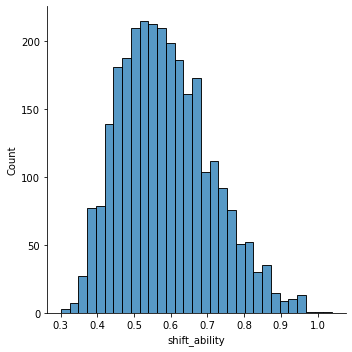

In [60]:
sns.displot(cand_compound['shift_ability'])

In [62]:
# add moa
cand_compound['MOA'] = 'Not specified'
for d in cand_compound.index:
    if cand_compound.loc[d, 'cmap_name'] in compound_info.index:
        cand_compound.at[d, 'MOA'] = compound_info.loc[cand_compound.loc[d, 'cmap_name'], 'moa']

<ipython-input-62-760273513bcb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cand_compound['MOA'] = 'Not specified'


In [63]:
cand_compound['MOA'].value_counts()[:15]

HDAC inhibitor                        286
Topoisomerase inhibitor               281
MTOR inhibitor                        139
CDK inhibitor                         116
MEK inhibitor                         107
PI3K inhibitor                         83
HSP inhibitor                          82
Proteasome inhibitor                   52
RNA synthesis inhibitor                44
IKK inhibitor                          38
KIT inhibitor                          37
EGFR inhibitor                         33
JAK inhibitor                          28
Ribonucleotide reductase inhibitor     28
ALK inhibitor                          26
Name: MOA, dtype: int64

In [64]:
top_moa = cand_compound['MOA'].value_counts()[:15].index

In [65]:
top_cand_compound = cand_compound[cand_compound['MOA'].isin(top_moa)]
top_cand_compound.shape

(1380, 7)

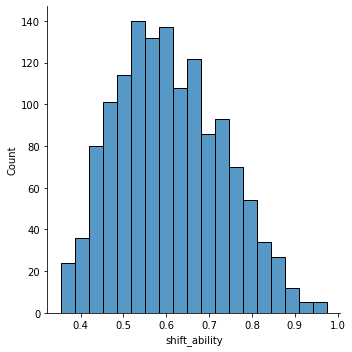

In [66]:
sns.displot(top_cand_compound['shift_ability'])

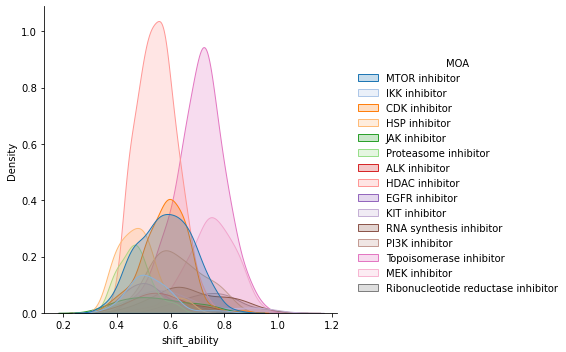

In [67]:
sns.displot(x='shift_ability',
            hue='MOA',
            data=top_cand_compound,
            fill=True,
            kind='kde',
            palette='tab20')

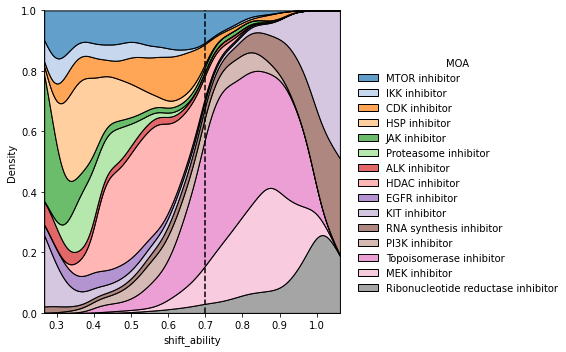

In [68]:
sns.displot(x='shift_ability',
            hue='MOA',
            data=top_cand_compound,
            multiple='fill',
            kind='kde',
            palette='tab20',
            alpha=0.7)
plt.axvline(x=.7, ls='--', c='k')
fig = plt.gcf()
fig.savefig(panel_home + 'A549_top15_moa.pdf', transparent=True)

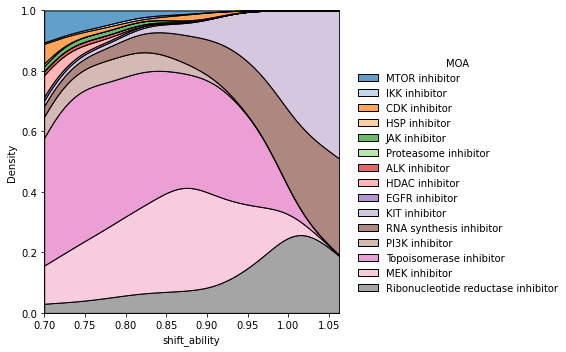

In [70]:
sns.displot(x='shift_ability',
            hue='MOA',
            data=top_cand_compound,
            multiple='fill',
            kind='kde',
            clip=(.7, None),
            palette='tab20',
            alpha=0.7)
fig = plt.gcf()
fig.savefig(panel_home + 'zoomed_A549_top15_moa.pdf', transparent=True)

In [25]:
top_cand_compound[top_cand_compound['shift_ability'] <= -.7]['cmap_name'].unique()

array(['trametinib', 'PD-0325901', 'dabrafenib', 'AS-703026', 'GDC-0879',
       'Ro-4987655', 'vemurafenib', 'PLX-4720', 'selumetinib', 'U-0126',
       'everolimus', 'AZ-628', 'TAK-733', 'refametinib', 'doxorubicin',
       'PD-184352', 'palbociclib', 'dinaciclib', 'epirubicin',
       'CEP-32496', 'vorinostat', 'TAS-103', 'mitoxantrone', 'etoposide',
       'voreloxin', 'lestaurtinib', 'BX-795', 'amonafide', 'teniposide',
       'amsacrine', 'TG-101209', 'sorafenib', 'AS-605240', 'irinotecan',
       'PHA-848125', 'SN-38', 'topotecan', 'regorafenib', 'TPCA-1',
       'midostaurin', 'BMS-387032', 'pacritinib', 'genz-644282',
       'tozasertib', 'SB-590885', 'dasatinib', 'danusertib', 'PHA-793887',
       'sirolimus', 'alvocidib', 'bortezomib', 'camptothecin', 'TGX-221',
       'MG-132', 'gefitinib', 'tanespimycin', 'PIK-75', 'NCH-51',
       'dacinostat', 'BI-2536', 'romidepsin', 'wortmannin', 'PCI-24781',
       'alisertib', 'Merck60', 'GSK-1070916', 'CGP-60474', 'tubastatin-a',
  

In [26]:
top_cand_sig = top_cand_compound[top_cand_compound['shift_ability'] <= -.7].index

### Significant hits

In [27]:
sig_cand_compound = cand_compound[cand_compound['shift_ability'] <= -.7]

In [28]:
sig_cand_compound['MOA'].value_counts()[:20]

MEK inhibitor                         126
Topoisomerase inhibitor               121
RAF inhibitor                          78
HDAC inhibitor                         71
CDK inhibitor                          55
KIT inhibitor                          16
JAK inhibitor                          16
RNA synthesis inhibitor                15
PI3K inhibitor                         14
Ribonucleotide reductase inhibitor     13
MTOR inhibitor                         12
Dihydrofolate reductase inhibitor      11
Proteasome inhibitor                   10
IMPDH inhibitor                        10
CHK inhibitor                           9
FLT3 inhibitor                          8
MDM inhibitor                           7
ALK inhibitor                           7
PLK inhibitor                           6
DNA inhibitor                           6
Name: MOA, dtype: int64

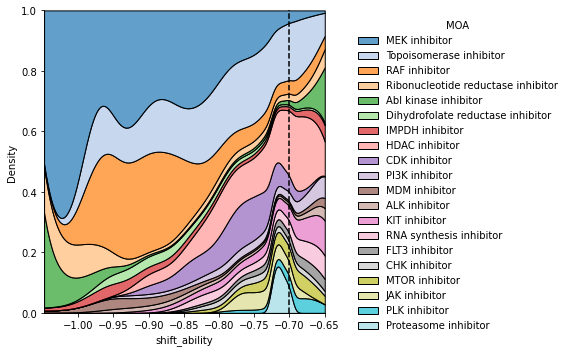

In [36]:
sns.displot(x='shift_ability',
            hue='MOA',
            data=sig_cand_compound[sig_cand_compound['MOA'].isin(sig_cand_compound['MOA'].value_counts()[:20].index)],
            multiple='fill',
            kind='kde',
            palette='tab20',
            alpha=0.7)
plt.axvline(x=-.7, ls='--', c='k')
plt.show()

In [37]:
sig_cand_compound.describe()

NREC_profile  REC_profile  shift_ability
count   1079.000000  1079.000000    1079.000000
mean      -0.396553     0.389482      -0.786035
std        0.048063     0.049949       0.060739
min       -0.510429     0.272373      -0.998331
25%       -0.433903     0.355158      -0.827320
50%       -0.394997     0.386705      -0.776325
75%       -0.361605     0.421183      -0.737258
max       -0.259819     0.586724      -0.700118

In [29]:
sig_cand_lv5 = skcm_trt_cp_original[top_cand_sig]

In [30]:
sig_cand_lv5

PBIOA018_A375_24H:A23  REP.A019_A375_24H:M23  PBIOA018_A375_24H:A24  \
rid                                                                            
ADA                   0.230806               1.516174              -0.031784   
CDH2                 -1.105715               0.671625              -0.559653   
AKT3                 -0.691025              -0.886327              -1.467091   
MED6                 -2.288394              -0.293443              -1.594695   
NAALAD2               2.452553               0.089581               1.930852   
...                        ...                    ...                    ...   
CDH1                 -0.702978               0.284755               0.067558   
SLC12A6               3.149958               2.896537               1.582896   
PTBP3                -0.373771              -2.930703              -2.040849   
DGCR2                 0.942952               2.480220               0.787879   
SCO2                  0.521024               1.358981               0.801816   

         BRAF001_A375_24H:BRD-K09951645-001-02-7:10  REP.A019_A375_24H:M20  \
rid                                                                          
ADA                                        0.689183               1.035144   
CDH2                                      -1.054533               0.446946   
AKT3                                      -1.385252              -0.650083   
MED6                                      -1.042514               0.193608   
NAALAD2                                    0.990989               0.863530   
...                                             ...                    ...   
CDH1                                       1.988259               0.805418   
SLC12A6                                    1.961031               1.035466   
PTBP3                                     -1.638786              -2.281637   
DGCR2                                      0.695442               1.765785   
SCO2                                       0.448757               1.195812   

         REP.A005_A375_24H:I19  REP.A008_A375_24H:P04  PBIOA014_A375_24H:J20  \
rid                                                                            
ADA                   0.875242               1.563784               0.064484   
CDH2                 -0.170390               0.546140              -0.571695   
AKT3                 -1.616389              -0.641648              -0.000421   
MED6                  0.247992              -0.312099              -0.969825   
NAALAD2              -0.470661               0.739019               2.280201   
...                        ...                    ...                    ...   
CDH1                  0.020150               0.414347              -0.759277   
SLC12A6               1.699181               1.698368               2.693536   
PTBP3                -0.809624              -1.697617              -1.876618   
DGCR2                 2.281124               2.803721               2.017440   
SCO2                  1.407414               1.584623               0.841309   

         BRAF001_A375_24H:BRD-K09951645-001-02-7:2.5  PBIOA014_A375_24H:J19  \
rid                                                                           
ADA                                         0.619358               0.228257   
CDH2                                       -1.094671              -1.121056   
AKT3                                       -1.214917              -0.504253   
MED6                                       -0.835034              -1.426076   
NAALAD2                                     1.408326               1.859659   
...                                              ...                    ...   
CDH1                                        0.921930               0.008594   
SLC12A6                                     1.720911               2.255757   
PTBP3                                      -0.404238              -0.778305   
DGCR2                                      

In [31]:
# read NREC and REC gene profiles
with open(gsea_home + '/gene_sets/NREC_REC_91061.gmt', 'r') as f:
    gene_NREC = f.readline().rstrip().split('\t')[2:]
    gene_REC = f.readline().rstrip().split('\t')[2:]

In [32]:
merged_profile = df(index=gene_NREC + gene_REC, columns=['profile', 'color'])
merged_profile.at[gene_NREC, 'profile'] = 'NREC'
merged_profile.at[gene_NREC, 'color'] = 'crimson'
merged_profile.at[gene_REC, 'profile'] = 'REC'
merged_profile.at[gene_REC, 'color'] = 'royalblue'

In [33]:
sig_cand_lv5_in_profile = sig_cand_lv5.loc[merged_profile.index, :]

In [34]:
sig_cand_lv5_in_profile.shape

(1329, 542)

C:\Users\ywang\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


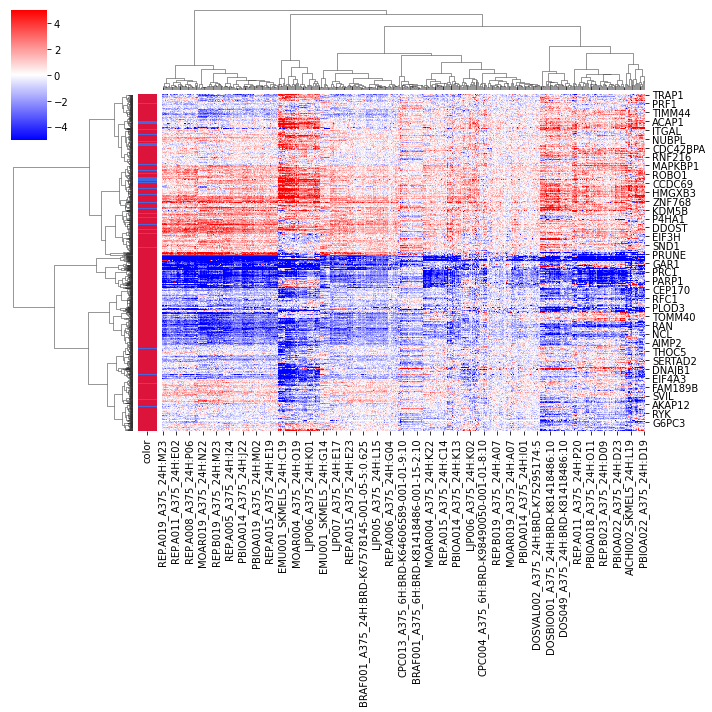

In [43]:
sns.clustermap(sig_cand_lv5_in_profile,
               method='ward',
               row_colors=merged_profile['color'],
               # row_cluster=False,
               vmin=-5, vmax=5,
               cmap='bwr')

In [35]:
compound_info

pert_id  target  \
cmap_name                                       
1-EBIO                  BRD-K70586315     NaN   
1-HYDROXYANTHRAQUINONE  BRD-K62620932     NaN   
1-HYDROXYPHENAZINE      BRD-K66151076     NaN   
1-NAPHTHYLAMINE         BRD-K05741221     NaN   
1-NITRONAPHTHALENE      BRD-K72839221     NaN   
...                               ...     ...   
zolpidem                BRD-K44876623  GABRA1   
zonisamide              BRD-A28095882  SCN11A   
zopiclone               BRD-A34309505  GABRA1   
zosuquidar              BRD-K70557564   ABCB1   
zoxazolamine            BRD-K66353228     NaN   

                                                    moa  \
cmap_name                                                 
1-EBIO                                              NaN   
1-HYDROXYANTHRAQUINONE                              NaN   
1-HYDROXYPHENAZINE                                  NaN   
1-NAPHTHYLAMINE                                     NaN   
1-NITRONAPHTHALENE                                  NaN   
...                                                 ...   
zolpidem                Benzodiazepine receptor agonist   
zonisamide                       Sodium channel blocker   
zopiclone                         GABA receptor agonist   
zosuquidar                     P-glycoprotein inhibitor   
zoxazolamine                                        NaN   

                                                         canonical_smiles  \
cmap_name                                                                   
1-EBIO                                               CCn1c2ccccc2[nH]c1=O   
1-HYDROXYANTHRAQUINONE                                                NaN   
1-HYDROXYPHENAZINE                                                    NaN   
1-NAPHTHYLAMINE                                                       NaN   
1-NITRONAPHTHALENE                                                    NaN   
...                                                                   ...   
zolpidem                        CN(C)C(=O)Cc1c(nc2ccc(C)cn12)-c1ccc(C)cc1   
zonisamide                           CN1C2CCC1CC(C2)OC(c3ccccc3)c4ccccc4N   
zopiclone                CN1CCN(CC1)C(=O)OC2N(C(=O)c3nccnc23)c4ccc(Cl)cn4   
zosuquidar              O[C@@H](COc1cccc2ncccc12)CN1CCN(CC1)[C@@H]1c2c...   
zoxazolamine                                           Nc1nc2cc(Cl)ccc2o1   

                                          inchi_key compound_aliases  
cmap_name                                                             
1-EBIO                  CXUCKELNYMZTRT-UHFFFAOYSA-N              NaN  
1-HYDROXYANTHRAQUINONE                          NaN              NaN  
1-HYDROXYPHENAZINE                              NaN              NaN  
1-NAPHTHYLAMINE                                 NaN              NaN  
1-NITRONAPHTHALENE                              NaN              NaN  
...                                             ...              ...  
zolpidem                ZAFYATHCZYHLPB-UHFFFAOYSA-N              NaN  
zonisamide              KZFDKINRISJFCO-UHFFFAOYSA-N              NaN  
zopiclone               GBBSUAFBMRNDJC-UHFFFAOYSA-N              NaN  
zosuquidar              IHOVFYSQUDPMCN-DBEBIPAYSA-N              NaN  
zoxazolamine            YGCODSQDUUUKIV-UHFFFAOYSA-N              NaN  

[33627 rows x 6 columns]

In [36]:
# add target
sig_cand_compound['target'] = 'None'
for d in sig_cand_compound.index:
    if sig_cand_compound.loc[d, 'cmap_name'] in compound_info.index:
        sig_cand_compound.at[d, 'target'] = compound_info.loc[cand_compound.loc[d, 'cmap_name'], 'target']

<ipython-input-36-3fa4f1448ca1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_cand_compound['target'] = 'None'


In [37]:
sig_cand_compound

NREC_profile  REC_profile    cmap_name  shift_ability  \
PBIOA018_A375_24H:A23     -0.510429     0.368917   trametinib      -0.879347   
REP.B021_A375_24H:E13     -0.508522     0.481902      MEK-162      -0.990424   
REP.A019_A375_24H:M23     -0.508466     0.379047   PD-0325901      -0.887513   
PBIOA018_A375_24H:A24     -0.503196     0.495135   trametinib      -0.998331   
EMU001_SKMEL5_24H:G20     -0.496531     0.400384    auranofin      -0.896915   
...                             ...          ...          ...            ...   
MOAR019_A375_24H:K23      -0.280123     0.480439  palbociclib      -0.760562   
REP.A011_A375_24H:H24     -0.279110     0.439725  rilpivirine      -0.718836   
MOAR003_A375_24H:C16      -0.276955     0.425692       CC-930      -0.702647   
CPC014_A375_6H:J02        -0.266825     0.439901     HC-toxin      -0.706727   
REP.B019_A375_24H:A07     -0.259819     0.486900    taselisib      -0.746719   

                                  MOA  target  
PBIOA018_A375_24H:A23   MEK inhibitor  MAP2K1  
REP.B021_A375_24H:E13             NaN     NaN  
REP.A019_A375_24H:M23   MEK inhibitor  MAP2K1  
PBIOA018_A375_24H:A24   MEK inhibitor  MAP2K1  
EMU001_SKMEL5_24H:G20             NaN     NaN  
...                               ...     ...  
MOAR019_A375_24H:K23    CDK inhibitor    CDK4  
REP.A011_A375_24H:H24             NaN     NaN  
MOAR003_A375_24H:C16              NaN     NaN  
CPC014_A375_6H:J02                NaN     NaN  
REP.B019_A375_24H:A07  PI3K inhibitor  PIK3CA  

[1079 rows x 6 columns]

In [69]:
len(sig_cand_compound['cmap_name'].unique())

339

<AxesSubplot:xlabel='target', ylabel='MOA'>

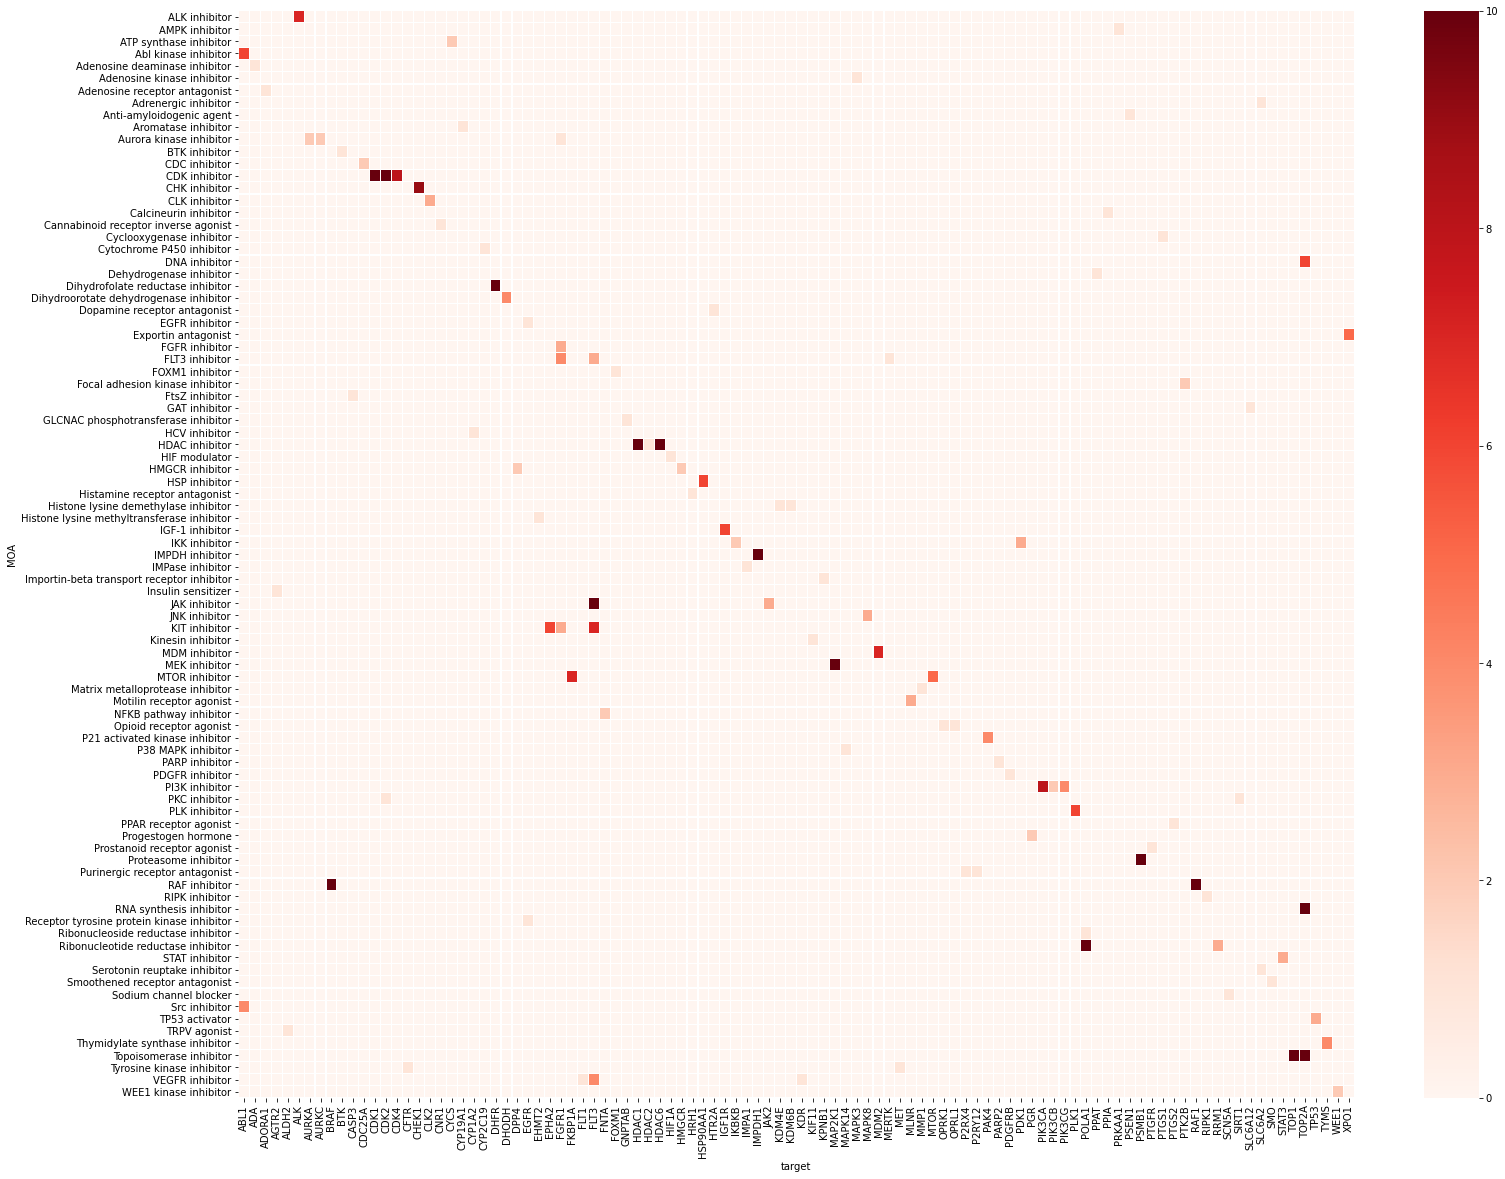

In [38]:
plt.figure(figsize=(25, 20))
sns.heatmap(pd.crosstab(sig_cand_compound['MOA'],
                           sig_cand_compound['target']),
               cmap='Reds', vmin=0, vmax=10,
               linewidths=0.1)

# shRNA results

In [39]:
prerank_shRNA_es_result = pd.read_csv(gsea_home + 'SKCM/shRNA_all_results/es_sorted_by_NREC.csv', header=0, index_col=0, sep=',')

In [40]:
prerank_shRNA_es_result['shift_ability'] = prerank_shRNA_es_result['NREC_profile'] - prerank_shRNA_es_result['REC_profile']

In [41]:
# overlap between shRNA and compound targets
op_target = list(set(prerank_shRNA_es_result['cmap_name']) & set(sig_cand_compound['target']))

In [43]:
len(set(sig_cand_compound['target']))

251

In [44]:
len(set(prerank_shRNA_es_result['cmap_name']))

1556

In [42]:
print(len(op_target))

42


In [45]:
op_shRNA = prerank_shRNA_es_result[prerank_shRNA_es_result['cmap_name'].isin(op_target)]
op_shRNA['type'] = 'shRNA'
op_compound = sig_cand_compound[sig_cand_compound['target'].isin(op_target)]
op_compound['type'] = 'compound'
merged_overlap = pd.concat([op_shRNA, op_compound], axis=0)
merged_overlap

<ipython-input-45-846cfe787ab8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  op_shRNA['type'] = 'shRNA'
<ipython-input-45-846cfe787ab8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  op_compound['type'] = 'compound'


NREC_profile  REC_profile    cmap_name  \
KDB005_A375_96H:TRCN0000004819:-666     -0.378953     0.198350        HDAC2   
KDB005_A375_96H:TRCN0000003549:-666     -0.362745    -0.224076        CASP3   
KDA002_A375_96H:TRCN0000003549:-666     -0.356643     0.227562        CASP3   
KDA002_A375_96H:E08                     -0.356240     0.206918        CASP3   
KDB004_A375_96H:TRCN0000010201:-666     -0.334421     0.243936         PAK4   
...                                           ...          ...          ...   
REP.B004_A375_24H:F17                   -0.294984     0.450269   marimastat   
PBIOA019_A375_24H:K07                   -0.294034     0.409841   wortmannin   
MOAR006_A375_24H:I17                    -0.282078     0.494521  NMS-1286937   
MOAR019_A375_24H:K23                    -0.280123     0.480439  palbociclib   
REP.B019_A375_24H:A07                   -0.259819     0.486900    taselisib   

                                     shift_ability      type  \
KDB005_A375_96H:TRCN0000004819:-666      -0.577303     shRNA   
KDB005_A375_96H:TRCN0000003549:-666      -0.138669     shRNA   
KDA002_A375_96H:TRCN0000003549:-666      -0.584205     shRNA   
KDA002_A375_96H:E08                      -0.563159     shRNA   
KDB004_A375_96H:TRCN0000010201:-666      -0.578357     shRNA   
...                                            ...       ...   
REP.B004_A375_24H:F17                    -0.745253  compound   
PBIOA019_A375_24H:K07                    -0.703876  compound   
MOAR006_A375_24H:I17                     -0.776598  compound   
MOAR019_A375_24H:K23                     -0.760562  compound   
REP.B019_A375_24H:A07                    -0.746719  compound   

                                                                  MOA  target  
KDB005_A375_96H:TRCN0000004819:-666                               NaN     NaN  
KDB005_A375_96H:TRCN0000003549:-666                               NaN     NaN  
KDA002_A375_96H:TRCN0000003549:-666                               NaN     NaN  
KDA002_A375_96H:E08                                               NaN     NaN  
KDB004_A375_96H:TRCN0000010201:-666                               NaN     NaN  
...                                                               ...     ...  
REP.B004_A375_24H:F17                Matrix metalloprotease inhibitor    MMP1  
PBIOA019_A375_24H:K07                                  PI3K inhibitor  PIK3CA  
MOAR006_A375_24H:I17                                    PLK inhibitor    PLK1  
MOAR019_A375_24H:K23                                    CDK inhibitor    CDK4  
REP.B019_A375_24H:A07                                  PI3K inhibitor  PIK3CA  

[405 rows x 7 columns]

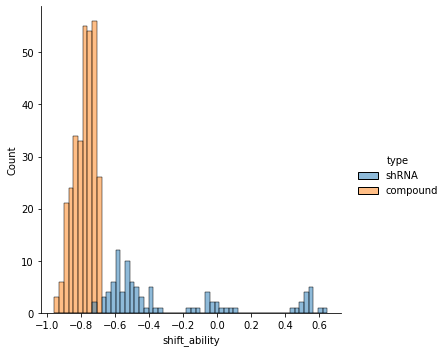

In [52]:
sns.displot(x='shift_ability', hue='type', data=merged_overlap)

In [46]:
merged_overlap_sig = merged_overlap[merged_overlap['shift_ability'] <= -0.5]

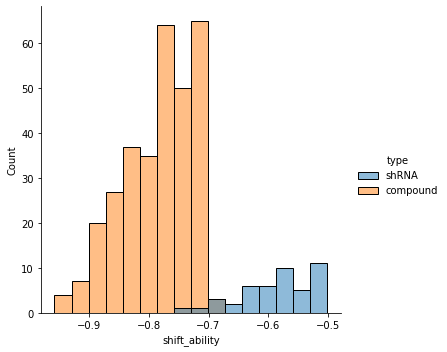

In [54]:
sns.displot(x='shift_ability', hue='type', data=merged_overlap_sig)

In [47]:
hi_confi_shRNA = list(merged_overlap_sig[merged_overlap_sig['type'] == 'shRNA']['cmap_name'].unique())
hi_confi_shRNA

['HDAC2',
 'CASP3',
 'PAK4',
 'HDAC6',
 'CDC25A',
 'RAF1',
 'IMPA1',
 'WEE1',
 'BRAF',
 'KIF11',
 'HDAC1',
 'PPAT',
 'AURKA',
 'PSMB1',
 'FKBP1A',
 'CDK4',
 'TYMS',
 'BTK',
 'PARP2',
 'ABL1',
 'PRKAA1',
 'PLK1',
 'HMGCR']

In [48]:
hi_confi_moa = list(merged_overlap_sig[merged_overlap_sig['target'].isin(hi_confi_shRNA)]['MOA'].unique())
hi_confi_moa

['RAF inhibitor',
 'P21 activated kinase inhibitor',
 'CDK inhibitor',
 'HDAC inhibitor',
 'HMGCR inhibitor',
 'Abl kinase inhibitor',
 'Thymidylate synthase inhibitor',
 'BTK inhibitor',
 'Src inhibitor',
 'FtsZ inhibitor',
 'MTOR inhibitor',
 'Dehydrogenase inhibitor',
 'Proteasome inhibitor',
 'PLK inhibitor',
 'WEE1 kinase inhibitor',
 'Aurora kinase inhibitor',
 'CDC inhibitor',
 'IMPase inhibitor',
 'PARP inhibitor',
 'AMPK inhibitor',
 'Kinesin inhibitor']

In [49]:
hi_confi_drug = list(merged_overlap_sig[merged_overlap_sig['target'].isin(hi_confi_shRNA)]['cmap_name'].unique())
hi_confi_drug

['dabrafenib',
 'PF-03758309',
 'GDC-0879',
 'vemurafenib',
 'PLX-4720',
 'AZ-628',
 'palbociclib',
 'CEP-32496',
 'vorinostat',
 'fluvastatin',
 'nilotinib',
 'trifluridine',
 'pitavastatin',
 'AVL-292',
 'bosutinib',
 'sanguinarium-chloride',
 'SB-590885',
 'raltitrexed',
 'sirolimus',
 'azathioprine',
 'bortezomib',
 'metatinib',
 'MG-132',
 'NCH-51',
 'dacinostat',
 'BI-2536',
 'MK-1775',
 'romidepsin',
 'PCI-24781',
 'alisertib',
 'Merck60',
 'NSC-663284',
 'L-690488',
 'tubastatin-a',
 'flumatinib',
 'talazoparib',
 'ixazomib',
 'scriptaid',
 'panobinostat',
 'volasertib',
 'JNJ-26481585',
 'givinostat',
 'apicidin',
 'belinostat',
 'dorsomorphin',
 'GSK-461364',
 'resminostat',
 'ISOX',
 'NMS-1286937',
 'filanesib']

In [50]:
len(hi_confi_drug)

50

In [51]:
hi_conf_sig = merged_overlap_sig[merged_overlap_sig['target'].isin(hi_confi_shRNA)]

In [52]:
hi_conf_sig

NREC_profile  REC_profile  \
BRAF001_A375_24H:BRD-K09951645-001-02-7:10      -0.491640     0.421348   
MOAR004_A375_24H:A17                            -0.489876     0.297044   
REP.A005_A375_24H:I19                           -0.489461     0.452204   
BRAF001_A375_24H:BRD-K09951645-001-02-7:2.5     -0.488362     0.441918   
PBIOA017_A375_24H:M01                           -0.487790     0.380280   
...                                                   ...          ...   
CPC012_A375_6H:B04                              -0.308416     0.487491   
PCLB002_A375_24H:BRD-K02130563:3.33             -0.303365     0.399210   
MOAR006_A375_24H:C09                            -0.298506     0.403869   
MOAR006_A375_24H:I17                            -0.282078     0.494521   
MOAR019_A375_24H:K23                            -0.280123     0.480439   

                                                cmap_name  shift_ability  \
BRAF001_A375_24H:BRD-K09951645-001-02-7:10     dabrafenib      -0.912988   
MOAR004_A375_24H:A17                          PF-03758309      -0.786920   
REP.A005_A375_24H:I19                          dabrafenib      -0.941665   
BRAF001_A375_24H:BRD-K09951645-001-02-7:2.5    dabrafenib      -0.930280   
PBIOA017_A375_24H:M01                            GDC-0879      -0.868070   
...                                                   ...            ...   
CPC012_A375_6H:B04                             vorinostat      -0.795907   
PCLB002_A375_24H:BRD-K02130563:3.33          panobinostat      -0.702575   
MOAR006_A375_24H:C09                            filanesib      -0.702375   
MOAR006_A375_24H:I17                          NMS-1286937      -0.776598   
MOAR019_A375_24H:K23                          palbociclib      -0.760562   

                                                 type  \
BRAF001_A375_24H:BRD-K09951645-001-02-7:10   compound   
MOAR004_A375_24H:A17                         compound   
REP.A005_A375_24H:I19                        compound   
BRAF001_A375_24H:BRD-K09951645-001-02-7:2.5  compound   
PBIOA017_A375_24H:M01                        compound   
...                                               ...   
CPC012_A375_6H:B04                           compound   
PCLB002_A375_24H:BRD-K02130563:3.33          compound   
MOAR006_A375_24H:C09                         compound   
MOAR006_A375_24H:I17                         compound   
MOAR019_A375_24H:K23                         compound   

                                                                        MOA  \
BRAF001_A375_24H:BRD-K09951645-001-02-7:10                    RAF inhibitor   
MOAR004_A375_24H:A17                         P21 activated kinase inhibitor   
REP.A005_A375_24H:I19                                         RAF inhibitor   
BRAF001_A375_24H:BRD-K09951645-001-02-7:2.5                   RAF inhibitor   
PBIOA017_A375_24H:M01                                         RAF inhibitor   
...                                                                     ...   
CPC012_A375_6H:B04                                           HDAC inhibitor   
PCLB002_A375_24H:BRD-K02130563:3.33                          HDAC inhibitor   
MOAR006_A375_24H:C09                                      Kinesin inhibitor   
MOAR006_A375_24H:I17                                          PLK inhibitor   
MOAR019_A375_24H:K23                                          CDK inhibitor   

                                            target  
BRAF001_A375_24H:BRD-K09951645-001-02-7:10    BRAF  
MOAR004_A375_24H:A17                          PAK4  
REP.A005_A375_24H:I19                         BRAF  
BRAF001_A375_24H:BRD-K09951645-001-02-7:2.5   BRAF  
PBIOA017_A375_24H:M01                         BRAF  
...                                            ...  
CPC012_A375_6H:B04                           HDAC6  
PCLB002_A375_24H:BRD-K02130563:3.33          HDAC1  
MOAR006_A375_24H:C09                         KIF11  
MOAR006_A375_24H:I17                          PLK1  
MOAR019_A375_24H:K23      

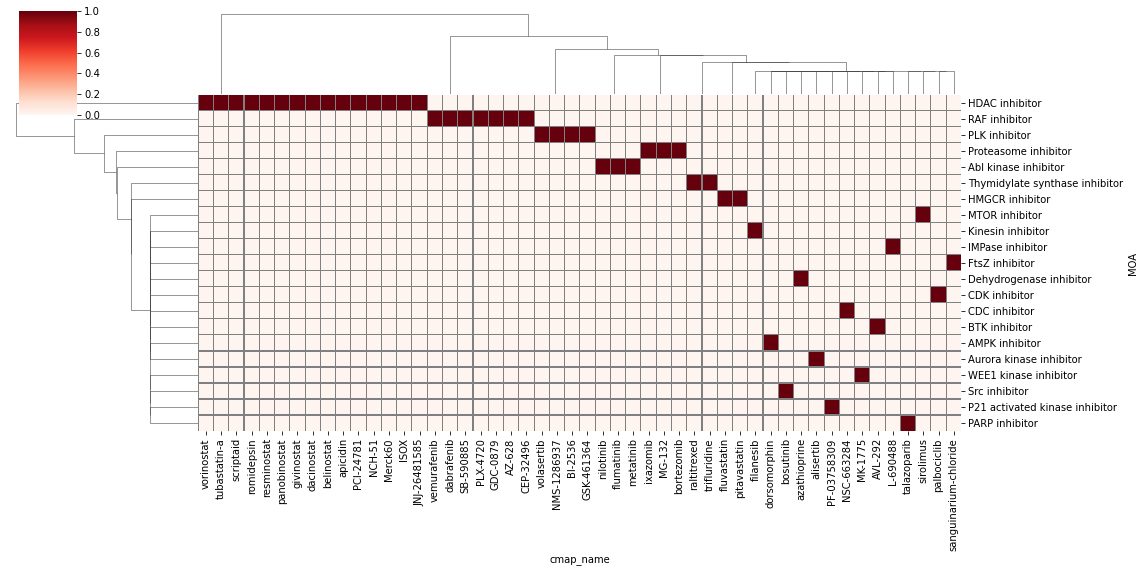

In [66]:
hi_sig_count = df(pd.crosstab(hi_conf_sig['MOA'], hi_conf_sig['cmap_name']))
hi_sig_count = hi_sig_count[hi_sig_count == 0].fillna(1)
sns.clustermap(hi_sig_count,
               figsize=(16, 8),
               linewidth=0.1,
               linecolor='grey',
               cmap='Reds', method='ward')

In [60]:
hi_conf_sig['MOA'].value_counts()

RAF inhibitor                     78
HDAC inhibitor                    71
Proteasome inhibitor              10
CDK inhibitor                      8
MTOR inhibitor                     7
PLK inhibitor                      6
Abl kinase inhibitor               6
Src inhibitor                      4
P21 activated kinase inhibitor     4
Thymidylate synthase inhibitor     4
WEE1 kinase inhibitor              2
CDC inhibitor                      2
Aurora kinase inhibitor            2
HMGCR inhibitor                    2
PARP inhibitor                     1
IMPase inhibitor                   1
FtsZ inhibitor                     1
BTK inhibitor                      1
AMPK inhibitor                     1
Dehydrogenase inhibitor            1
Kinesin inhibitor                  1
Name: MOA, dtype: int64

In [69]:
def pre_rank_selected(gene_set_name, gene_set_path, sig_matrix, save_path, cmap_name):
    prerank_nes = df(columns=sig_matrix.columns)
    prerank_fdr = df(columns=sig_matrix.columns)
    prerank_es = df(columns=sig_matrix.columns)

    for p in sig_matrix.columns:
        p_rename = '__'.join(p.split(':'))
        rnk = pd.read_csv(gsea_home + '/SKCM/compound_all/' + p_rename + '.rnk', header=None, sep="\t")
        pre_res = gp.prerank(rnk=rnk, gene_sets=gsea_home + '/gene_sets/' + gene_set_path,
                             processes=1,
                             permutation_num=1000, # reduce number to speed up testing
                             outdir=None, format='png', seed=0, min_size=0, max_size=10000)
        prerank_nes[p] = pre_res.res2d['nes']
        prerank_fdr[p] = pre_res.res2d['fdr']
        prerank_es[p] = pre_res.res2d['es']
    
    prerank_fdr = prerank_fdr.T
    prerank_es = prerank_es.T
    prerank_nes = prerank_nes.T
    
    prerank_fdr['cmap_name'] = cmap_name['cmap_name']
    prerank_es['cmap_name'] = cmap_name['cmap_name']
    prerank_nes['cmap_name'] = cmap_name['cmap_name']

    prerank_es.to_csv(gsea_home + 'SKCM_v2/' + save_path + '_results/' + gene_set_name + '_es.csv', sep=',')
    prerank_nes.to_csv(gsea_home + 'SKCM_v2/' + save_path + '_results/' + gene_set_name + '_nes.csv', sep=',')
    prerank_fdr.to_csv(gsea_home + 'SKCM_v2/' + save_path + '_results/' + gene_set_name + '_fdr.csv', sep=',')
    
    return prerank_nes, prerank_fdr, prerank_es

In [71]:
'''
immune_nes, immune_fdr, immune_es = pre_rank_selected(gene_set_name='immune',
                                                      gene_set_path='WolfEtAl_71_Symbols.gmt',
                                                      sig_matrix=skcm_trt_cp_original[hi_conf_sig.index],
                                                      save_path='high_conf',
                                                      cmap_name=skcm_sig_info)
'''

In [73]:
'''
hallmark_nes, hallmark_fdr, hallmark_es = pre_rank_selected(gene_set_name='hallmark',
                                                            gene_set_path='h.all.v7.5.1.symbols.gmt',
                                                            sig_matrix=skcm_trt_cp_original[hi_conf_sig.index],
                                                            save_path='high_conf',
                                                            cmap_name=skcm_sig_info)
'''

"\nhallmark_nes, hallmark_fdr, hallmark_es = pre_rank_selected(gene_set_name='hallmark',\n                                                            gene_set_path='h.all.v7.5.1.symbols.gmt',\n                                                            sig_matrix=skcm_trt_cp_original[hi_conf_sig.index],\n                                                            save_path='high_conf',\n                                                            cmap_name=skcm_sig_info)\n"

In [226]:
immune_nes = pd.read_csv(gsea_home + 'SKCM_v2/high_conf_results/immune_nes.csv', sep=',', header=0, index_col=0)

C:\Users\ywang\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


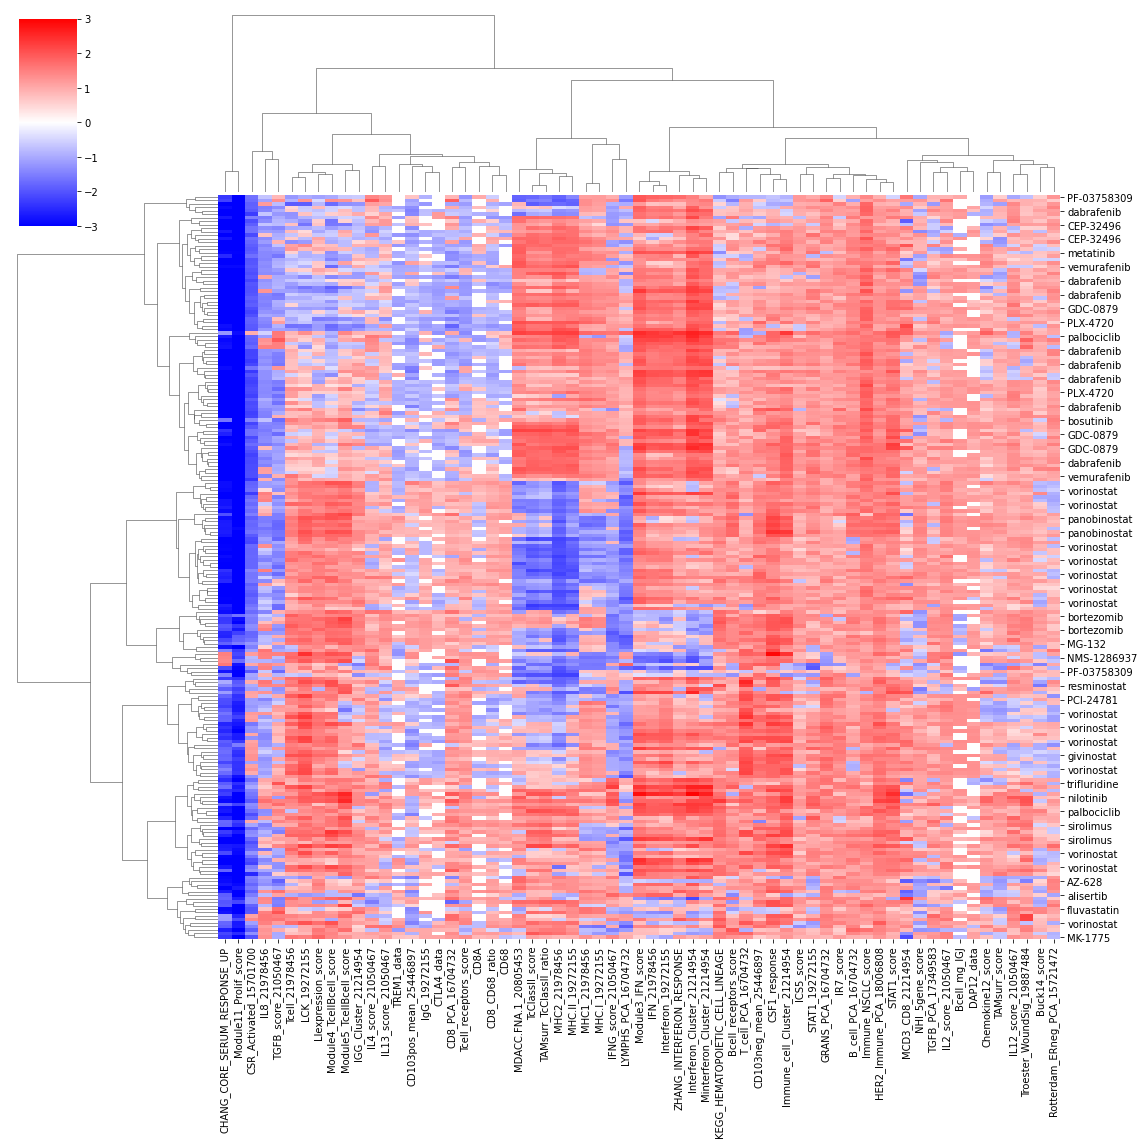

In [62]:
tmp_nes = immune_nes.T[~immune_nes.columns.isin(['cmap_name'])].T.rename(index=immune_nes['cmap_name']).dropna(axis=1, how='all').fillna(0)
sns.clustermap(tmp_nes,
               figsize=(16, 16),
               method='ward',
               vmin=-3, vmax=3, cmap='bwr')

In [64]:
df(tmp_nes.loc['azathioprine', :]).sort_values(by='azathioprine')[:20]

azathioprine
Module11_Prolif_score            -3.051743
CHANG_CORE_SERUM_RESPONSE_UP     -2.857930
CSR_Activated_15701700           -1.731556
MHC2_21978456                    -1.652069
MHC.II_19272155                  -1.491953
LYMPHS_PCA_16704732              -1.449402
IL8_21978456                     -1.442402
NHI_5gene_score                  -1.277591
MDACC.FNA.1_20805453             -1.153720
Interferon_Cluster_21214954      -1.055353
IFNG_score_21050467              -1.038108
IFN_21978456                     -0.906191
Interferon_19272155              -0.880274
Module3_IFN_score                -0.852122
Minterferon_Cluster_21214954     -0.718652
ZHANG_INTERFERON_RESPONSE        -0.506615
Bcell_mg_IGJ                      0.000000
DAP12_data                        0.000000
CD103neg_mean_25446897            0.475985
STAT1_19272155                    0.693513

In [65]:
df(tmp_nes.loc['azathioprine', :]).sort_values(by='azathioprine')[-20:]

azathioprine
CD68                                 1.243571
B_cell_PCA_16704732                  1.267684
ICS5_score                           1.284082
IGG_Cluster_21214954                 1.292732
STAT1_score                          1.314557
IL2_score_21050467                   1.315363
Chemokine12_score                    1.333356
LCK_19272155                         1.348409
HER2_Immune_PCA_18006808             1.374218
Troester_WoundSig_19887484           1.390090
LIexpression_score                   1.414330
Immune_cell_Cluster_21214954         1.510251
Bcell_receptors_score                1.583731
IL13_score_21050467                  1.588284
IL4_score_21050467                   1.643318
CD8_PCA_16704732                     1.646243
Module5_TcellBcell_score             1.753034
KEGG_HEMATOPOIETIC_CELL_LINEAGE      1.755058
MCD3_CD8_21214954                    1.796232
Module4_TcellBcell_score             1.861853

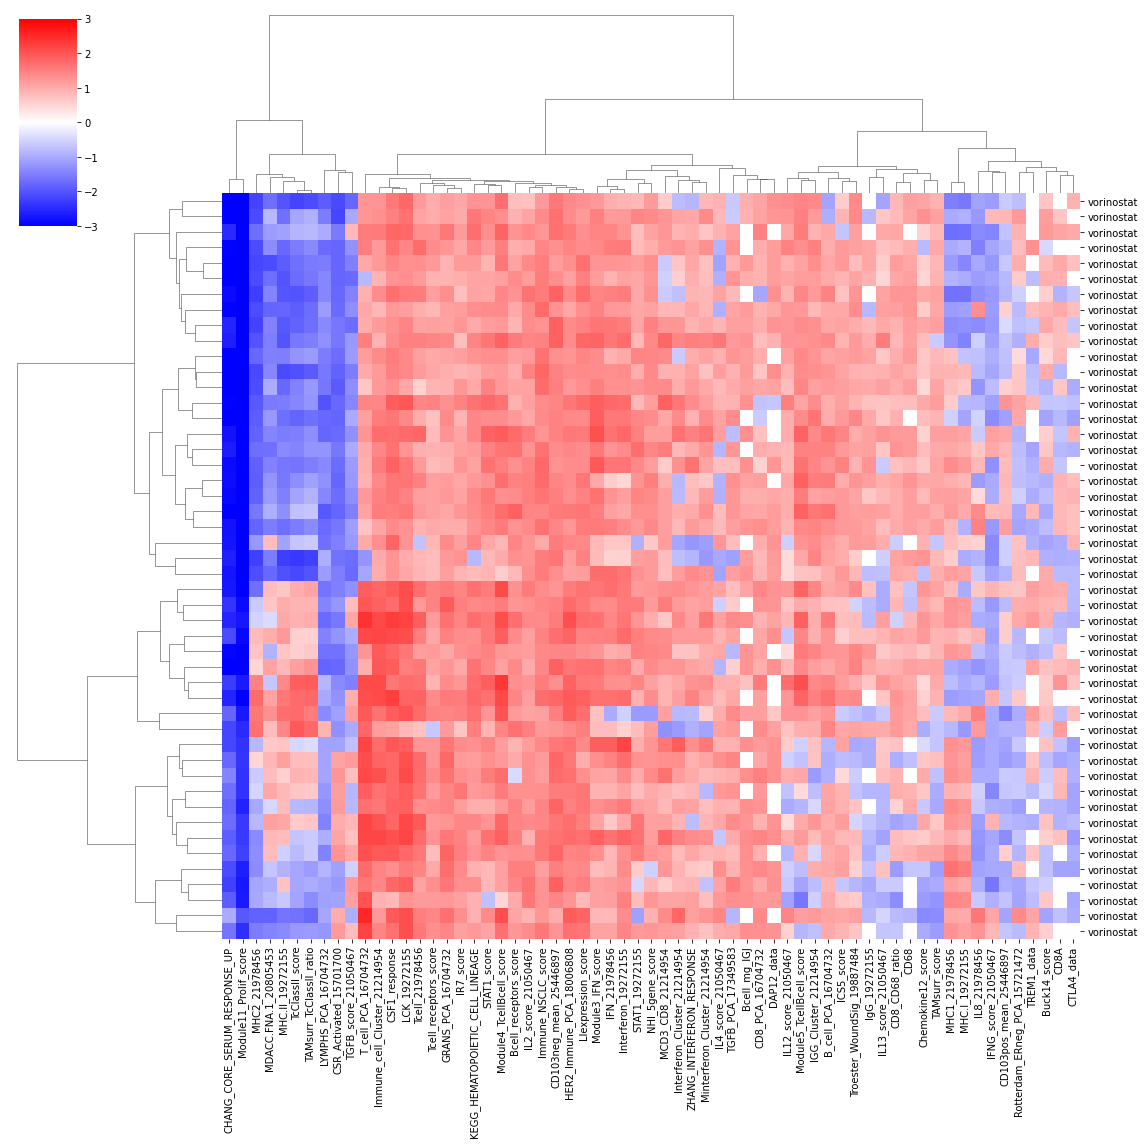

In [66]:
sns.clustermap(df(tmp_nes.loc['vorinostat', :]),
               figsize=(16, 16),
               method='ward',
               vmin=-3, vmax=3, cmap='bwr')

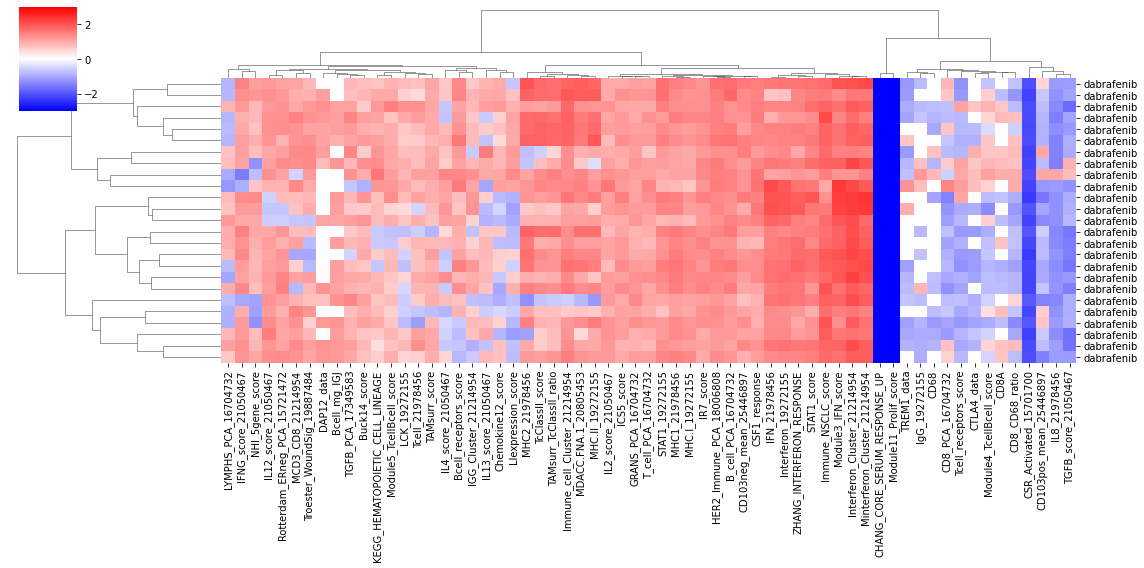

In [67]:
sns.clustermap(df(tmp_nes.loc['dabrafenib', :]),
               figsize=(16, 8),
               method='ward',
               vmin=-3, vmax=3, cmap='bwr')

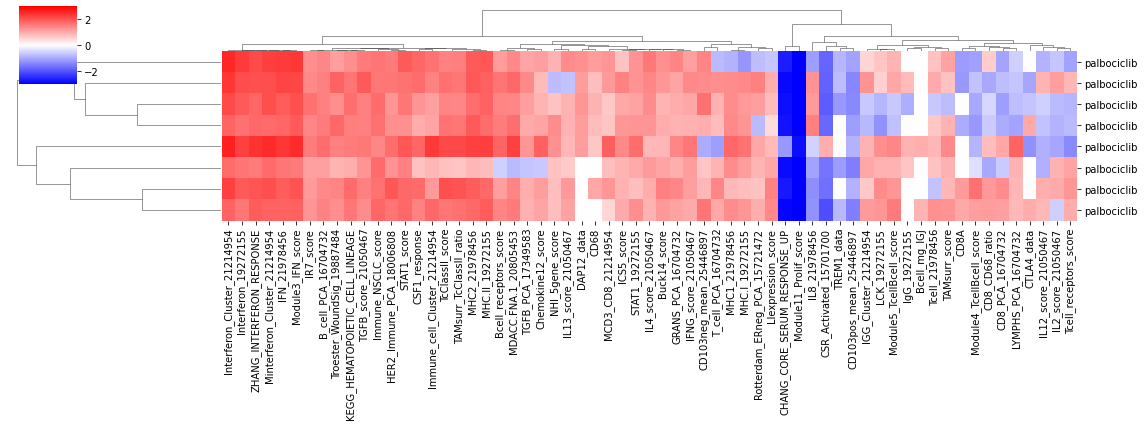

In [68]:
sns.clustermap(df(tmp_nes.loc['palbociclib', :]),
               figsize=(16, 6),
               method='ward',
               vmin=-3, vmax=3, cmap='bwr')

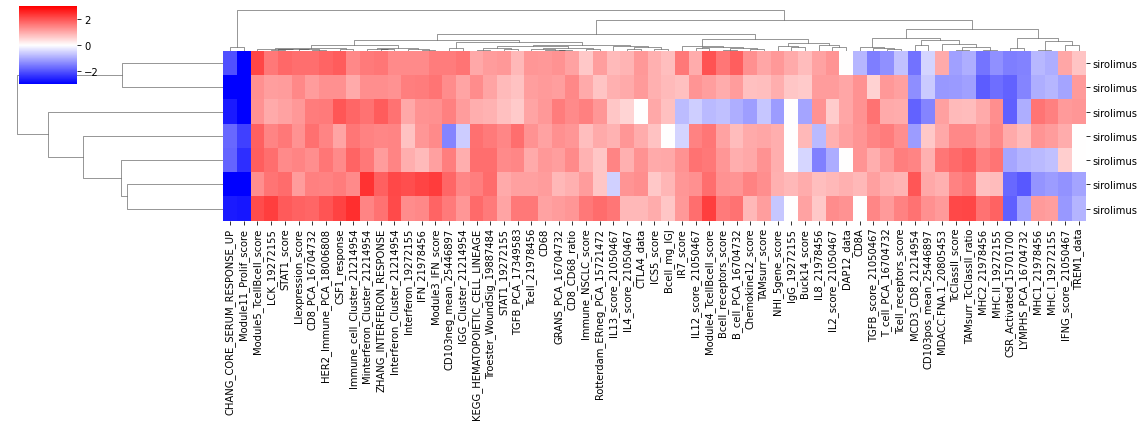

In [69]:
sns.clustermap(df(tmp_nes.loc['sirolimus', :]),
               figsize=(16, 6),
               method='ward',
               vmin=-3, vmax=3, cmap='bwr')

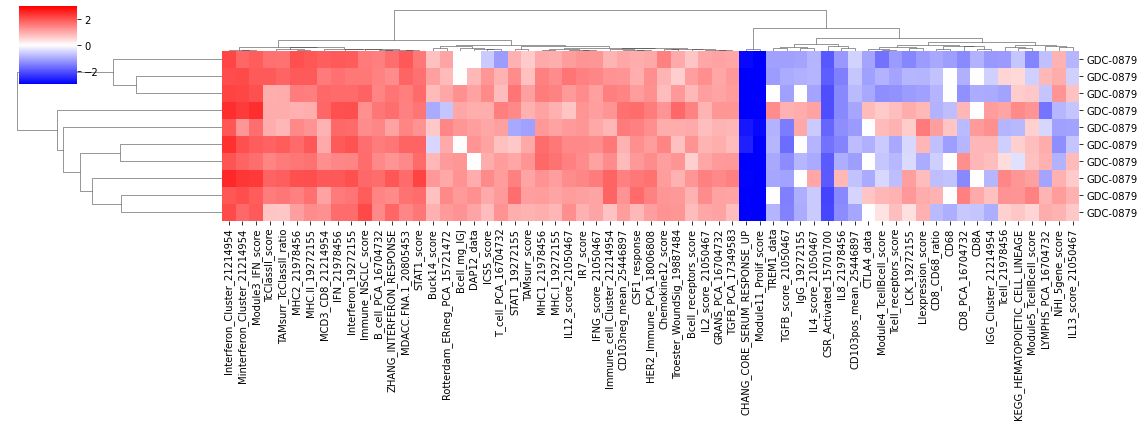

In [70]:
sns.clustermap(df(tmp_nes.loc['GDC-0879', :]),
               figsize=(16, 6),
               method='ward',
               vmin=-3, vmax=3, cmap='bwr')

In [236]:
# read pathway
immune_class = pd.read_csv(data_home + 'immuneSig/signature_class.csv', header=0, index_col=0, sep=',')
print(immune_class.head())

                                class
signatures                           
MHC1_21978456    Antigen Presentation
MHC2_21978456    Antigen Presentation
MHC.I_19272155   Antigen Presentation
MHC.II_19272155  Antigen Presentation
PD1_data                  Check Point


In [237]:
immune_pal = sns.husl_palette(len(immune_class['class'].unique()), s=.65)
immune_lut = dict(zip(map(str, immune_class['class'].unique()), immune_pal))
immune_class['color'] = immune_class['class'].map(immune_lut)

In [65]:
def nes_by_class(sub_name, nes_sub, immuneSig_class, immune_lut):
    if nes_sub.shape[1] > 1:
        tmp_ave = df(nes_sub.mean(axis=0)).rename(columns={0: 'average_NES'})
    else:
        tmp_ave = df(nes_sub).rename(columns={nes_sub.columns[0]: 'average_NES'})
    tmp_ave['class'] = immuneSig_class['class']
    sns.boxplot(x='class', y='average_NES', data=tmp_ave,
                order=tmp_ave.groupby('class').mean().sort_values(by='average_NES', ascending=False).index,
                palette=immune_lut)
    plt.xticks(rotation=90)
    plt.axhline(y=0., ls='--', c='r')
    plt.title('Immune Response induced by ' + sub_name)
    return

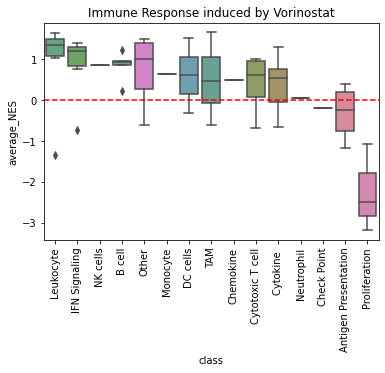

In [66]:
nes_by_class(sub_name='Vorinostat',
             nes_sub=df(tmp_nes.loc['vorinostat', :]),
             immuneSig_class=immune_class,
             immune_lut=immune_lut)

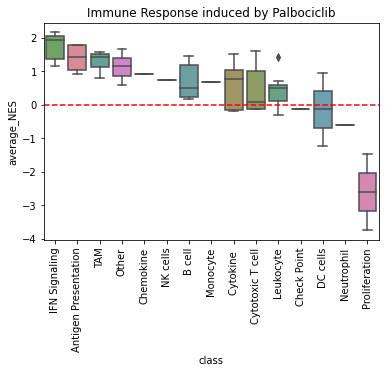

In [67]:
nes_by_class(sub_name='Palbociclib',
             nes_sub=df(tmp_nes.loc['palbociclib', :]),
             immuneSig_class=immune_class,
             immune_lut=immune_lut)

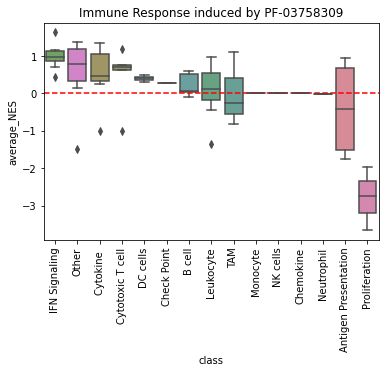

In [68]:
nes_by_class(sub_name='PF-03758309',
             nes_sub=df(tmp_nes.loc['PF-03758309', :]),
             immuneSig_class=immune_class,
             immune_lut=immune_lut)

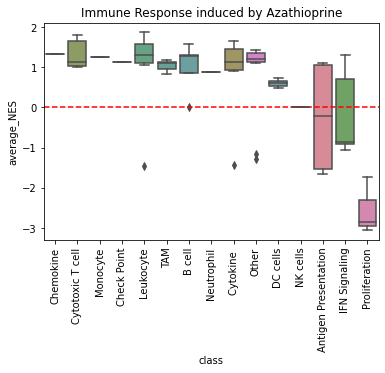

In [69]:
nes_by_class(sub_name='Azathioprine',
             nes_sub=df(tmp_nes.loc['azathioprine', :]),
             immuneSig_class=immune_class,
             immune_lut=immune_lut)

# Dosage dependence

In [70]:
tmp_saha = immune_nes[immune_nes['cmap_name'] == 'vorinostat']
tmp_saha.shape

(48, 72)

In [71]:
skcm_sig_info.columns

Index(['bead_batch', 'nearest_dose', 'pert_dose', 'pert_dose_unit',
       'pert_idose', 'pert_itime', 'pert_time', 'pert_time_unit',
       'cell_mfc_name', 'pert_mfc_id', 'nsample', 'cc_q75', 'ss_ngene', 'tas',
       'pct_self_rank_q25', 'wt', 'median_recall_rank_spearman',
       'median_recall_rank_wtcs_50', 'median_recall_score_spearman',
       'median_recall_score_wtcs_50', 'batch_effect_tstat',
       'batch_effect_tstat_pct', 'is_hiq', 'qc_pass', 'pert_id', 'pert_type',
       'cell_iname', 'det_wells', 'det_plates', 'distil_ids', 'build_name',
       'project_code', 'cmap_name', 'is_exemplar_sig', 'is_ncs_sig',
       'is_null_sig'],
      dtype='object')

In [72]:
skcm_sig_info

bead_batch  nearest_dose  \
sig_id                                                                  
PCL001_A375_24H:BRD-K59023263:10                    b20         10.00   
DOSBIO001_A375_24H:BRD-A19500257:3.33333            b11          3.33   
XPRJJ001_A375_96H:BRDN0001054845:-666               b21           NaN   
TAK003_A375_96H:TRCN0000051903:-666                  b7           NaN   
PRISM001_A375_24H:BRD-K59369769-001-05-4:2.5         b7          2.50   
...                                                 ...           ...   
DOSVAL001_A375_24H:BRD-K81418486:5                  b18          4.00   
DOSVAL005_A375_24H:BRD-K70836798:5                  b19          4.00   
DOSVAL002_A375_24H:BRD-K81418486:5                  b19          4.00   
DOSVAL005_A375_24H:BRD-K81418486:10                 b19         10.00   
DOSVAL002_A375_24H:BRD-K10749593:20                 b19         20.00   

                                              pert_dose pert_dose_unit  \
sig_id                                                                   
PCL001_A375_24H:BRD-K59023263:10               10.00000             uM   
DOSBIO001_A375_24H:BRD-A19500257:3.33333        3.33333             uM   
XPRJJ001_A375_96H:BRDN0001054845:-666               NaN            NaN   
TAK003_A375_96H:TRCN0000051903:-666                 NaN            NaN   
PRISM001_A375_24H:BRD-K59369769-001-05-4:2.5    2.50000             uM   
...                                                 ...            ...   
DOSVAL001_A375_24H:BRD-K81418486:5              5.00000             uM   
DOSVAL005_A375_24H:BRD-K70836798:5              5.00000             uM   
DOSVAL002_A375_24H:BRD-K81418486:5              5.00000             uM   
DOSVAL005_A375_24H:BRD-K81418486:10            10.00000             uM   
DOSVAL002_A375_24H:BRD-K10749593:20            20.00000             uM   

                                             pert_idose pert_itime  pert_time  \
sig_id                                                                          
PCL001_A375_24H:BRD-K59023263:10                  10 uM       24 h       24.0   
DOSBIO001_A375_24H:BRD-A19500257:3.33333        3.33 uM       24 h       24.0   
XPRJJ001_A375_96H:BRDN0001054845:-666               NaN       96 h       96.0   
TAK003_A375_96H:TRCN0000051903:-666                 NaN       96 h       96.0   
PRISM001_A375_24H:BRD-K59369769-001-05-4:2.5     2.5 uM       24 h       24.0   
...                                                 ...        ...        ...   
DOSVAL001_A375_24H:BRD-K81418486:5                 4 uM       24 h       24.0   
DOSVAL005_A375_24H:BRD-K70836798:5                 4 uM       24 h       24.0   
DOSVAL002_A375_24H:BRD-K81418486:5                 4 uM       24 h       24.0   
DOSVAL005_A375_24H:BRD-K81418486:10               10 uM       24 h       24.0   
DOSVAL002_A375_24H:BRD-K10749593:20               20 uM       24 h       24.0   

                                             pert_time_unit cell_mfc_name  \
sig_id                                                                      
PCL001_A375_24H:BRD-K59023263:10                          h          A375   
DOSBIO001_A375_24H:BRD-A19500257:3.33333                  h          A375   
XPRJJ001_A375_96H:BRDN0001054845:-666                     h          A375   
TAK003_A375_96H:TRCN0000051903:-666                       h          A375   
PRISM001_A375_24H:BRD-K59369769-001-05-4:2.5              h          A375   
...                                                     ...           ...   
DOSVAL001_A375_24H:BRD-K81418486:5                        h          A375   
DOSVAL005_A375_24H:BRD-K70836798:5                        h          A375   
DOSVAL002_A375_24H:BRD-K81418486:5                        h          A375   
DOSVAL005_A375_24H:BRD-K81418486:10                       h          A375   
DOSVAL002_A375_24H:BRD-K10749593:20                       h          A375   

                                                 pert_mfc_id  ...  cell_inam

In [73]:
tmp_saha_dose = skcm_sig_info[skcm_sig_info.index.isin(tmp_saha.index)][['nearest_dose', 'pert_time', 'cell_mfc_name']]

In [74]:
dependence_saha = df(index=['pert_dose', 'pert_time'])
for c in tmp_saha.columns:
    if c != 'cmap_name':
        tmp_a375 = tmp_saha_dose[tmp_saha_dose['cell_mfc_name'] == 'A375'].index
        dependence_saha.at[c, 'pert_dose'] = stats.spearmanr(tmp_saha.loc[tmp_a375, c], tmp_saha_dose.loc[tmp_a375, 'nearest_dose'])[0]
        dependence_saha.at[c, 'pert_time'] = stats.spearmanr(tmp_saha.loc[tmp_a375, c], tmp_saha_dose.loc[tmp_a375, 'pert_time'])[0]
dependence_saha = dependence_saha.dropna(axis=0, how='all')
dependence_saha['immune_class'] = immune_class['class']

<AxesSubplot:xlabel='pert_dose', ylabel='pert_time'>

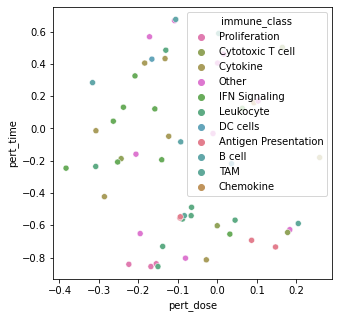

In [208]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='pert_dose', y='pert_time', hue='immune_class', data=dependence_saha, palette=immune_lut)

In [209]:
dependence_saha.sort_values(by='pert_dose')

pert_dose  pert_time          immune_class
Interferon_Cluster_21214954      -0.383435  -0.245969         IFN Signaling
B_cell_PCA_16704732              -0.316275   0.284077                B cell
Module4_TcellBcell_score         -0.308163  -0.235576             Leukocyte
IL8_21978456                     -0.307691  -0.013857             Cytokine 
IL4_score_21050467               -0.286185  -0.422651             Cytokine 
STAT1_score                      -0.263641   0.045037         IFN Signaling
ZHANG_INTERFERON_RESPONSE        -0.258830  -0.013857                   NaN
Interferon_19272155              -0.252699  -0.207861         IFN Signaling
MCD3_CD8_21214954                -0.243832  -0.187075      Cytotoxic T cell
Minterferon_Cluster_21214954     -0.238079   0.131645         IFN Signaling
CHANG_CORE_SERUM_RESPONSE_UP     -0.224307  -0.841837         Proliferation
Module3_IFN_score                -0.208743   0.325649         IFN Signaling
LIexpression_score               -0.206291  -0.159360                 Other
HER2_Immune_PCA_18006808         -0.195632  -0.651298                 Other
IL12_score_21050467              -0.184218   0.405329             Cytokine 
ICS5_score                       -0.171956   0.568154                 Other
Module11_Prolif_score            -0.168466  -0.855695         Proliferation
CD103pos_mean_25446897           -0.165919   0.429580              DC cells
IFN_21978456                     -0.158467   0.121252         IFN Signaling
CSR_Activated_15701700           -0.154883  -0.838373         Proliferation
T_cell_PCA_16704732              -0.150544  -0.855695             Leukocyte
IFNG_score_21050467              -0.141017  -0.194004         IFN Signaling
LCK_19272155                     -0.138565  -0.730978             Leukocyte
IL13_score_21050467              -0.132622   0.433044             Cytokine 
Module5_TcellBcell_score         -0.130641   0.485009             Leukocyte
IL2_score_21050467               -0.123284  -0.048501             Cytokine 
Troester_WoundSig_19887484       -0.108475   0.668620                 Other
IGG_Cluster_21214954             -0.105551   0.675548                B cell
MHC1_21978456                    -0.095080  -0.554296  Antigen Presentation
MHC.I_19272155                   -0.093854  -0.547367  Antigen Presentation
Bcell_receptors_score            -0.092911  -0.083144                B cell
Tcell_21978456                   -0.088478  -0.561225             Leukocyte
CSF1_response                    -0.083667  -0.540439                   TAM
GRANS_PCA_16704732               -0.080837  -0.803729                 Other
Tcell_receptors_score            -0.066500  -0.540439             Leukocyte
LYMPHS_PCA_16704732              -0.065462  -0.488473             Leukocyte
TGFB_score_21050467              -0.028015  -0.814122             Cytokine 
Buck14_score                     -0.011130  -0.031179                 Other
KEGG_HEMATOPOIETIC_CELL_LINEAGE  -0.004433  -0.038108                   NaN
CD8_PCA_16704732                 -0.000377  -0.602797      Cytotoxic T cell
Immune_NSCLC_score                0.000566   0.405329                 Other
TAMsurr_score                     0.003301   0.588940                   TAM
NHI_5gene_score                   0.015847   0.460759                 Other
IR7_score                         0.031599  -0.654762         IFN Signaling
CD103neg_mean_25446897            0.035844  -0.218254              DC cells
Immune_cell_Cluster_21214954      0.044805  -0.568154             Leukocyte
STAT1_19272155                    0.063198   0.124717         IFN Signaling
MHC2_21978456                     0.086591  -0.692870  Antigen Presentation
Chemokine12_score                 0.092439   0.159360             Chemokine
Rotterdam_ERneg_PCA_15721472      0.103004   0.169753                 Other
MHC.II_19272155                   0.147243  -0.734442  Antigen Presentation
CD8_CD68_ratio                    0.164599   0.502331      Cytotoxic T cell
TcCla

<AxesSubplot:xlabel='nearest_dose', ylabel='Interferon_Cluster_21214954'>

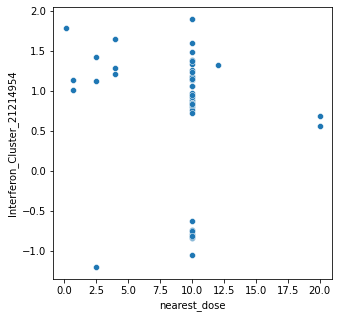

In [211]:
plt.figure(figsize=(5, 5))
sns.scatterplot(y=tmp_saha['Interferon_Cluster_21214954'], x=tmp_saha_dose['nearest_dose'])

In [188]:
dependence_saha.sort_values(by='pert_time')

pert_dose  pert_time          immune_class
Module11_Prolif_score            -0.168466  -0.855695         Proliferation
T_cell_PCA_16704732              -0.150544  -0.855695             Leukocyte
CHANG_CORE_SERUM_RESPONSE_UP     -0.224307  -0.841837         Proliferation
CSR_Activated_15701700           -0.154883  -0.838373         Proliferation
TGFB_score_21050467              -0.028015  -0.814122             Cytokine 
GRANS_PCA_16704732               -0.080837  -0.803729                 Other
MHC.II_19272155                   0.147243  -0.734442  Antigen Presentation
LCK_19272155                     -0.138565  -0.730978             Leukocyte
MHC2_21978456                     0.086591  -0.692870  Antigen Presentation
IR7_score                         0.031599  -0.654762         IFN Signaling
HER2_Immune_PCA_18006808         -0.195632  -0.651298                 Other
TcClassII_score                   0.177899  -0.644369      Cytotoxic T cell
MDACC.FNA.1_20805453              0.183464  -0.627048                 Other
CD8_PCA_16704732                 -0.000377  -0.602797      Cytotoxic T cell
TAMsurr_TcClassII_ratio           0.204876  -0.588940                   TAM
Immune_cell_Cluster_21214954      0.044805  -0.568154             Leukocyte
Tcell_21978456                   -0.088478  -0.561225             Leukocyte
MHC1_21978456                    -0.095080  -0.554296  Antigen Presentation
MHC.I_19272155                   -0.093854  -0.547367  Antigen Presentation
Tcell_receptors_score            -0.066500  -0.540439             Leukocyte
CSF1_response                    -0.083667  -0.540439                   TAM
LYMPHS_PCA_16704732              -0.065462  -0.488473             Leukocyte
IL4_score_21050467               -0.286185  -0.422651             Cytokine 
Interferon_Cluster_21214954      -0.383435  -0.245969         IFN Signaling
Module4_TcellBcell_score         -0.308163  -0.235576             Leukocyte
CD103neg_mean_25446897            0.035844  -0.218254              DC cells
Interferon_19272155              -0.252699  -0.207861         IFN Signaling
IFNG_score_21050467              -0.141017  -0.194004         IFN Signaling
MCD3_CD8_21214954                -0.243832  -0.187075      Cytotoxic T cell
TGFB_PCA_17349583                 0.259113  -0.180146             Cytokine 
LIexpression_score               -0.206291  -0.159360                 Other
Bcell_receptors_score            -0.092911  -0.083144                B cell
IL2_score_21050467               -0.123284  -0.048501             Cytokine 
KEGG_HEMATOPOIETIC_CELL_LINEAGE  -0.004433  -0.038108                   NaN
Buck14_score                     -0.011130  -0.031179                 Other
ZHANG_INTERFERON_RESPONSE        -0.258830  -0.013857                   NaN
IL8_21978456                     -0.307691  -0.013857             Cytokine 
STAT1_score                      -0.263641   0.045037         IFN Signaling
IFN_21978456                     -0.158467   0.121252         IFN Signaling
STAT1_19272155                    0.063198   0.124717         IFN Signaling
Minterferon_Cluster_21214954     -0.238079   0.131645         IFN Signaling
Chemokine12_score                 0.092439   0.159360             Chemokine
Rotterdam_ERneg_PCA_15721472      0.103004   0.169753                 Other
B_cell_PCA_16704732              -0.316275   0.284077                B cell
Module3_IFN_score                -0.208743   0.325649         IFN Signaling
Immune_NSCLC_score                0.000566   0.405329                 Other
IL12_score_21050467              -0.184218   0.405329             Cytokine 
CD103pos_mean_25446897           -0.165919   0.429580              DC cells
IL13_score_21050467              -0.132622   0.433044             Cytokine 
NHI_5gene_score                   0.015847   0.460759                 Other
Module5_TcellBcell_score         -0.130641   0.485009             Leukocyte
CD8_CD68_ratio                    0.164599   0.502331      Cytotoxic T cell
ICS5_

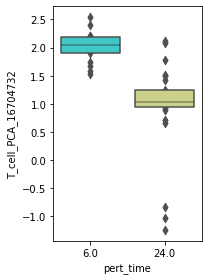

In [218]:
plt.figure(figsize=(3, 4))
sns.boxenplot(y=tmp_saha['T_cell_PCA_16704732'], x=tmp_saha_dose['pert_time'], palette='rainbow')
plt.tight_layout()

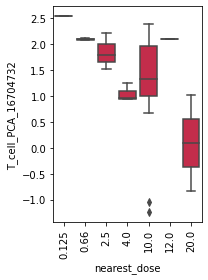

In [219]:
plt.figure(figsize=(3, 4))
sns.boxplot(y=tmp_saha['T_cell_PCA_16704732'], x=tmp_saha_dose['nearest_dose'], color='crimson')
plt.xticks(rotation=90)
plt.tight_layout()

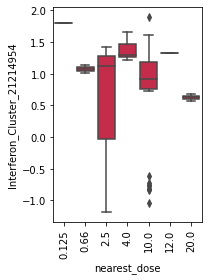

In [259]:
plt.figure(figsize=(3, 4))
sns.boxplot(y=tmp_saha['Interferon_Cluster_21214954'], x=tmp_saha_dose['nearest_dose'], color='crimson')
plt.xticks(rotation=90)
plt.tight_layout()

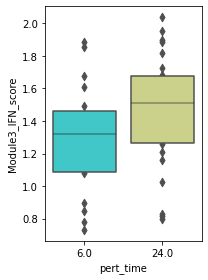

In [221]:
plt.figure(figsize=(3, 4))
sns.boxenplot(y=tmp_saha['Module3_IFN_score'], x=tmp_saha_dose['pert_time'], palette='rainbow')
plt.tight_layout()

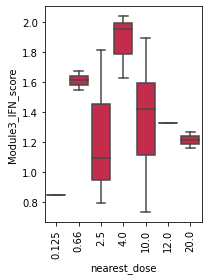

In [222]:
plt.figure(figsize=(3, 4))
sns.boxplot(y=tmp_saha['Module3_IFN_score'], x=tmp_saha_dose['nearest_dose'], color='crimson')
plt.xticks(rotation=90)
plt.tight_layout()

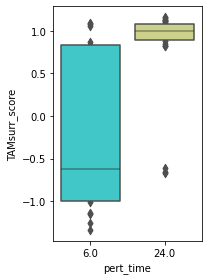

In [223]:
plt.figure(figsize=(3, 4))
sns.boxenplot(y=tmp_saha['TAMsurr_score'], x=tmp_saha_dose['pert_time'], palette='rainbow')
plt.tight_layout()

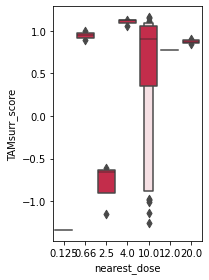

In [224]:
plt.figure(figsize=(3, 4))
sns.boxenplot(y=tmp_saha['TAMsurr_score'], x=tmp_saha_dose['nearest_dose'], color='crimson')
plt.tight_layout()

In [225]:
tmp_palb = immune_nes[immune_nes['cmap_name'] == 'palbociclib']
tmp_palb.shape

(8, 72)

In [226]:
tmp_palb_dose = skcm_sig_info[skcm_sig_info.index.isin(tmp_palb.index)][['nearest_dose', 'pert_time', 'cell_mfc_name']]

In [227]:
tmp_palb_dose

nearest_dose  pert_time cell_mfc_name
sig_id                                                      
REP.A016_A375_24H:A20          3.33       24.0          A375
REP.A016_A375_24H:A21          1.11       24.0          A375
REP.A016_A375_24H:A19         10.00       24.0          A375
REP.B016_A375_24H:A19          2.22       24.0          A375
MOAR004_A375_24H:K22          10.00       24.0          A375
MOAR004_A375_24H:K23           3.33       24.0          A375
MOAR019_A375_24H:K23           0.66       24.0          A375
MOAR004_A375_24H:K24           1.11       24.0          A375

In [228]:
dependence_palb = df(index=['pert_dose', 'pert_time'])
for c in tmp_palb.columns:
    if c != 'cmap_name':
        tmp_a375 = tmp_palb_dose[tmp_palb_dose['cell_mfc_name'] == 'A375'].index
        dependence_palb.at[c, 'pert_dose'] = stats.spearmanr(tmp_palb.loc[tmp_a375, c], tmp_palb_dose.loc[tmp_a375, 'nearest_dose'])[0]
        dependence_palb.at[c, 'pert_time'] = stats.spearmanr(tmp_palb.loc[tmp_a375, c], tmp_palb_dose.loc[tmp_a375, 'pert_time'])[0]
dependence_palb = dependence_palb.dropna(axis=0, how='all')
dependence_palb['immune_class'] = immune_class['class']

C:\Users\ywang\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\stats\stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [230]:
dependence_palb.sort_values(by='pert_dose')

pert_dose  pert_time          immune_class
TcClassII_score                  -0.981981        NaN      Cytotoxic T cell
TAMsurr_TcClassII_ratio          -0.836502        NaN                   TAM
MHC2_21978456                    -0.836502        NaN  Antigen Presentation
MDACC.FNA.1_20805453             -0.824379        NaN                 Other
HER2_Immune_PCA_18006808         -0.800132        NaN                 Other
Troester_WoundSig_19887484       -0.739516        NaN                 Other
ZHANG_INTERFERON_RESPONSE        -0.678900        NaN                   NaN
Interferon_Cluster_21214954      -0.630407        NaN         IFN Signaling
TGFB_score_21050467              -0.630407        NaN             Cytokine 
CD103pos_mean_25446897           -0.630407        NaN              DC cells
IFN_21978456                     -0.630407        NaN         IFN Signaling
Bcell_receptors_score            -0.630407        NaN                B cell
MCD3_CD8_21214954                -0.618284        NaN      Cytotoxic T cell
Chemokine12_score                -0.606161        NaN             Chemokine
CSF1_response                    -0.569791        NaN                   TAM
ICS5_score                       -0.569791        NaN                 Other
Minterferon_Cluster_21214954     -0.545545        NaN         IFN Signaling
Module3_IFN_score                -0.545545        NaN         IFN Signaling
MHC.I_19272155                   -0.533422        NaN  Antigen Presentation
Immune_cell_Cluster_21214954     -0.533422        NaN             Leukocyte
TGFB_PCA_17349583                -0.497052        NaN             Cytokine 
CD8_PCA_16704732                 -0.472805        NaN      Cytotoxic T cell
IFNG_score_21050467              -0.472805        NaN         IFN Signaling
STAT1_score                      -0.448559        NaN         IFN Signaling
Module5_TcellBcell_score         -0.436436        NaN             Leukocyte
B_cell_PCA_16704732              -0.424313        NaN                B cell
CHANG_CORE_SERUM_RESPONSE_UP     -0.424313        NaN         Proliferation
MHC.II_19272155                  -0.412189        NaN  Antigen Presentation
GRANS_PCA_16704732               -0.412189        NaN                 Other
CSR_Activated_15701700           -0.400066        NaN         Proliferation
LCK_19272155                     -0.387943        NaN             Leukocyte
Interferon_19272155              -0.387943        NaN         IFN Signaling
CD8_CD68_ratio                   -0.375820        NaN      Cytotoxic T cell
STAT1_19272155                   -0.339450        NaN         IFN Signaling
NHI_5gene_score                  -0.303080        NaN                 Other
KEGG_HEMATOPOIETIC_CELL_LINEAGE  -0.303080        NaN                   NaN
IL12_score_21050467              -0.290957        NaN             Cytokine 
MHC1_21978456                    -0.278834        NaN  Antigen Presentation
LYMPHS_PCA_16704732              -0.254588        NaN             Leukocyte
TAMsurr_score                    -0.218218        NaN                   TAM
IGG_Cluster_21214954             -0.193971        NaN                B cell
IR7_score                        -0.181848        NaN         IFN Signaling
LIexpression_score               -0.145479        NaN                 Other
Tcell_21978456                   -0.133355        NaN             Leukocyte
Module4_TcellBcell_score         -0.109109        NaN             Leukocyte
Rotterdam_ERneg_PCA_15721472     -0.084863        NaN                 Other
Buck14_score                     -0.072739        NaN                 Other
IL8_21978456                     -0.060616        NaN             Cytokine 
Module11_Prolif_score            -0.012123        NaN         Proliferation
T_cell_PCA_16704732               0.000000        NaN             Leukocyte
IL2_score_21050467                0.036370        NaN             Cytokine 
IL13_score_21050467               0.072739        NaN             Cytokine 
Tcell

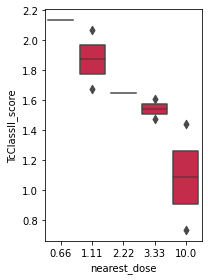

In [232]:
plt.figure(figsize=(3, 4))
sns.boxenplot(y=tmp_palb['TcClassII_score'], x=tmp_palb_dose['nearest_dose'], color='crimson')
plt.tight_layout()

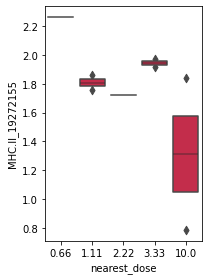

In [233]:
plt.figure(figsize=(3, 4))
sns.boxenplot(y=tmp_palb['MHC.II_19272155'], x=tmp_palb_dose['nearest_dose'], color='crimson')
plt.tight_layout()

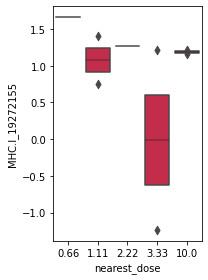

In [234]:
plt.figure(figsize=(3, 4))
sns.boxenplot(y=tmp_palb['MHC.I_19272155'], x=tmp_palb_dose['nearest_dose'], color='crimson')
plt.tight_layout()

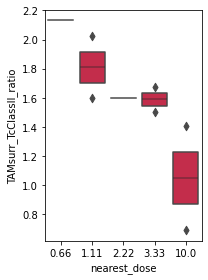

In [237]:
plt.figure(figsize=(3, 4))
sns.boxenplot(y=tmp_palb['TAMsurr_TcClassII_ratio'], x=tmp_palb_dose['nearest_dose'], color='crimson')
plt.tight_layout()

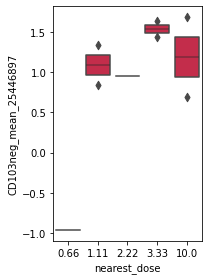

In [238]:
plt.figure(figsize=(3, 4))
sns.boxenplot(y=tmp_palb['CD103neg_mean_25446897'], x=tmp_palb_dose['nearest_dose'], color='crimson')
plt.tight_layout()

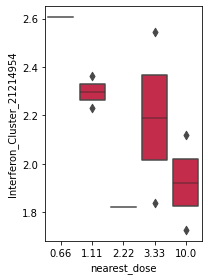

In [239]:
plt.figure(figsize=(3, 4))
sns.boxenplot(y=tmp_palb['Interferon_Cluster_21214954'], x=tmp_palb_dose['nearest_dose'], color='crimson')
plt.tight_layout()

In [240]:
tmp_pak4 = immune_nes[immune_nes['cmap_name'] == 'PF-03758309']
tmp_pak4.shape

(4, 72)

In [241]:
tmp_pak4_dose = skcm_sig_info[skcm_sig_info.index.isin(tmp_pak4.index)][['nearest_dose', 'pert_time', 'cell_mfc_name']]

In [242]:
tmp_pak4_dose

nearest_dose  pert_time cell_mfc_name
sig_id                                                      
LJP009_A375_24H:D02            3.33       24.0          A375
REP.A014_A375_24H:K13         10.00       24.0          A375
MOAR004_A375_24H:A18           1.11       24.0          A375
MOAR004_A375_24H:A17           3.33       24.0          A375

In [243]:
dependence_pak4 = df(index=['pert_dose', 'pert_time'])
for c in tmp_pak4.columns:
    if c != 'cmap_name':
        tmp_a375 = tmp_pak4_dose[tmp_pak4_dose['cell_mfc_name'] == 'A375'].index
        dependence_pak4.at[c, 'pert_dose'] = stats.spearmanr(tmp_pak4.loc[tmp_a375, c], tmp_pak4_dose.loc[tmp_a375, 'nearest_dose'])[0]
        dependence_pak4.at[c, 'pert_time'] = stats.spearmanr(tmp_pak4.loc[tmp_a375, c], tmp_pak4_dose.loc[tmp_a375, 'pert_time'])[0]
dependence_pak4 = dependence_pak4.dropna(axis=0, how='all')
dependence_pak4['immune_class'] = immune_class['class']

C:\Users\ywang\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\stats\stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [244]:
dependence_pak4.sort_values(by='pert_dose')

pert_dose  pert_time          immune_class
IL4_score_21050467               -0.948683        NaN             Cytokine 
ICS5_score                       -0.948683        NaN                 Other
IL13_score_21050467              -0.948683        NaN             Cytokine 
Module3_IFN_score                -0.948683        NaN         IFN Signaling
Minterferon_Cluster_21214954     -0.948683        NaN         IFN Signaling
TGFB_score_21050467              -0.948683        NaN             Cytokine 
IL2_score_21050467               -0.948683        NaN             Cytokine 
IFNG_score_21050467              -0.948683        NaN         IFN Signaling
CHANG_CORE_SERUM_RESPONSE_UP     -0.632456        NaN         Proliferation
NHI_5gene_score                  -0.632456        NaN                 Other
T_cell_PCA_16704732              -0.632456        NaN             Leukocyte
LCK_19272155                     -0.632456        NaN             Leukocyte
Interferon_19272155              -0.632456        NaN         IFN Signaling
MHC.I_19272155                   -0.632456        NaN  Antigen Presentation
IFN_21978456                     -0.632456        NaN         IFN Signaling
MCD3_CD8_21214954                -0.632456        NaN      Cytotoxic T cell
MHC1_21978456                    -0.632456        NaN  Antigen Presentation
Module11_Prolif_score            -0.632456        NaN         Proliferation
STAT1_19272155                   -0.632456        NaN         IFN Signaling
GRANS_PCA_16704732               -0.632456        NaN                 Other
CSR_Activated_15701700           -0.316228        NaN         Proliferation
ZHANG_INTERFERON_RESPONSE        -0.316228        NaN                   NaN
TAMsurr_score                    -0.316228        NaN                   TAM
Troester_WoundSig_19887484       -0.316228        NaN                 Other
MHC2_21978456                    -0.316228        NaN  Antigen Presentation
IL12_score_21050467              -0.316228        NaN             Cytokine 
Interferon_Cluster_21214954      -0.316228        NaN         IFN Signaling
MHC.II_19272155                  -0.316228        NaN  Antigen Presentation
TGFB_PCA_17349583                -0.316228        NaN             Cytokine 
HER2_Immune_PCA_18006808         -0.316228        NaN                 Other
STAT1_score                      -0.316228        NaN         IFN Signaling
CD8_PCA_16704732                 -0.316228        NaN      Cytotoxic T cell
Module4_TcellBcell_score         -0.316228        NaN             Leukocyte
IGG_Cluster_21214954              0.316228        NaN                B cell
Immune_NSCLC_score                0.316228        NaN                 Other
Rotterdam_ERneg_PCA_15721472      0.316228        NaN                 Other
IR7_score                         0.316228        NaN         IFN Signaling
CD103neg_mean_25446897            0.316228        NaN              DC cells
KEGG_HEMATOPOIETIC_CELL_LINEAGE   0.316228        NaN                   NaN
CSF1_response                     0.316228        NaN                   TAM
Buck14_score                      0.316228        NaN                 Other
B_cell_PCA_16704732               0.316228        NaN                B cell
TAMsurr_TcClassII_ratio           0.316228        NaN                   TAM
CD8_CD68_ratio                    0.316228        NaN      Cytotoxic T cell
Chemokine12_score                 0.316228        NaN             Chemokine
Module5_TcellBcell_score          0.316228        NaN             Leukocyte
Tcell_receptors_score             0.316228        NaN             Leukocyte
Immune_cell_Cluster_21214954      0.316228        NaN             Leukocyte
TcClassII_score                   0.316228        NaN      Cytotoxic T cell
MDACC.FNA.1_20805453              0.632456        NaN                 Other
IL8_21978456                      0.632456        NaN             Cytokine 
LYMPHS_PCA_16704732               0.632456        NaN             Leukocyte
Bcell

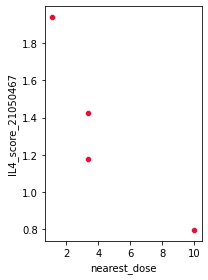

In [246]:
plt.figure(figsize=(3, 4))
sns.scatterplot(y=tmp_pak4['IL4_score_21050467'], x=tmp_pak4_dose['nearest_dose'], color='crimson')
plt.tight_layout()

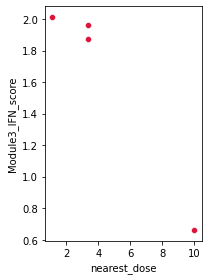

In [247]:
plt.figure(figsize=(3, 4))
sns.scatterplot(y=tmp_pak4['Module3_IFN_score'], x=tmp_pak4_dose['nearest_dose'], color='crimson')
plt.tight_layout()

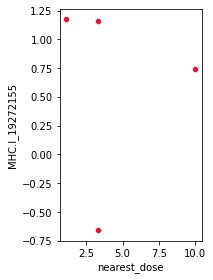

In [248]:
plt.figure(figsize=(3, 4))
sns.scatterplot(y=tmp_pak4['MHC.I_19272155'], x=tmp_pak4_dose['nearest_dose'], color='crimson')
plt.tight_layout()

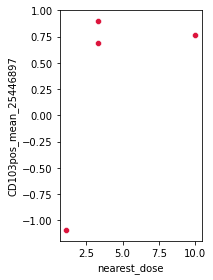

In [250]:
plt.figure(figsize=(3, 4))
sns.scatterplot(y=tmp_pak4['CD103pos_mean_25446897'], x=tmp_pak4_dose['nearest_dose'], color='crimson')
plt.tight_layout()

# selected cases

In [251]:
def case_shiftGSEA(case_name, cmap_sig):
    if case_name not in os.listdir(gsea_home + 'SKCM_v2/shift_case_visual/'):
        os.mkdir(gsea_home + 'SKCM_v2/shift_case_visual/' + case_name)
    for p in cmap_sig.index:
        p_rename = '__'.join(p.split(':'))
        rnk = pd.read_csv(gsea_home + '/SKCM/compound_all/' + p_rename + '.rnk', header=None, sep="\t")
        pre_res = gp.prerank(rnk=rnk, gene_sets=gsea_home + '/gene_sets/NREC_REC_91061.gmt',
                             processes=1,
                             permutation_num=100, # reduce number to speed up testing
                             outdir=gsea_home + 'SKCM_v2/shift_case_visual/' + case_name + '/' + p_rename,
                             format='png', seed=0, min_size=0, max_size=10000)
    print(case_name + ' finished...')
    return

In [253]:
case_shiftGSEA(case_name='vorinostat', cmap_sig=tmp_saha_dose[tmp_saha_dose['cell_mfc_name'] == 'A375'])

vorinostat finished...


In [254]:
case_shiftGSEA(case_name='palbociclib', cmap_sig=tmp_palb_dose[tmp_palb_dose['cell_mfc_name'] == 'A375'])

palbociclib finished...


In [255]:
case_shiftGSEA(case_name='PF-03758309', cmap_sig=tmp_pak4_dose[tmp_pak4_dose['cell_mfc_name'] == 'A375'])

PF-03758309 finished...


In [256]:
case_shiftGSEA(case_name='azathioprine', cmap_sig=skcm_sig_info[skcm_sig_info['cmap_name'] == 'azathioprine'])

azathioprine finished...


In [261]:
skcm_sig_info[skcm_sig_info['cmap_name'] == 'azathioprine']

bead_batch  nearest_dose  pert_dose  \
sig_id                                                                          
CPC007_A375_24H:BRD-K32821942-001-12-2:10         b3          10.0       10.0   
REP.A003_A375_24H:F19                            b22          10.0       10.0   

                                          pert_dose_unit pert_idose  \
sig_id                                                                
CPC007_A375_24H:BRD-K32821942-001-12-2:10             uM      10 uM   
REP.A003_A375_24H:F19                                 uM      10 uM   

                                          pert_itime  pert_time  \
sig_id                                                            
CPC007_A375_24H:BRD-K32821942-001-12-2:10       24 h       24.0   
REP.A003_A375_24H:F19                           24 h       24.0   

                                          pert_time_unit cell_mfc_name  \
sig_id                                                                   
CPC007_A375_24H:BRD-K32821942-001-12-2:10              h          A375   
REP.A003_A375_24H:F19                                  h          A375   

                                             pert_mfc_id  ...  cell_iname  \
sig_id                                                    ...               
CPC007_A375_24H:BRD-K32821942-001-12-2:10  BRD-K32821942  ...        A375   
REP.A003_A375_24H:F19                      BRD-K32821942  ...        A375   

                                           det_wells  \
sig_id                                                 
CPC007_A375_24H:BRD-K32821942-001-12-2:10        M14   
REP.A003_A375_24H:F19                            F19   

                                                                                  det_plates  \
sig_id                                                                                         
CPC007_A375_24H:BRD-K32821942-001-12-2:10  CPC007_A375_24H_X1_B3_DUO52HI53LO|CPC007_A375_...   
REP.A003_A375_24H:F19                      REP.A003_A375_24H_X1_B22|REP.A003_A375_24H_X2_...   

                                                                                  distil_ids  \
sig_id                                                                                         
CPC007_A375_24H:BRD-K32821942-001-12-2:10  CPC007_A375_24H_X1_B3_DUO52HI53LO:M14|CPC007_A...   
REP.A003_A375_24H:F19                      REP.A003_A375_24H_X1_B22:F19|REP.A003_A375_24H...   

                                           build_name project_code  \
sig_id                                                               
CPC007_A375_24H:BRD-K32821942-001-12-2:10         NaN          CPC   
REP.A003_A375_24H:F19                             NaN          REP   

                                              cmap_name  is_exemplar_sig  \
sig_id                                                                     
CPC007_A375_24H:BRD-K32821942-001-12-2:10  azathioprine                1   
REP.A003_A375_24H:F19                      azathioprine                0   

                                           is_ncs_sig  is_null_sig  
sig_id                                                              
CPC007_A375_24H:BRD-K32821942-001-12-2:10         1.0          0.0  
REP.A003_A375_24H:F19                             1.0          0.0  

[2 rows x 36 columns]

# Dosage dependence on NREC and REC

In [78]:
hi_conf_sig['dose'] = skcm_sig_info['nearest_dose']
hi_conf_sig['time'] = skcm_sig_info['pert_time']
hi_conf_sig['cell_line'] = skcm_sig_info['cell_mfc_name']

hi_conf_sig['dose_cat'] = ''
hi_conf_sig.loc[hi_conf_sig[hi_conf_sig['dose'] < 10].index, 'dose_cat'] = 'low'
hi_conf_sig.loc[hi_conf_sig[hi_conf_sig['dose'] >= 10].index, 'dose_cat'] = 'medium'
hi_conf_sig.loc[hi_conf_sig[hi_conf_sig['dose'] >= 20].index, 'dose_cat'] = 'high'

hi_conf_sig['dose_color'] = ''
hi_conf_sig.loc[hi_conf_sig[hi_conf_sig['dose_cat'] == 'low'].index, 'dose_color'] = 'royalblue'
hi_conf_sig.loc[hi_conf_sig[hi_conf_sig['dose_cat'] == 'medium'].index, 'dose_color'] = 'moccasin'
hi_conf_sig.loc[hi_conf_sig[hi_conf_sig['dose_cat'] == 'high'].index, 'dose_color'] = 'crimson'

C:\Users\ywang\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\ywang\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\ywang\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [250]:
hi_conf_sig

NREC_profile  REC_profile  \
PBIOA017_A375_24H:M03                           -0.479056     0.479557   
MOAR002_A375_24H:F16                            -0.428454     0.527919   
REP.A005_A375_24H:I19                           -0.489461     0.452204   
BRAF001_A375_24H:BRD-K09951645-001-02-7:2.5     -0.488362     0.441918   
REP.A021_A375_24H:C13                           -0.437620     0.487175   
...                                                   ...          ...   
MOAR006_A375_24H:C09                            -0.298506     0.403869   
DOSVAL001_A375_24H:BRD-K81418486:10             -0.387172     0.314976   
PBIOA017_A375_24H:I13                           -0.325388     0.375665   
REP.A026_A375_24H:D14                           -0.351262     0.349365   
DOSVAL004_A375_24H:BRD-K81418486:10             -0.386596     0.313822   

                                                cmap_name  shift_ability  \
PBIOA017_A375_24H:M03                            GDC-0879      -0.958613   
MOAR002_A375_24H:F16                         trifluridine      -0.956373   
REP.A005_A375_24H:I19                          dabrafenib      -0.941665   
BRAF001_A375_24H:BRD-K09951645-001-02-7:2.5    dabrafenib      -0.930280   
REP.A021_A375_24H:C13                           nilotinib      -0.924796   
...                                                   ...            ...   
MOAR006_A375_24H:C09                            filanesib      -0.702375   
DOSVAL001_A375_24H:BRD-K81418486:10            vorinostat      -0.702148   
PBIOA017_A375_24H:I13                           alisertib      -0.701053   
REP.A026_A375_24H:D14                          bortezomib      -0.700627   
DOSVAL004_A375_24H:BRD-K81418486:10            vorinostat      -0.700418   

                                                 type  \
PBIOA017_A375_24H:M03                        compound   
MOAR002_A375_24H:F16                         compound   
REP.A005_A375_24H:I19                        compound   
BRAF001_A375_24H:BRD-K09951645-001-02-7:2.5  compound   
REP.A021_A375_24H:C13                        compound   
...                                               ...   
MOAR006_A375_24H:C09                         compound   
DOSVAL001_A375_24H:BRD-K81418486:10          compound   
PBIOA017_A375_24H:I13                        compound   
REP.A026_A375_24H:D14                        compound   
DOSVAL004_A375_24H:BRD-K81418486:10          compound   

                                                                        MOA  \
PBIOA017_A375_24H:M03                                         RAF inhibitor   
MOAR002_A375_24H:F16                         Thymidylate synthase inhibitor   
REP.A005_A375_24H:I19                                         RAF inhibitor   
BRAF001_A375_24H:BRD-K09951645-001-02-7:2.5                   RAF inhibitor   
REP.A021_A375_24H:C13                                  Abl kinase inhibitor   
...                                                                     ...   
MOAR006_A375_24H:C09                                      Kinesin inhibitor   
DOSVAL001_A375_24H:BRD-K81418486:10                          HDAC inhibitor   
PBIOA017_A375_24H:I13                               Aurora kinase inhibitor   
REP.A026_A375_24H:D14                                  Proteasome inhibitor   
DOSVAL004_A375_24H:BRD-K81418486:10                          HDAC inhibitor   

                                            target   dose  time cell_line  \
PBIOA017_A375_24H:M03                         BRAF   1.11  24.0      A375   
MOAR002_A375_24H:F16                          TYMS  10.00  24.0      A375   
REP.A005_A375_24H:I19                         BRAF  10.00  24.0      A375   
BRAF001_A375_24H:BRD-K09951645-001-02-7:2.5   BRAF   2.50  24.0      A375   
REP.A021_A375_24H:C13                         ABL1  10.00  24.0      A375   
...                                            ...    ...   ...       ...   
MOAR006_A375_24H:C09                         KIF11   1.11  24.0      A

In [251]:
hi_conf_sig.to_csv(data_home + 'high_conf_hit/high_conf_NREC_REC_shift.csv', sep=',')

In [252]:
# take the compounds with multiple hits
hcs_multi = list(hi_conf_sig['cmap_name'].value_counts()[:13].index)
hcs_multi_sig = hi_conf_sig[hi_conf_sig['cmap_name'].isin(hcs_multi)]

<AxesSubplot:xlabel='dose', ylabel='NREC_profile'>

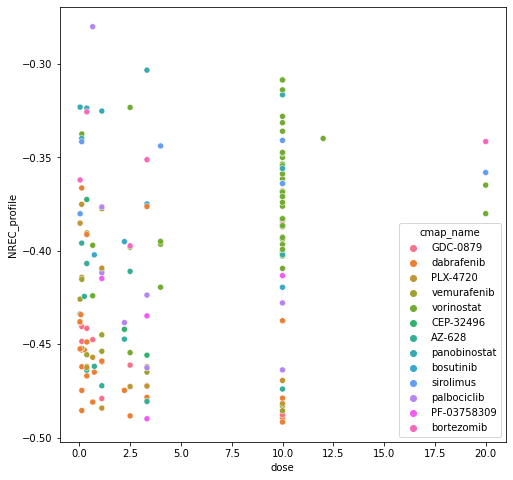

In [107]:
# NREC by dose
plt.figure(figsize=(8, 8))
sns.scatterplot(x='dose', y='NREC_profile', data=hcs_multi_sig, hue='cmap_name')

<AxesSubplot:xlabel='dose', ylabel='REC_profile'>

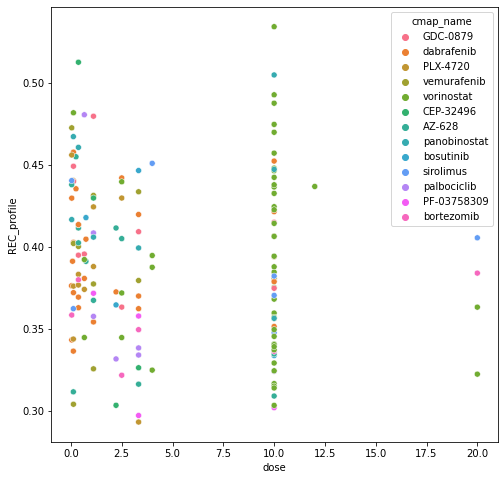

In [108]:
# REC by dose
plt.figure(figsize=(8, 8))
sns.scatterplot(x='dose', y='REC_profile', data=hcs_multi_sig, hue='cmap_name')

<AxesSubplot:xlabel='dose', ylabel='shift_ability'>

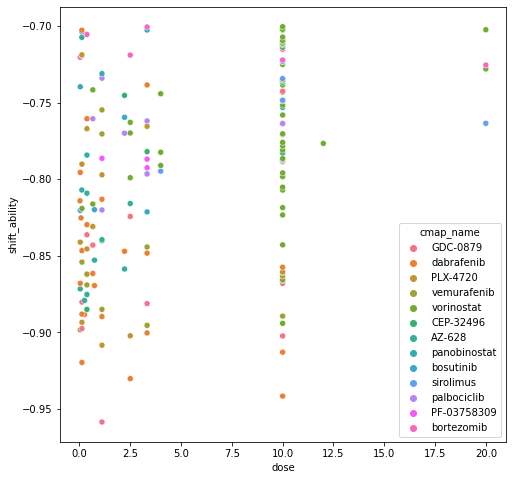

In [109]:
# shift_ability by dose
plt.figure(figsize=(8, 8))
sns.scatterplot(x='dose', y='shift_ability', data=hcs_multi_sig, hue='cmap_name')

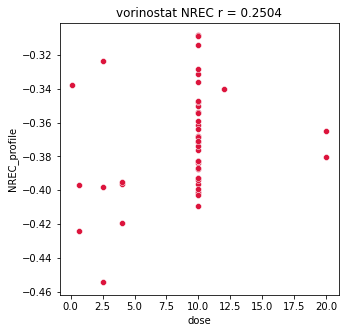

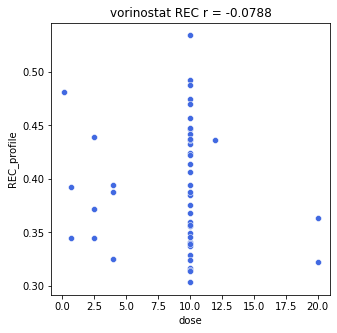

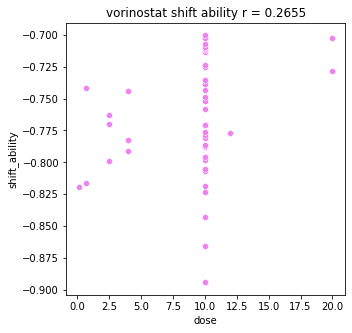

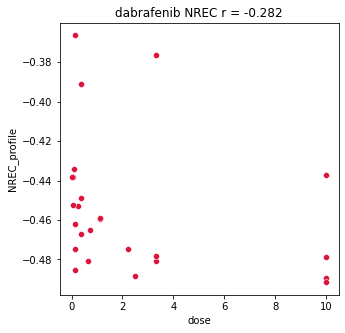

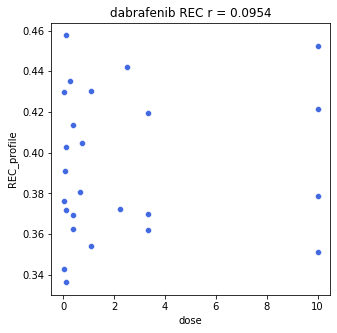

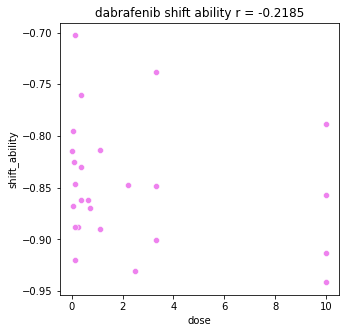

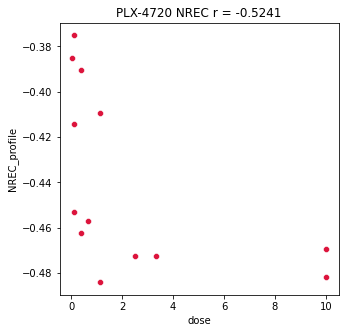

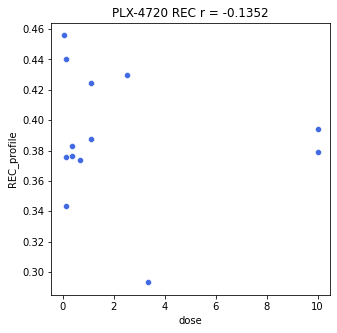

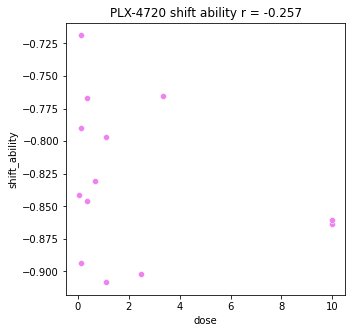

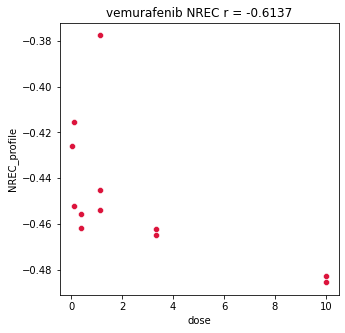

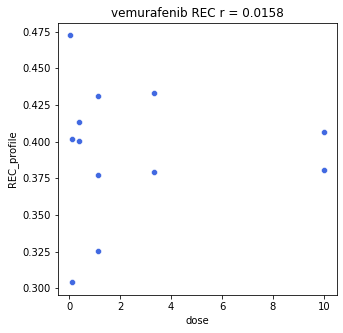

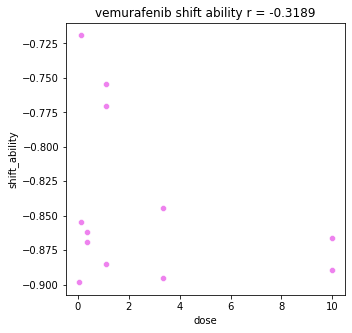

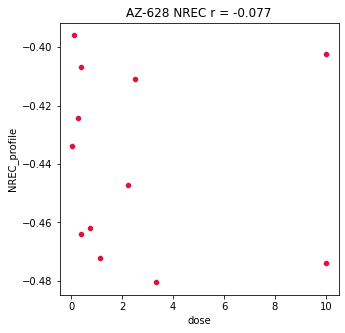

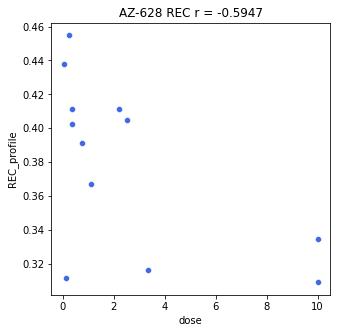

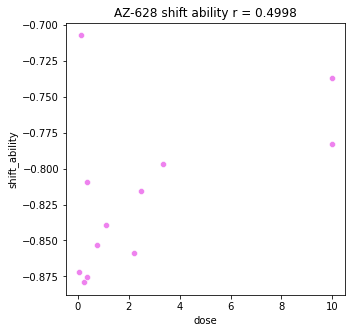

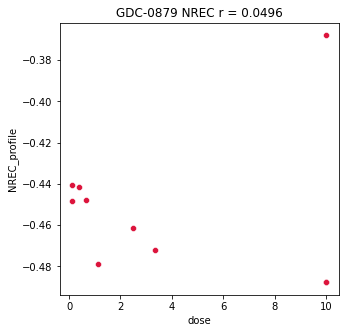

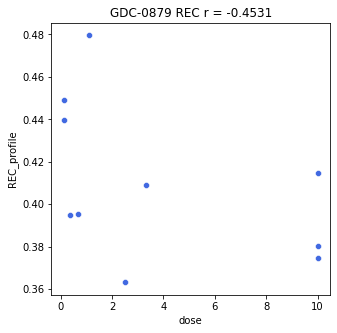

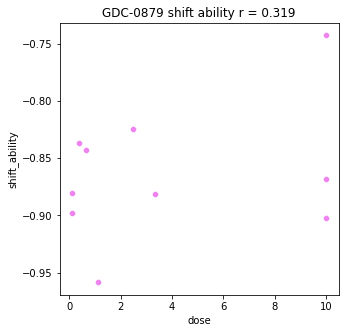

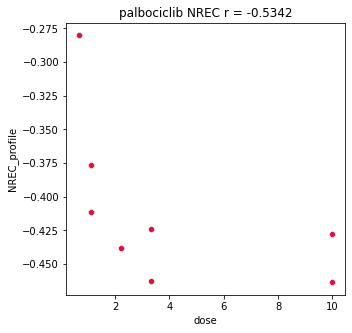

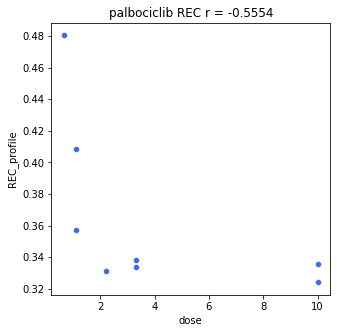

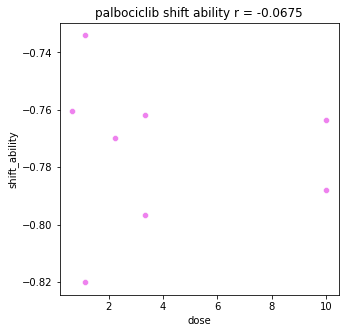

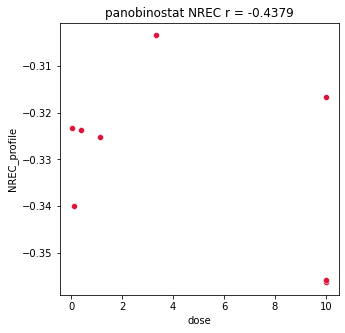

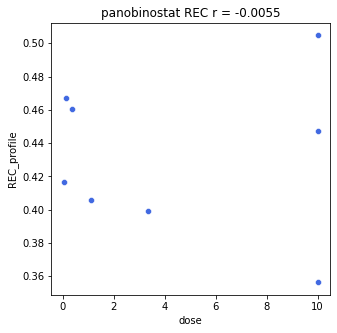

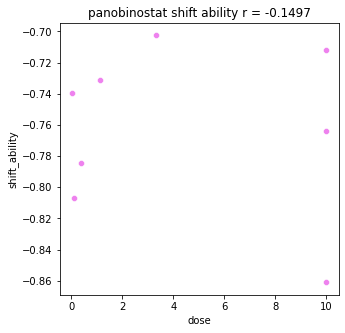

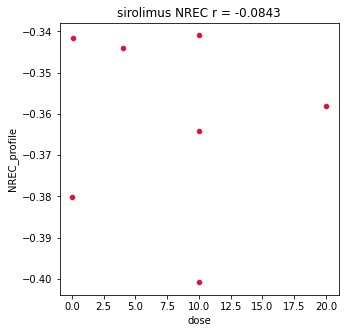

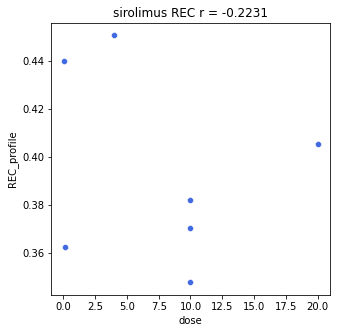

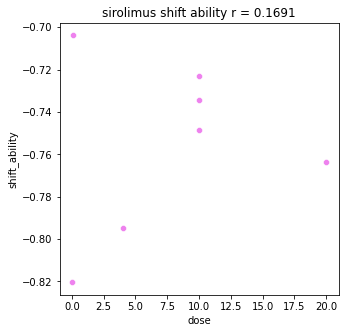

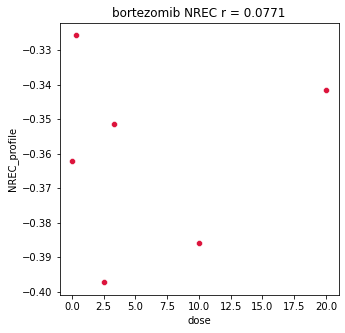

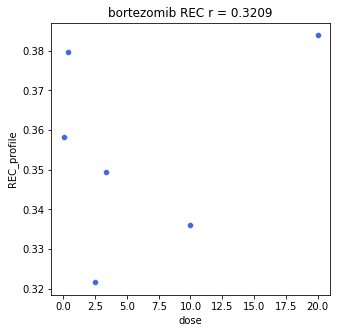

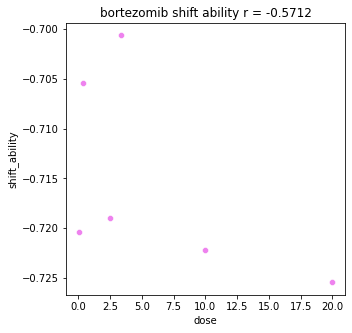

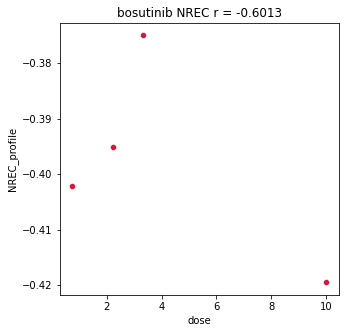

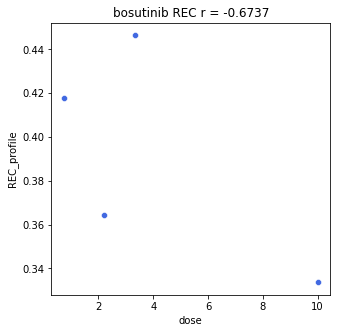

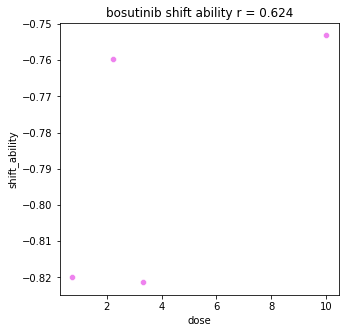

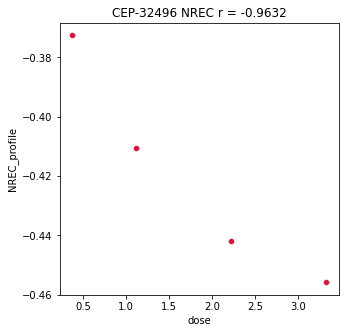

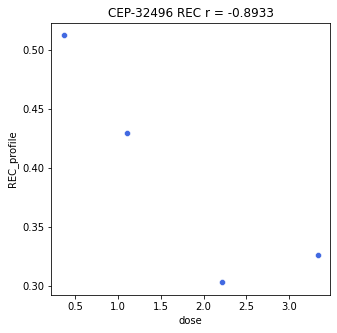

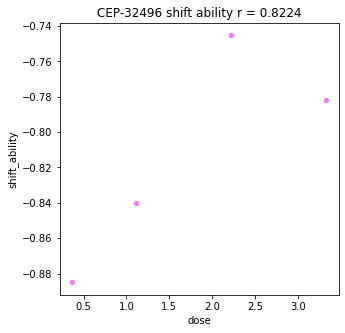

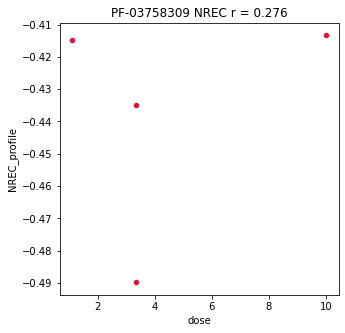

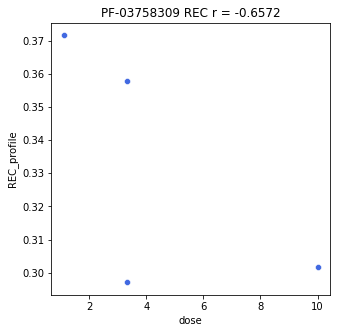

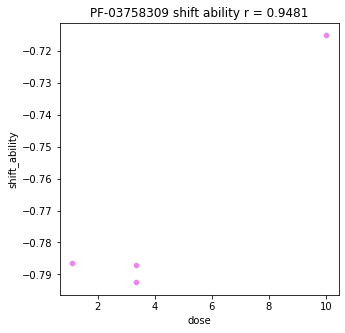

In [110]:
for d in hcs_multi:
    tmp_d = hcs_multi_sig[hcs_multi_sig['cmap_name'] == d]
    plt.figure(figsize=(5, 5))
    sns.scatterplot(x='dose', y='NREC_profile', data=tmp_d, color='crimson')
    plt.title(d + ' NREC r = ' + str(np.round(stats.pearsonr(tmp_d['dose'], tmp_d['NREC_profile'])[0], 4)))
    plt.show()
    
    plt.figure(figsize=(5, 5))
    sns.scatterplot(x='dose', y='REC_profile', data=tmp_d, color='royalblue')
    plt.title(d + ' REC r = ' + str(np.round(stats.pearsonr(tmp_d['dose'], tmp_d['REC_profile'])[0], 4)))
    plt.show()
    
    plt.figure(figsize=(5, 5))
    sns.scatterplot(x='dose', y='shift_ability', data=tmp_d, color='violet')
    plt.title(d + ' shift ability r = ' + str(np.round(stats.pearsonr(tmp_d['dose'], tmp_d['shift_ability'])[0], 4)))
    plt.show()

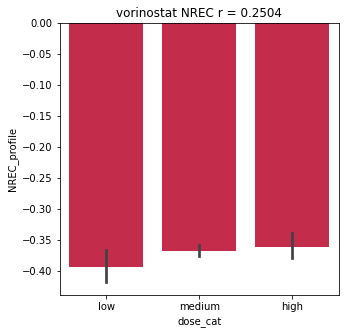

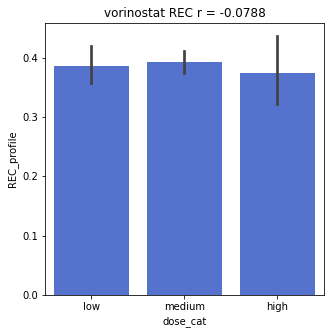

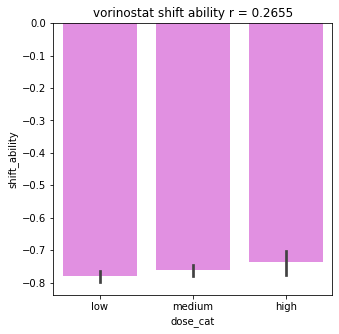

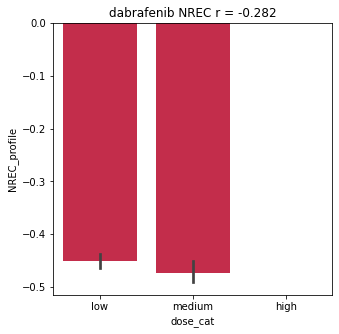

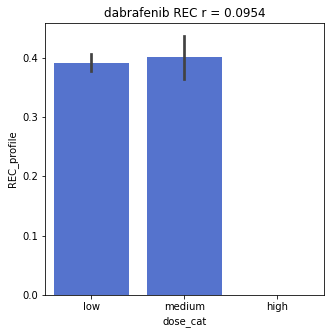

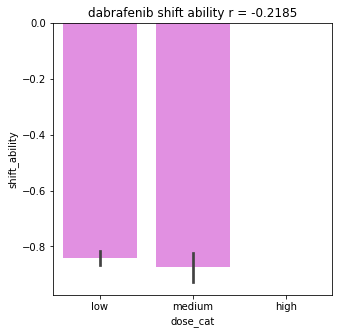

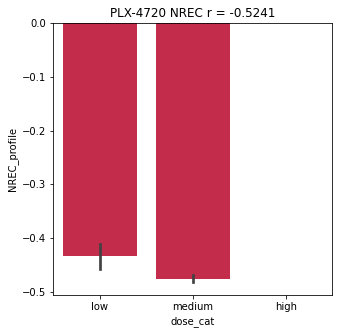

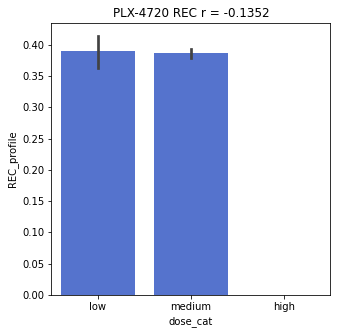

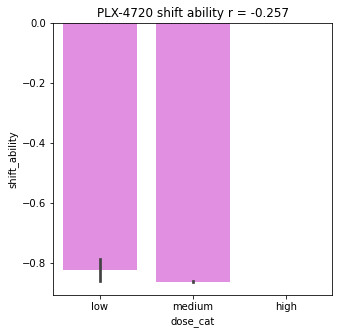

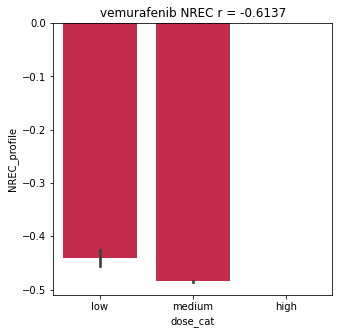

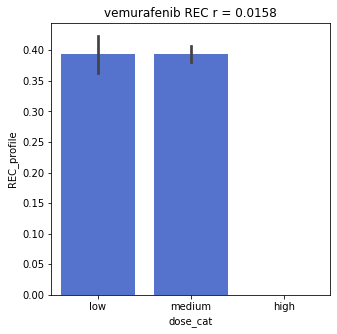

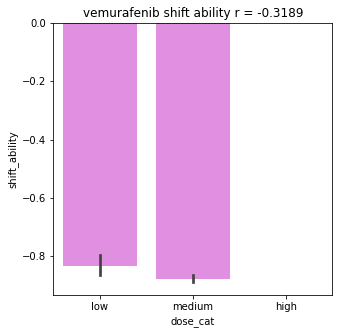

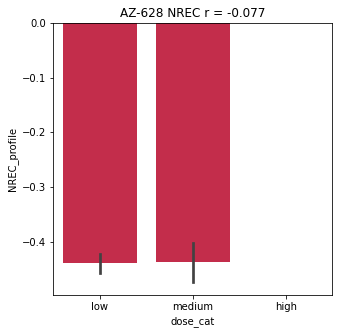

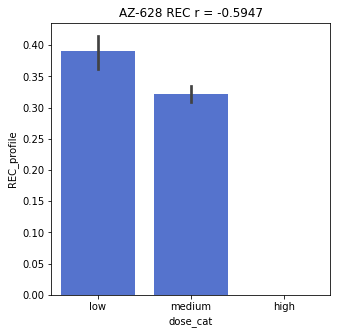

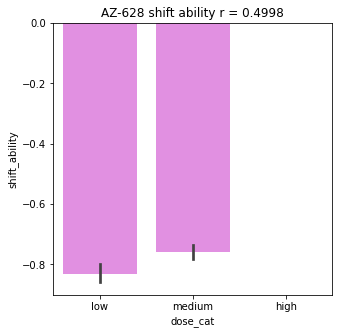

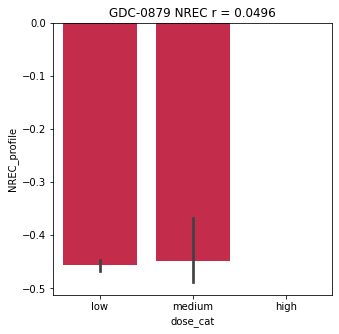

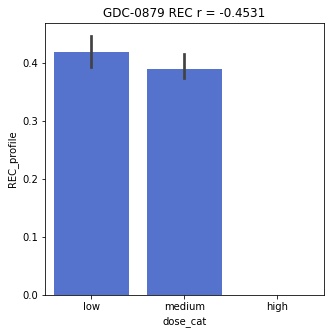

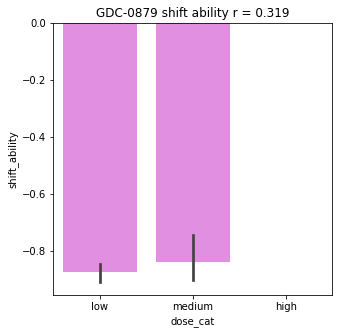

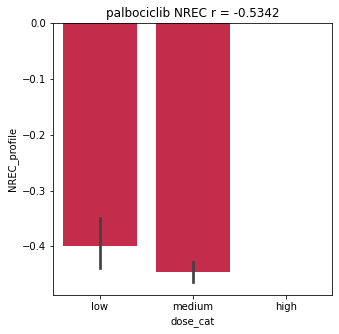

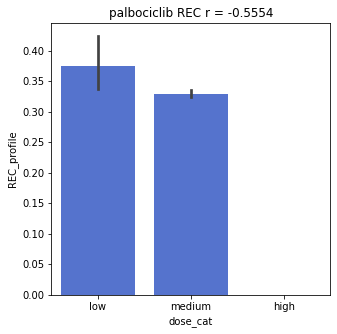

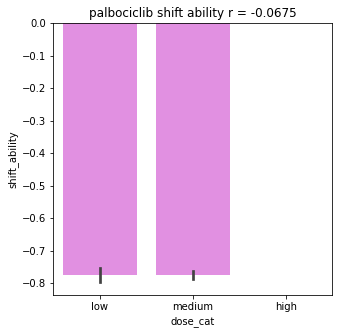

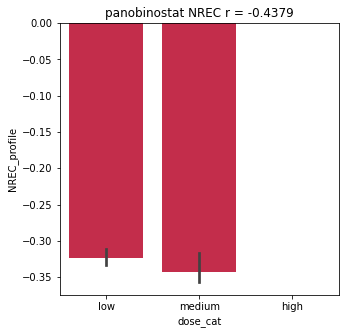

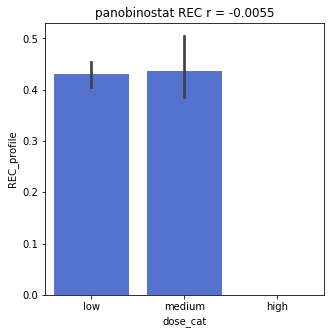

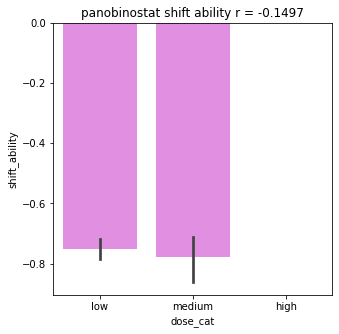

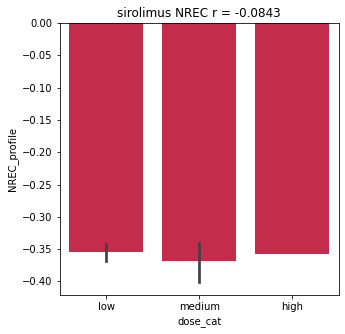

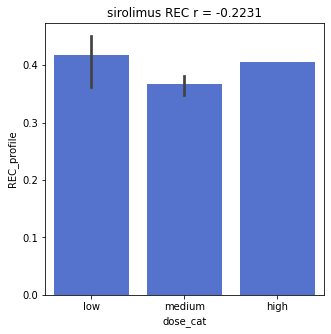

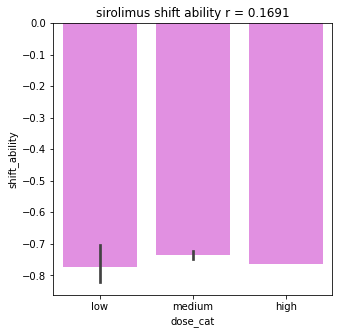

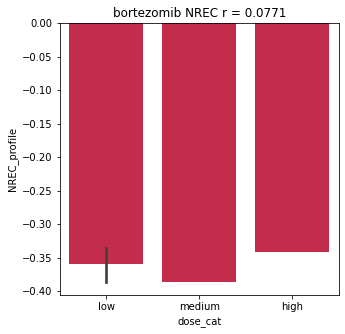

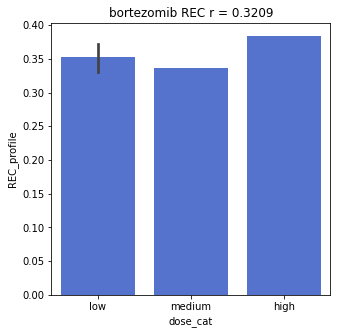

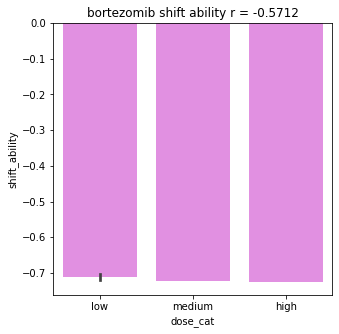

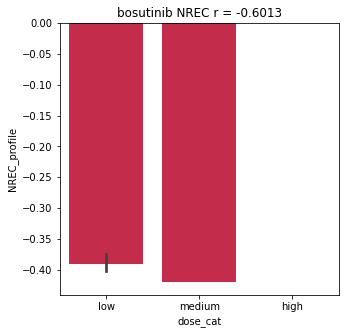

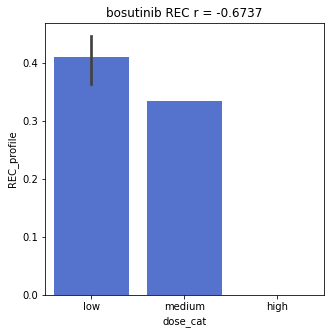

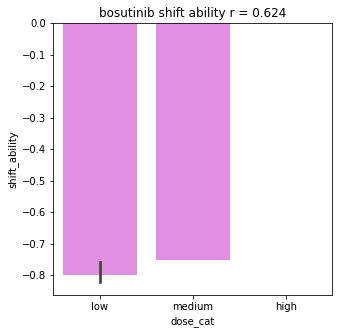

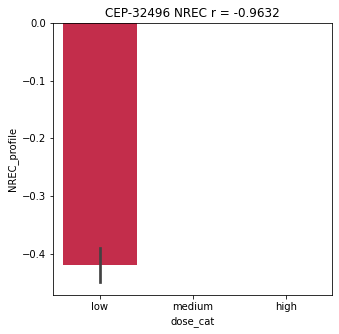

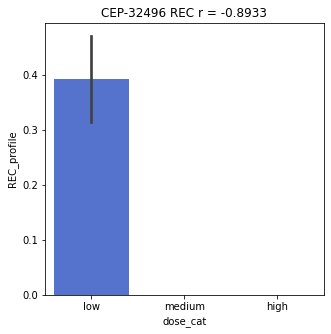

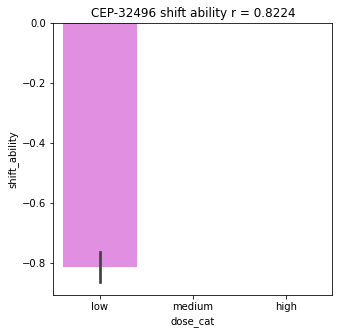

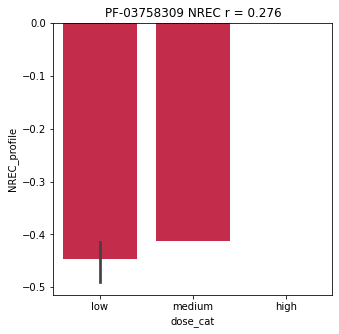

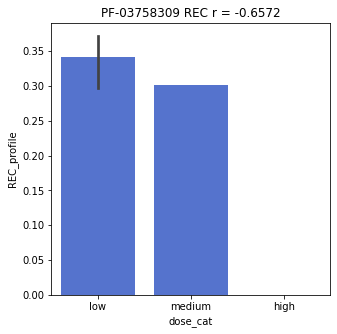

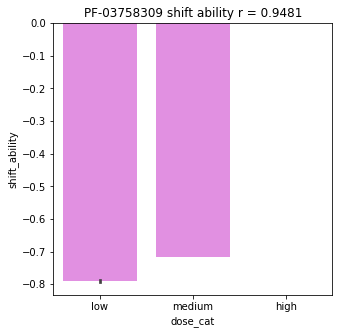

In [113]:
for d in hcs_multi:
    tmp_d = hcs_multi_sig[hcs_multi_sig['cmap_name'] == d]
    plt.figure(figsize=(5, 5))
    sns.barplot(x='dose_cat', y='NREC_profile', order=['low', 'medium', 'high'], data=tmp_d, color='crimson')
    plt.title(d + ' NREC r = ' + str(np.round(stats.pearsonr(tmp_d['dose'], tmp_d['NREC_profile'])[0], 4)))
    plt.show()
    
    plt.figure(figsize=(5, 5))
    sns.barplot(x='dose_cat', y='REC_profile', order=['low', 'medium', 'high'], data=tmp_d, color='royalblue')
    plt.title(d + ' REC r = ' + str(np.round(stats.pearsonr(tmp_d['dose'], tmp_d['REC_profile'])[0], 4)))
    plt.show()
    
    plt.figure(figsize=(5, 5))
    sns.barplot(x='dose_cat', y='shift_ability', order=['low', 'medium', 'high'], data=tmp_d, color='violet')
    plt.title(d + ' shift ability r = ' + str(np.round(stats.pearsonr(tmp_d['dose'], tmp_d['shift_ability'])[0], 4)))
    plt.show()

In [253]:
def stacked_bar(drug_hcs, fig_size, drug_name, sort_by='dose'):
    
    # ONLY SHOW THE A375
    drug_hcs = drug_hcs[drug_hcs['cell_line'] == 'A375']
    sns.set_theme(style="ticks")
    
    # Set up the matplotlib figure
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=fig_size, sharex=True)
    
    # sort by dosage then by shift ability
    s_dosage = sorted(drug_hcs['dose'].unique())
    s_shift = []
    
    if sort_by == 'dose':
        for d in s_dosage:
            tmp_d = drug_hcs[drug_hcs['dose'] == d]
            tmp_d = tmp_d.sort_values(by='shift_ability', ascending=True)
            s_shift.extend(tmp_d.index)
    elif sort_by == 'shift_ability':
        s_shift = drug_hcs.sort_values(by='shift_ability', ascending=True).index
    elif sort_by == 'REC':
        s_shift = drug_hcs.sort_values(by='REC_profile', ascending=False).index
    elif sort_by == 'NREC':
        s_shift = drug_hcs.sort_values(by='NREC_profile', ascending=True).index
    
    # visual
    sns.barplot(x=s_shift, y=drug_hcs.loc[s_shift, 'REC_profile'], palette=drug_hcs.loc[s_shift, 'dose_color'], ax=ax1)
    ax1.axhline(0, color="k", clip_on=False)
    ax1.set_ylabel("REC")
    
    sns.barplot(x=s_shift, y=drug_hcs.loc[s_shift, 'NREC_profile'], palette=drug_hcs.loc[s_shift, 'dose_color'], ax=ax2)
    ax2.axhline(0, color="k", clip_on=False)
    ax2.set_ylabel("NREC")
    
    sns.barplot(x=s_shift, y=drug_hcs.loc[s_shift, 'shift_ability'], color='plum', ax=ax3)
    ax3.axhline(0, color="k", clip_on=False)
    ax3.axhline(-0.7, color='k', clip_on=False, ls=':')
    ax3.set_ylabel("shift_ability")
    
    # Finalize the plot
    sns.despine(bottom=True)
    plt.setp(f.axes, xticks=[])
    plt.tight_layout(h_pad=1)
    ax1.set_title(drug_name + ' sorted by ' + sort_by)
    
    # plt.close()
    
    return


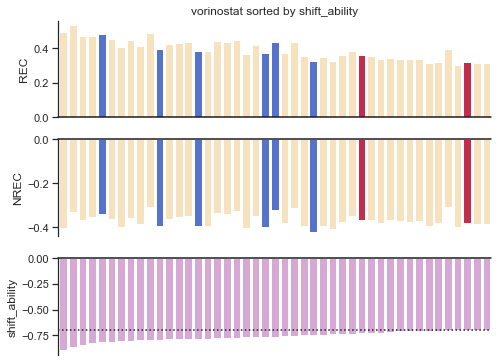

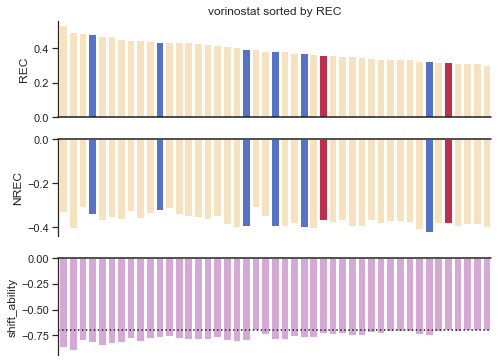

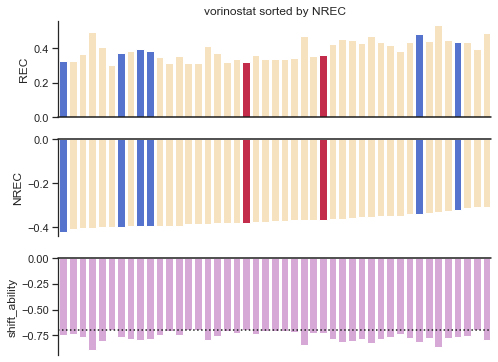

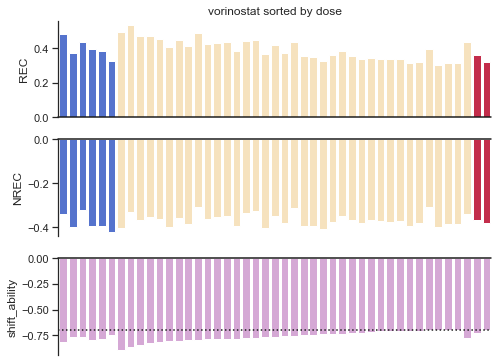

In [254]:
stacked_bar(drug_hcs=hcs_multi_sig[hcs_multi_sig['cmap_name'] == 'vorinostat'], fig_size=(7, 5), drug_name='vorinostat', sort_by='shift_ability')
stacked_bar(drug_hcs=hcs_multi_sig[hcs_multi_sig['cmap_name'] == 'vorinostat'], fig_size=(7, 5), drug_name='vorinostat', sort_by='REC')
stacked_bar(drug_hcs=hcs_multi_sig[hcs_multi_sig['cmap_name'] == 'vorinostat'], fig_size=(7, 5), drug_name='vorinostat', sort_by='NREC')
stacked_bar(drug_hcs=hcs_multi_sig[hcs_multi_sig['cmap_name'] == 'vorinostat'], fig_size=(7, 5), drug_name='vorinostat', sort_by='dose')

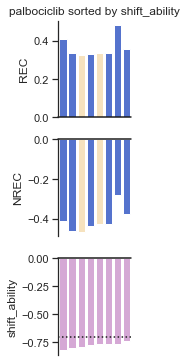

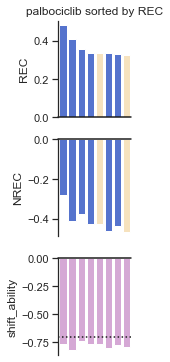

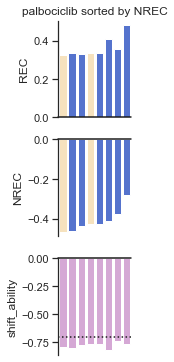

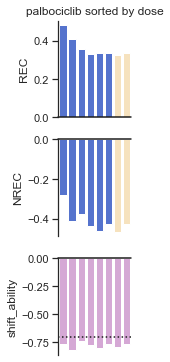

In [255]:
stacked_bar(drug_hcs=hcs_multi_sig[hcs_multi_sig['cmap_name'] == 'palbociclib'], fig_size=(2, 5), drug_name='palbociclib', sort_by='shift_ability')
stacked_bar(drug_hcs=hcs_multi_sig[hcs_multi_sig['cmap_name'] == 'palbociclib'], fig_size=(2, 5), drug_name='palbociclib', sort_by='REC')
stacked_bar(drug_hcs=hcs_multi_sig[hcs_multi_sig['cmap_name'] == 'palbociclib'], fig_size=(2, 5), drug_name='palbociclib', sort_by='NREC')
stacked_bar(drug_hcs=hcs_multi_sig[hcs_multi_sig['cmap_name'] == 'palbociclib'], fig_size=(2, 5), drug_name='palbociclib', sort_by='dose')

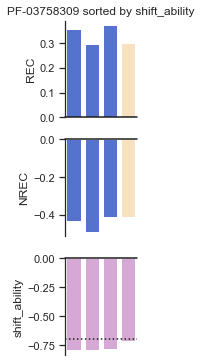

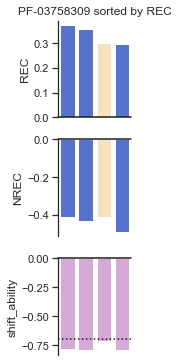

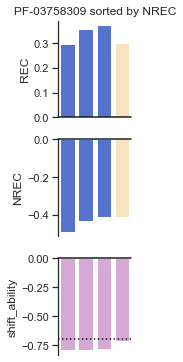

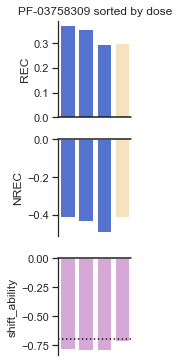

In [256]:
stacked_bar(drug_hcs=hcs_multi_sig[hcs_multi_sig['cmap_name'] == 'PF-03758309'], fig_size=(2, 5), drug_name='PF-03758309', sort_by='shift_ability')
stacked_bar(drug_hcs=hcs_multi_sig[hcs_multi_sig['cmap_name'] == 'PF-03758309'], fig_size=(2, 5), drug_name='PF-03758309', sort_by='REC')
stacked_bar(drug_hcs=hcs_multi_sig[hcs_multi_sig['cmap_name'] == 'PF-03758309'], fig_size=(2, 5), drug_name='PF-03758309', sort_by='NREC')
stacked_bar(drug_hcs=hcs_multi_sig[hcs_multi_sig['cmap_name'] == 'PF-03758309'], fig_size=(2, 5), drug_name='PF-03758309', sort_by='dose')

In [12]:
tmp_selected = ['LJP009_A375_24H:D02', 'REP.A014_A375_24H:K13', 'MOAR004_A375_24H:A18', 'MOAR004_A375_24H:A17']

In [39]:
skcm_trt_cp_original[tmp_selected].loc['']

LJP009_A375_24H:D02      1.311150
REP.A014_A375_24H:K13    1.022800
MOAR004_A375_24H:A18     1.331601
MOAR004_A375_24H:A17     1.453021
Name: BAG6, dtype: float64

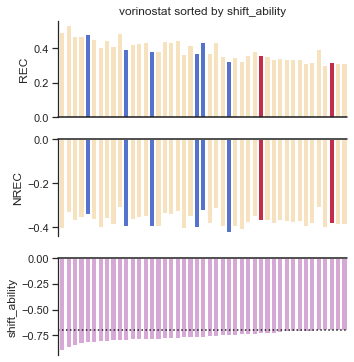

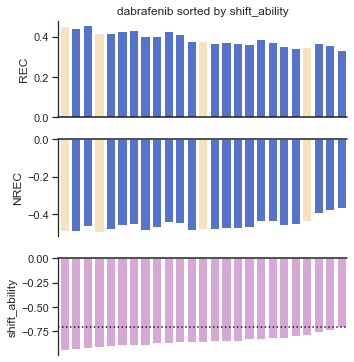

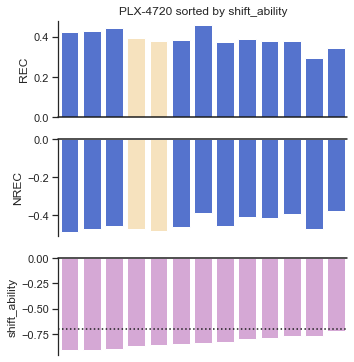

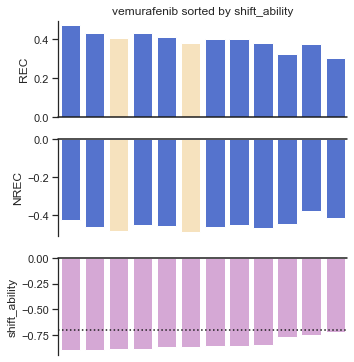

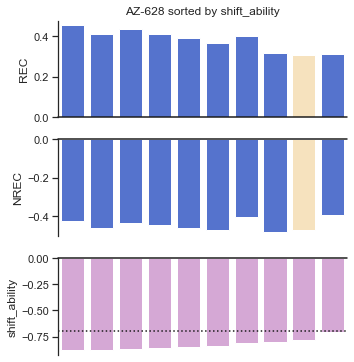

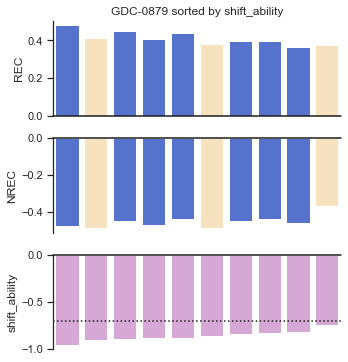

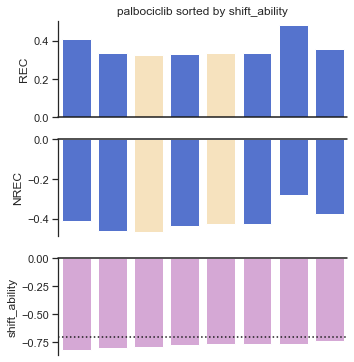

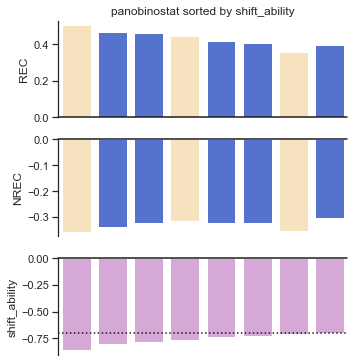

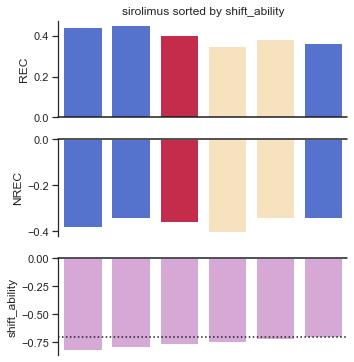

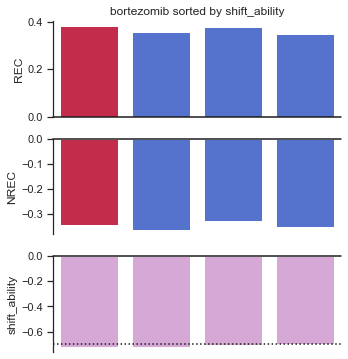

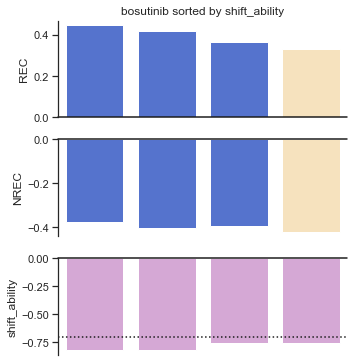

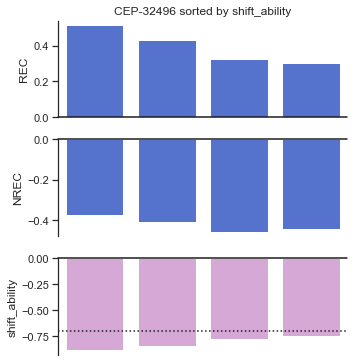

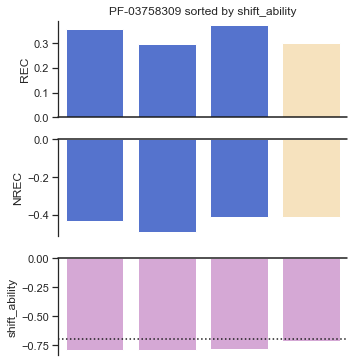

In [258]:
for d in hcs_multi:
    tmp_d = hcs_multi_sig[hcs_multi_sig['cmap_name'] == d]
    stacked_bar(drug_hcs=tmp_d, fig_size=(5, 5), drug_name=d, sort_by='shift_ability')

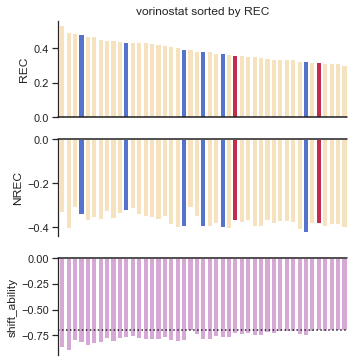

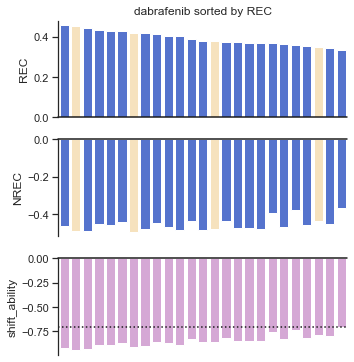

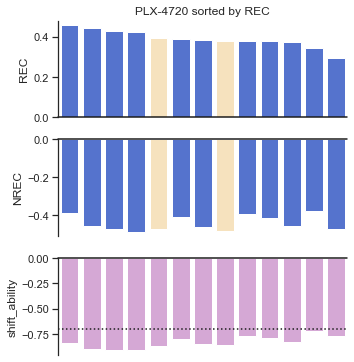

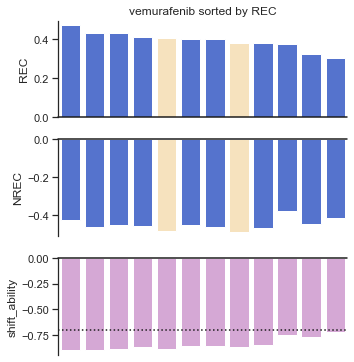

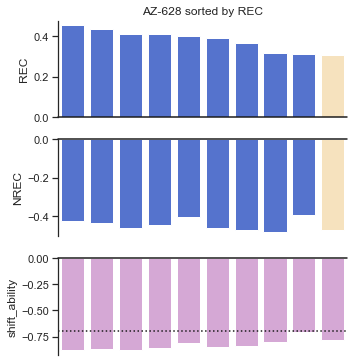

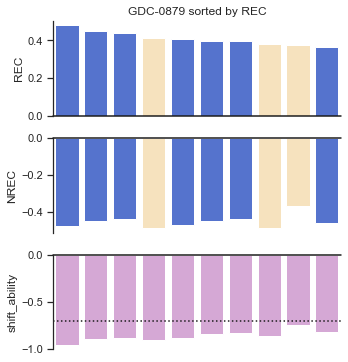

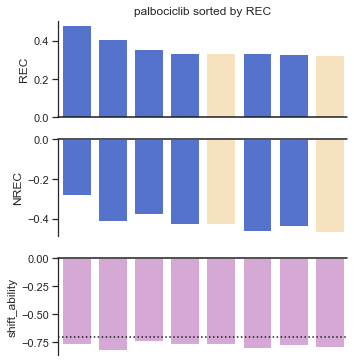

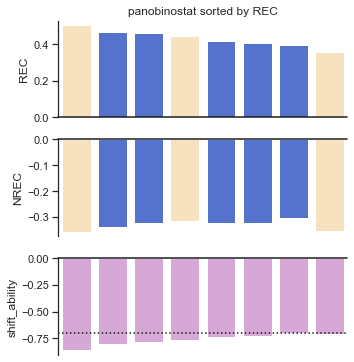

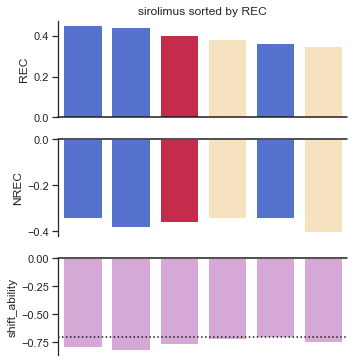

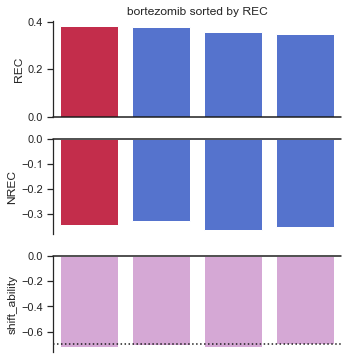

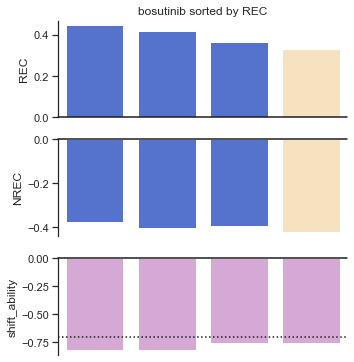

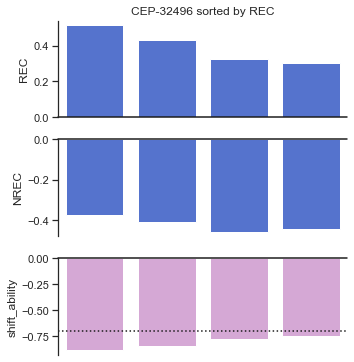

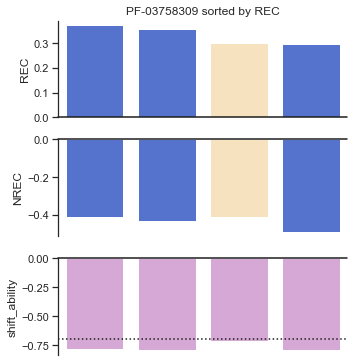

In [259]:
for d in hcs_multi:
    tmp_d = hcs_multi_sig[hcs_multi_sig['cmap_name'] == d]
    stacked_bar(drug_hcs=tmp_d, fig_size=(5, 5), drug_name=d, sort_by='REC')

(array([0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

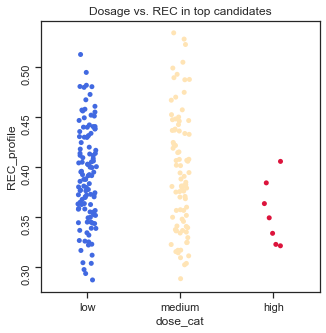

In [298]:
plt.figure(figsize=(5, 5))
sns.stripplot(x='dose_cat',
              y='REC_profile',
              data=hi_conf_sig, palette={'low': 'royalblue', 'medium': 'moccasin', 'high': 'crimson'})
plt.title('Dosage vs. REC in top candidates')
plt.yticks(rotation=90)

(array([-0.55, -0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

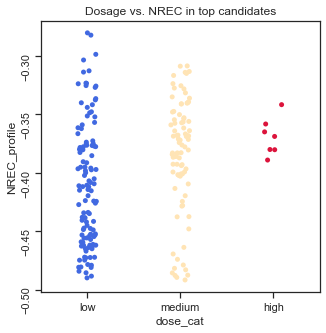

In [299]:
plt.figure(figsize=(5, 5))
sns.stripplot(x='dose_cat',
              y='NREC_profile',
              data=hi_conf_sig, palette={'low': 'royalblue', 'medium': 'moccasin', 'high': 'crimson'})
plt.title('Dosage vs. NREC in top candidates')
plt.yticks(rotation=90)

(array([-1.  , -0.95, -0.9 , -0.85, -0.8 , -0.75, -0.7 , -0.65]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

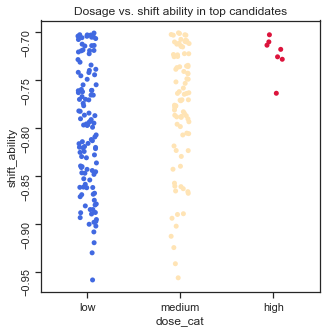

In [300]:
plt.figure(figsize=(5, 5))
sns.stripplot(x='dose_cat',
              y='shift_ability',
              data=hi_conf_sig, palette={'low': 'royalblue', 'medium': 'moccasin', 'high': 'crimson'})
plt.title('Dosage vs. shift ability in top candidates')
plt.yticks(rotation=90)

In [267]:
# see all the compounds
merged_es_compound['dose'] = skcm_sig_info['nearest_dose']
merged_es_compound['time'] = skcm_sig_info['pert_time']
merged_es_compound['cell_line'] = skcm_sig_info['cell_mfc_name']

merged_es_compound['dose_cat'] = ''
merged_es_compound.loc[merged_es_compound[merged_es_compound['dose'] < 10].index, 'dose_cat'] = 'low'
merged_es_compound.loc[merged_es_compound[merged_es_compound['dose'] >= 10].index, 'dose_cat'] = 'medium'
merged_es_compound.loc[merged_es_compound[merged_es_compound['dose'] >= 20].index, 'dose_cat'] = 'high'

merged_es_compound['dose_color'] = ''
merged_es_compound.loc[merged_es_compound[merged_es_compound['dose_cat'] == 'low'].index, 'dose_color'] = 'royalblue'
merged_es_compound.loc[merged_es_compound[merged_es_compound['dose_cat'] == 'medium'].index, 'dose_color'] = 'moccasin'
merged_es_compound.loc[merged_es_compound[merged_es_compound['dose_cat'] == 'high'].index, 'dose_color'] = 'crimson'

In [268]:
merged_es_compound.to_csv(data_home + 'shift_ability/merged_shift_compound.csv', sep=',')

In [305]:
sig_cand_compound

NREC_profile  REC_profile      cmap_name  \
PBIOA018_A375_24H:A24                   -0.503196     0.495135     trametinib   
PBIOA020_A375_24H:O07                   -0.408702     0.586724       brivanib   
REP.B021_A375_24H:E13                   -0.508522     0.481902        MEK-162   
REP.A023_A375_24H:O13                   -0.466255     0.512435     valrubicin   
REP.B017_A375_24H:I09                   -0.479966     0.484035     Ro-4987655   
...                                           ...          ...            ...   
REP.B019_A375_24H:L13                   -0.344476     0.356070      dasatinib   
REP.A010_A375_24H:E19                   -0.362728     0.337780       acivicin   
PCLB002_A375_24H:BRD-A19037878:10       -0.309860     0.390580  BRD-A19037878   
DOSVAL004_A375_24H:BRD-K81418486:10     -0.386596     0.313822     vorinostat   
LJP005_A375_24H:C22                     -0.320123     0.379995   mitoxantrone   

                                     shift_ability                      MOA  \
PBIOA018_A375_24H:A24                    -0.998331            MEK inhibitor   
PBIOA020_A375_24H:O07                    -0.995426           FGFR inhibitor   
REP.B021_A375_24H:E13                    -0.990424                     None   
REP.A023_A375_24H:O13                    -0.978690            DNA inhibitor   
REP.B017_A375_24H:I09                    -0.964002            MEK inhibitor   
...                                            ...                      ...   
REP.B019_A375_24H:L13                    -0.700546            KIT inhibitor   
REP.A010_A375_24H:E19                    -0.700508                     None   
PCLB002_A375_24H:BRD-A19037878:10        -0.700441                     None   
DOSVAL004_A375_24H:BRD-K81418486:10      -0.700418           HDAC inhibitor   
LJP005_A375_24H:C22                      -0.700118  Topoisomerase inhibitor   

                                     target  
PBIOA018_A375_24H:A24                MAP2K1  
PBIOA020_A375_24H:O07                 FGFR1  
REP.B021_A375_24H:E13                  None  
REP.A023_A375_24H:O13                 TOP2A  
REP.B017_A375_24H:I09                MAP2K1  
...                                     ...  
REP.B019_A375_24H:L13                 EPHA2  
REP.A010_A375_24H:E19                  None  
PCLB002_A375_24H:BRD-A19037878:10      None  
DOSVAL004_A375_24H:BRD-K81418486:10   HDAC6  
LJP005_A375_24H:C22                   TOP2A  

[1079 rows x 6 columns]

(array([0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

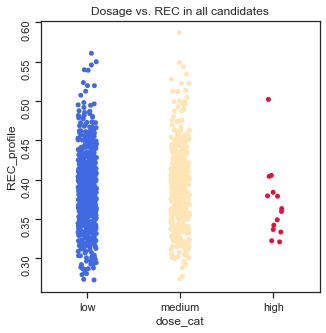

In [302]:
plt.figure(figsize=(5, 5))
sns.stripplot(x='dose_cat',
            y='REC_profile',
            data=merged_es_compound[merged_es_compound.index.isin(sig_cand_compound.index)],
            palette={'low': 'royalblue', 'medium': 'moccasin', 'high': 'crimson'})
plt.title('Dosage vs. REC in all candidates')
plt.yticks(rotation=90)

(array([-0.55, -0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

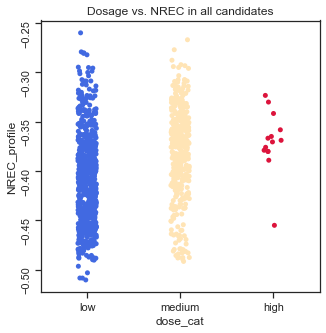

In [303]:
plt.figure(figsize=(5, 5))
sns.stripplot(x='dose_cat',
            y='NREC_profile',
            data=merged_es_compound[merged_es_compound.index.isin(sig_cand_compound.index)],
            palette={'low': 'royalblue', 'medium': 'moccasin', 'high': 'crimson'})
plt.title('Dosage vs. NREC in all candidates')
plt.yticks(rotation=90)

(array([-1.05, -1.  , -0.95, -0.9 , -0.85, -0.8 , -0.75, -0.7 , -0.65]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

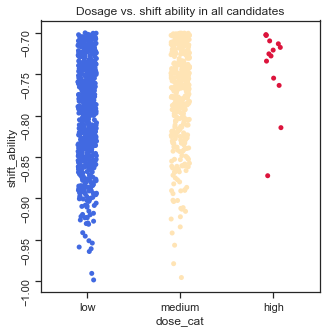

In [304]:
plt.figure(figsize=(5, 5))
sns.stripplot(x='dose_cat',
            y='shift_ability',
            data=merged_es_compound[merged_es_compound.index.isin(sig_cand_compound.index)],
            palette={'low': 'royalblue', 'medium': 'moccasin', 'high': 'crimson'})
plt.title('Dosage vs. shift ability in all candidates')
plt.yticks(rotation=90)

# shRNA KO efficiency

In [306]:
skcm_trt_sh_original

DER001_A375_96H:TRCN0000002228:-666  \
rid                                            
ADA                                -0.566717   
CDH2                                1.169272   
AKT3                                0.768465   
MED6                               -0.605836   
NAALAD2                            -1.227137   
...                                      ...   
CDH1                               -0.525155   
SLC12A6                            -1.987019   
PTBP3                               0.416464   
DGCR2                              -1.463126   
SCO2                               -0.286058   

         DER001_A375_96H:TRCN0000017935:-666  \
rid                                            
ADA                                 2.104741   
CDH2                               -1.243799   
AKT3                               -0.105477   
MED6                               -0.267907   
NAALAD2                            -0.167097   
...                                      ...   
CDH1                                1.216371   
SLC12A6                             0.897828   
PTBP3                               0.074376   
DGCR2                               1.382410   
SCO2                               -1.079701   

         DER001_A375_96H:TRCN0000027180:-666  \
rid                                            
ADA                                 1.406804   
CDH2                               -1.623604   
AKT3                               -1.361498   
MED6                               -0.438485   
NAALAD2                             1.044459   
...                                      ...   
CDH1                                0.615043   
SLC12A6                             1.165503   
PTBP3                               0.406570   
DGCR2                               1.598009   
SCO2                               -0.212422   

         DER001_A375_96H:TRCN0000049185:-666  \
rid                                            
ADA                                 1.668899   
CDH2                               -2.109041   
AKT3                                0.961013   
MED6                               -0.383155   
NAALAD2                             1.165002   
...                                      ...   
CDH1                                1.266677   
SLC12A6                             0.443870   
PTBP3                              -0.068093   
DGCR2                               2.013352   
SCO2                               -0.173328   

         DER001_A375_96H:TRCN0000051206:-666  \
rid                                            
ADA                                 0.344497   
CDH2                               -0.214287   
AKT3                               -0.151211   
MED6                               -0.419338   
NAALAD2                             0.935463   
...                                      ...   
CDH1                                2.033363   
SLC12A6                             0.590681   
PTBP3                               0.931665   
DGCR2                               0.796267   
SCO2                               -0.782787   

         DER001_A375_96H:TRCN0000052077:-666  \
rid                                            
ADA                                  0.97140   
CDH2                                -2.11750   
AKT3                                 0.49805   
MED6                                -0.59205   
NAALAD2                              0.44165   
...                                      ...   
CDH1                                 1.72465   
SLC12A6                              0.80205   
PTBP3                                0.28930   
DGCR2                                1.74960   
SCO2                                 1.30880   

         DER001_A375_96H:TRCN0000116501:-666  \
rid                                            
ADA                                 1.472784   
CDH2                               -0.984914   
AKT3                               -0.678886   
MED6               

In [307]:
prerank_shRNA_es_result

NREC_profile  REC_profile cmap_name  \
KDA002_A375_96H:H10                     -0.418181     0.418882      FBP1   
KDA002_A375_96H:TRCN0000050034:-666     -0.413904     0.395217      FBP1   
KDC004_A375_96H:TRCN0000007400:-666     -0.406783     0.349941   ARHGEF6   
KDB001_A375_96H:TRCN0000153171:-666     -0.404539     0.231638    TSPAN6   
KDB004_A375_96H:TRCN0000082833:-666     -0.401795     0.347834    COL4A5   
...                                           ...          ...       ...   
KDD006_A375_96H:TRCN0000006382:-666      0.351001    -0.327021      CRKL   
KDB002_A375_96H:TRCN0000183104:-666      0.354830    -0.221236    ZNF395   
TAK003_A375_96H:TRCN0000019413:-666      0.371441    -0.211632     STAT6   
KDD001_A375_96H:TRCN0000195313:-666      0.374614    -0.397508     MYLK2   
KDB005_A375_96H:TRCN0000072653:-666      0.385835    -0.224142    MRPL12   

                                     shift_ability  
KDA002_A375_96H:H10                      -0.837063  
KDA002_A375_96H:TRCN0000050034:-666      -0.809121  
KDC004_A375_96H:TRCN0000007400:-666      -0.756723  
KDB001_A375_96H:TRCN0000153171:-666      -0.636177  
KDB004_A375_96H:TRCN0000082833:-666      -0.749630  
...                                            ...  
KDD006_A375_96H:TRCN0000006382:-666       0.678023  
KDB002_A375_96H:TRCN0000183104:-666       0.576066  
TAK003_A375_96H:TRCN0000019413:-666       0.583072  
KDD001_A375_96H:TRCN0000195313:-666       0.772121  
KDB005_A375_96H:TRCN0000072653:-666       0.609977  

[2384 rows x 4 columns]

In [308]:
sh_target_avail = list(set(skcm_trt_sh_original.index) & set(prerank_shRNA_es_result['cmap_name']))

In [309]:
len(sh_target_avail)

1315

In [311]:
prerank_shRNA_es_result['cmap_name'].unique().shape

(1556,)

In [317]:
shRNA_ko_eff = df(columns=['skcm_sh_lv5', 'profile'])
for c in prerank_shRNA_es_result.index:
    tmp_g = prerank_shRNA_es_result.loc[c, 'cmap_name']
    if tmp_g in skcm_trt_sh_original.index:
        shRNA_ko_eff.at[c, 'skcm_sh_lv5'] = skcm_trt_sh_original.loc[tmp_g, c]
    if tmp_g in gene_NREC:
        shRNA_ko_eff.at[c, 'profile'] = 'NREC'
    elif tmp_g in gene_REC:
        shRNA_ko_eff.at[c, 'profile'] = 'REC'
    else:
        shRNA_ko_eff.at[c, 'profile'] = 'others'
shRNA_ko_eff['NREC'] = prerank_shRNA_es_result['NREC_profile']
shRNA_ko_eff['REC'] = prerank_shRNA_es_result['REC_profile']
shRNA_ko_eff['shift_ability'] = prerank_shRNA_es_result['shift_ability']
shRNA_ko_eff['cmap_name'] = prerank_shRNA_es_result['cmap_name']

In [318]:
shRNA_ko_eff = shRNA_ko_eff.sort_values(by='skcm_sh_lv5', ascending=True)

In [319]:
shRNA_ko_eff.to_csv(data_home + 'shift_ability/merged_shift_shRNA_with_ko_eff.csv', sep=',')

In [320]:
shRNA_ko_eff

skcm_sh_lv5 profile      NREC       REC  \
KDB008_A375_96H:TRCN0000017026:-666  -10.000001  others -0.288090  0.275485   
KDB001_A375_96H:TRCN0000343727:-666       -10.0  others -0.260085  0.229225   
KDB008_A375_96H:TRCN0000029128:-666       -10.0    NREC  0.188666 -0.203933   
KDB008_A375_96H:TRCN0000029126:-666       -10.0    NREC  0.246009 -0.381650   
KDB001_A375_96H:TRCN0000337192:-666       -10.0    NREC -0.335842  0.230388   
...                                         ...     ...       ...       ...   
KDD010_A375_96H:TRCN0000194791:-666         NaN  others  0.305883 -0.281471   
KDD008_A375_96H:TRCN0000006865:-666         NaN  others  0.309814 -0.181701   
KDD004_A375_96H:TRCN0000016717:-666         NaN  others  0.312797 -0.229444   
KDD002_A375_96H:TRCN0000005803:-666         NaN  others  0.320897 -0.298918   
KDD001_A375_96H:TRCN0000195313:-666         NaN  others  0.374614 -0.397508   

                                     shift_ability cmap_name  
KDB008_A375_96H:TRCN0000017026:-666      -0.563574    POLR2I  
KDB001_A375_96H:TRCN0000343727:-666      -0.489310    GTPBP8  
KDB008_A375_96H:TRCN0000029128:-666       0.392598     VDAC1  
KDB008_A375_96H:TRCN0000029126:-666       0.627659     VDAC1  
KDB001_A375_96H:TRCN0000337192:-666      -0.566230      RAE1  
...                                            ...       ...  
KDD010_A375_96H:TRCN0000194791:-666       0.587353    PI4K2B  
KDD008_A375_96H:TRCN0000006865:-666       0.491516   PPP2R2C  
KDD004_A375_96H:TRCN0000016717:-666       0.542241      LHX9  
KDD002_A375_96H:TRCN0000005803:-666       0.619815     IFNB1  
KDD001_A375_96H:TRCN0000195313:-666       0.772121     MYLK2  

[2384 rows x 6 columns]

In [327]:
shRNA_ko_eff_NREC = shRNA_ko_eff[shRNA_ko_eff['profile'] == 'NREC']
shRNA_ko_eff_NREC = shRNA_ko_eff_NREC.sort_values(by='NREC', ascending=True)
shRNA_ko_eff_REC = shRNA_ko_eff[shRNA_ko_eff['profile'] == 'REC']
shRNA_ko_eff_REC = shRNA_ko_eff_REC.sort_values(by='REC', ascending=True)

In [328]:
shRNA_ko_eff_NREC.shape

(336, 6)

In [329]:
shRNA_ko_eff_REC.shape

(42, 6)

<AxesSubplot:xlabel='NREC', ylabel='skcm_sh_lv5'>

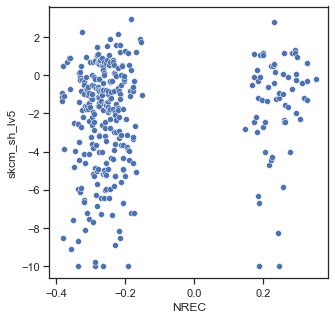

In [334]:
# NREC down vs. ko efficacy
plt.figure(figsize=(5, 5))
sns.scatterplot(x='NREC', y='skcm_sh_lv5', data=shRNA_ko_eff_NREC)

In [335]:
shRNA_ko_eff_NREC['direction'] = 'up'
shRNA_ko_eff_NREC.loc[shRNA_ko_eff_NREC[shRNA_ko_eff_NREC['NREC'] < 0].index, 'direction'] = 'down'

In [347]:
shRNA_ko_eff_NREC['ko_eff'] = 'high'
shRNA_ko_eff_NREC.loc[shRNA_ko_eff_NREC[shRNA_ko_eff_NREC['skcm_sh_lv5'] > -1].index, 'ko_eff'] = 'low'

<AxesSubplot:xlabel='direction', ylabel='skcm_sh_lv5'>

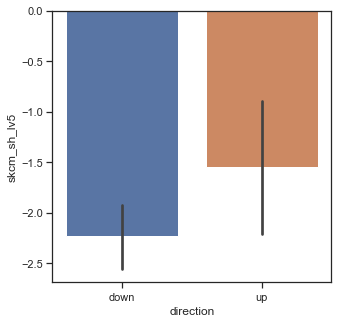

In [337]:
# NREC direction vs. ko efficacy
plt.figure(figsize=(5, 5))
sns.barplot(x='direction', y='skcm_sh_lv5', data=shRNA_ko_eff_NREC)

<AxesSubplot:xlabel='direction', ylabel='skcm_sh_lv5'>

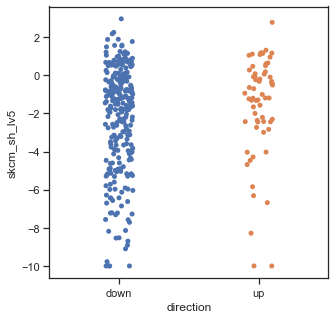

In [338]:
# NREC direction vs. ko efficacy
plt.figure(figsize=(5, 5))
sns.stripplot(x='direction', y='skcm_sh_lv5', data=shRNA_ko_eff_NREC)

In [339]:
stats.ttest_ind(shRNA_ko_eff_NREC[shRNA_ko_eff_NREC['NREC'] < 0]['skcm_sh_lv5'], shRNA_ko_eff_NREC[shRNA_ko_eff_NREC['NREC'] > 0]['skcm_sh_lv5'])

Ttest_indResult(statistic=-1.779280127725811, pvalue=0.07610314276796633)

<AxesSubplot:xlabel='skcm_sh_lv5', ylabel='Density'>

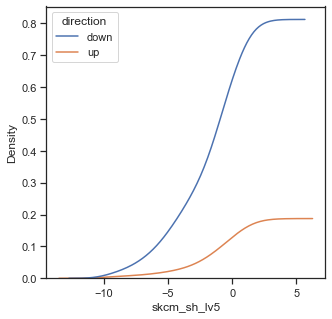

In [346]:
# NREC direction vs. ko efficacy
plt.figure(figsize=(5, 5))
sns.kdeplot(x='skcm_sh_lv5', hue='direction', cumulative=True, data=shRNA_ko_eff_NREC)

# from hi-conf target to others

In [72]:
sig_cand_shRNA = prerank_shRNA_es_result[prerank_shRNA_es_result['shift_ability'] <= -.5]

In [73]:
sig_cand_shRNA

NREC_profile  REC_profile  cmap_name  \
KDA002_A375_96H:H10                     -0.418181     0.418882       FBP1   
KDA002_A375_96H:TRCN0000050034:-666     -0.413904     0.395217       FBP1   
KDC004_A375_96H:TRCN0000007400:-666     -0.406783     0.349941    ARHGEF6   
KDB001_A375_96H:TRCN0000153171:-666     -0.404539     0.231638     TSPAN6   
KDB004_A375_96H:TRCN0000082833:-666     -0.401795     0.347834     COL4A5   
...                                           ...          ...        ...   
KDB003_A375_96H:TRCN0000280857:-666     -0.176600     0.346630    TPD52L2   
KDB009_A375_96H:TRCN0000005701:-666     -0.174004     0.356341       RFX5   
KDB010_A375_96H:TRCN0000349638:-666     -0.163294     0.421356      HDAC1   
KDB002_A375_96H:TRCN0000106721:-666     -0.160858     0.371667  HIST2H2BE   
KDA002_A375_96H:TRCN0000000607:-666     -0.151267     0.361468    CSNK2A1   

                                     shift_ability  
KDA002_A375_96H:H10                      -0.837063  
KDA002_A375_96H:TRCN0000050034:-666      -0.809121  
KDC004_A375_96H:TRCN0000007400:-666      -0.756723  
KDB001_A375_96H:TRCN0000153171:-666      -0.636177  
KDB004_A375_96H:TRCN0000082833:-666      -0.749630  
...                                            ...  
KDB003_A375_96H:TRCN0000280857:-666      -0.523230  
KDB009_A375_96H:TRCN0000005701:-666      -0.530345  
KDB010_A375_96H:TRCN0000349638:-666      -0.584650  
KDB002_A375_96H:TRCN0000106721:-666      -0.532525  
KDA002_A375_96H:TRCN0000000607:-666      -0.512735  

[1054 rows x 4 columns]

In [71]:
sig_cand_compound

NREC_profile  REC_profile    cmap_name  shift_ability  \
PBIOA018_A375_24H:A23     -0.510429     0.368917   trametinib      -0.879347   
REP.B021_A375_24H:E13     -0.508522     0.481902      MEK-162      -0.990424   
REP.A019_A375_24H:M23     -0.508466     0.379047   PD-0325901      -0.887513   
PBIOA018_A375_24H:A24     -0.503196     0.495135   trametinib      -0.998331   
EMU001_SKMEL5_24H:G20     -0.496531     0.400384    auranofin      -0.896915   
...                             ...          ...          ...            ...   
MOAR019_A375_24H:K23      -0.280123     0.480439  palbociclib      -0.760562   
REP.A011_A375_24H:H24     -0.279110     0.439725  rilpivirine      -0.718836   
MOAR003_A375_24H:C16      -0.276955     0.425692       CC-930      -0.702647   
CPC014_A375_6H:J02        -0.266825     0.439901     HC-toxin      -0.706727   
REP.B019_A375_24H:A07     -0.259819     0.486900    taselisib      -0.746719   

                                  MOA  target  
PBIOA018_A375_24H:A23   MEK inhibitor  MAP2K1  
REP.B021_A375_24H:E13             NaN     NaN  
REP.A019_A375_24H:M23   MEK inhibitor  MAP2K1  
PBIOA018_A375_24H:A24   MEK inhibitor  MAP2K1  
EMU001_SKMEL5_24H:G20             NaN     NaN  
...                               ...     ...  
MOAR019_A375_24H:K23    CDK inhibitor    CDK4  
REP.A011_A375_24H:H24             NaN     NaN  
MOAR003_A375_24H:C16              NaN     NaN  
CPC014_A375_6H:J02                NaN     NaN  
REP.B019_A375_24H:A07  PI3K inhibitor  PIK3CA  

[1079 rows x 6 columns]

In [92]:
sig_cand_compound['dose'] = skcm_sig_info['nearest_dose']

<ipython-input-92-cc29cc211b74>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_cand_compound['dose'] = skcm_sig_info['nearest_dose']


In [93]:
sig_cand_compound

NREC_profile  REC_profile    cmap_name  shift_ability  \
PBIOA018_A375_24H:A23     -0.510429     0.368917   trametinib      -0.879347   
REP.B021_A375_24H:E13     -0.508522     0.481902      MEK-162      -0.990424   
REP.A019_A375_24H:M23     -0.508466     0.379047   PD-0325901      -0.887513   
PBIOA018_A375_24H:A24     -0.503196     0.495135   trametinib      -0.998331   
EMU001_SKMEL5_24H:G20     -0.496531     0.400384    auranofin      -0.896915   
...                             ...          ...          ...            ...   
MOAR019_A375_24H:K23      -0.280123     0.480439  palbociclib      -0.760562   
REP.A011_A375_24H:H24     -0.279110     0.439725  rilpivirine      -0.718836   
MOAR003_A375_24H:C16      -0.276955     0.425692       CC-930      -0.702647   
CPC014_A375_6H:J02        -0.266825     0.439901     HC-toxin      -0.706727   
REP.B019_A375_24H:A07     -0.259819     0.486900    taselisib      -0.746719   

                                  MOA  target    dose  
PBIOA018_A375_24H:A23   MEK inhibitor  MAP2K1   0.125  
REP.B021_A375_24H:E13             NaN     NaN   2.220  
REP.A019_A375_24H:M23   MEK inhibitor  MAP2K1   0.125  
PBIOA018_A375_24H:A24   MEK inhibitor  MAP2K1   0.040  
EMU001_SKMEL5_24H:G20             NaN     NaN   2.500  
...                               ...     ...     ...  
MOAR019_A375_24H:K23    CDK inhibitor    CDK4   0.660  
REP.A011_A375_24H:H24             NaN     NaN   0.040  
MOAR003_A375_24H:C16              NaN     NaN  10.000  
CPC014_A375_6H:J02                NaN     NaN  10.000  
REP.B019_A375_24H:A07  PI3K inhibitor  PIK3CA   2.220  

[1079 rows x 7 columns]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 [Text(0, 0, '0.01'),
  Text(1, 0, '0.03'),
  Text(2, 0, '0.04'),
  Text(3, 0, '0.08'),
  Text(4, 0, '0.12'),
  Text(5, 0, '0.125'),
  Text(6, 0, '0.25'),
  Text(7, 0, '0.37'),
  Text(8, 0, '0.5'),
  Text(9, 0, '0.66'),
  Text(10, 0, '0.74'),
  Text(11, 0, '1.11'),
  Text(12, 0, '1.25'),
  Text(13, 0, '2.22'),
  Text(14, 0, '2.5'),
  Text(15, 0, '3.33'),
  Text(16, 0, '4.0'),
  Text(17, 0, '10.0'),
  Text(18, 0, '12.0'),
  Text(19, 0, '20.0'),
  Text(20, 0, '60.0'),
  Text(21, 0, '80.0')])

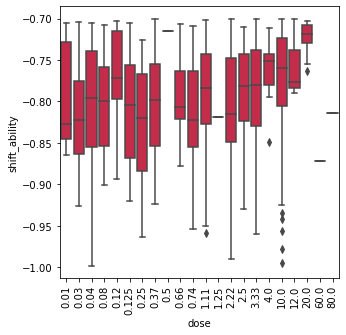

In [94]:
# dose vs. shift
plt.figure(figsize=(5, 5))
sns.boxplot(y='shift_ability', x='dose', data=sig_cand_compound, color='crimson')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 [Text(0, 0, '0.01'),
  Text(1, 0, '0.03'),
  Text(2, 0, '0.04'),
  Text(3, 0, '0.08'),
  Text(4, 0, '0.12'),
  Text(5, 0, '0.125'),
  Text(6, 0, '0.25'),
  Text(7, 0, '0.37'),
  Text(8, 0, '0.5'),
  Text(9, 0, '0.66'),
  Text(10, 0, '0.74'),
  Text(11, 0, '1.11'),
  Text(12, 0, '1.25'),
  Text(13, 0, '2.22'),
  Text(14, 0, '2.5'),
  Text(15, 0, '3.33'),
  Text(16, 0, '4.0'),
  Text(17, 0, '10.0'),
  Text(18, 0, '12.0'),
  Text(19, 0, '20.0'),
  Text(20, 0, '60.0'),
  Text(21, 0, '80.0')])

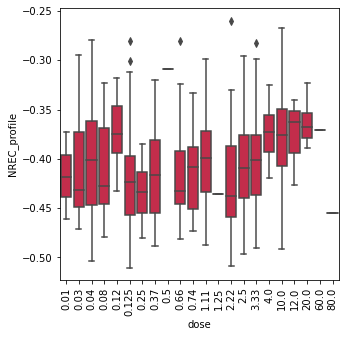

In [95]:
# dose vs. NREC
plt.figure(figsize=(5, 5))
sns.boxplot(y='NREC_profile', x='dose', data=sig_cand_compound, color='crimson')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 [Text(0, 0, '0.01'),
  Text(1, 0, '0.03'),
  Text(2, 0, '0.04'),
  Text(3, 0, '0.08'),
  Text(4, 0, '0.12'),
  Text(5, 0, '0.125'),
  Text(6, 0, '0.25'),
  Text(7, 0, '0.37'),
  Text(8, 0, '0.5'),
  Text(9, 0, '0.66'),
  Text(10, 0, '0.74'),
  Text(11, 0, '1.11'),
  Text(12, 0, '1.25'),
  Text(13, 0, '2.22'),
  Text(14, 0, '2.5'),
  Text(15, 0, '3.33'),
  Text(16, 0, '4.0'),
  Text(17, 0, '10.0'),
  Text(18, 0, '12.0'),
  Text(19, 0, '20.0'),
  Text(20, 0, '60.0'),
  Text(21, 0, '80.0')])

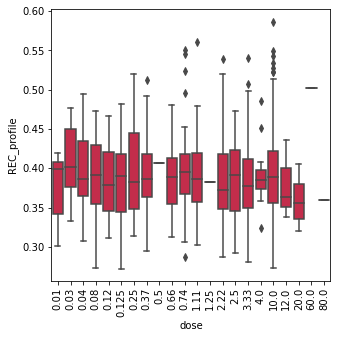

In [96]:
# dose vs. REC
plt.figure(figsize=(5, 5))
sns.boxplot(y='REC_profile', x='dose', data=sig_cand_compound, color='crimson')
plt.xticks(rotation=90)

In [98]:
sig_cand_compound_expr = skcm_trt_cp_original[sig_cand_compound.index]

In [99]:
sig_cand_compound_expr

PBIOA018_A375_24H:A23  REP.B021_A375_24H:E13  REP.A019_A375_24H:M23  \
rid                                                                            
ADA                   0.230806                0.87815               1.516174   
CDH2                 -1.105715               -1.00025               0.671625   
AKT3                 -0.691025               -0.68705              -0.886327   
MED6                 -2.288394               -1.66810              -0.293443   
NAALAD2               2.452553                1.92015               0.089581   
...                        ...                    ...                    ...   
CDH1                 -0.702978               -0.32275               0.284755   
SLC12A6               3.149958                1.45805               2.896537   
PTBP3                -0.373771               -3.12625              -2.930703   
DGCR2                 0.942952                1.40700               2.480220   
SCO2                  0.521024               -0.29095               1.358981   

         PBIOA018_A375_24H:A24  EMU001_SKMEL5_24H:G20  \
rid                                                     
ADA                  -0.031784               0.561761   
CDH2                 -0.559653              -0.465514   
AKT3                 -1.467091              -1.258769   
MED6                 -1.594695               0.620227   
NAALAD2               1.930852              -2.344449   
...                        ...                    ...   
CDH1                  0.067558              -2.343836   
SLC12A6               1.582896               1.853208   
PTBP3                -2.040849              -1.174311   
DGCR2                 0.787879              -0.204857   
SCO2                  0.801816               0.511289   

         BRAF001_A375_24H:BRD-K09951645-001-02-7:10  REP.A019_A375_24H:M20  \
rid                                                                          
ADA                                        0.689183               1.035144   
CDH2                                      -1.054533               0.446946   
AKT3                                      -1.385252              -0.650083   
MED6                                      -1.042514               0.193608   
NAALAD2                                    0.990989               0.863530   
...                                             ...                    ...   
CDH1                                       1.988259               0.805418   
SLC12A6                                    1.961031               1.035466   
PTBP3                                     -1.638786              -2.281637   
DGCR2                                      0.695442               1.765785   
SCO2                                       0.448757               1.195812   

         MOAR004_A375_24H:A17  REP.A005_A375_24H:I19  REP.A008_A375_24H:P04  \
rid                                                                           
ADA                  0.248768               0.875242               1.563784   
CDH2                -0.504496              -0.170390               0.546140   
AKT3                 0.716255              -1.616389              -0.641648   
MED6                -1.040782               0.247992              -0.312099   
NAALAD2             -0.682453              -0.470661               0.739019   
...                       ...                    ...                    ...   
CDH1                 0.223128               0.020150               0.414347   
SLC12A6              0.818127               1.699181               1.698368   
PTBP3               -0.208125              -0.809624              -1.697617   
DGCR2               -0.805299               2.281124               2.803721   
SCO2                -0.002776               1.407414               1.584623   

         ...  MOAR001_A375_24H:I13  CPC004_A375_6H:BRD-A29426959-050-07-4:10  \
rid      ...                                                                   
ADA      ...           

In [105]:
# dimensional reduction
pca_sigcand = PCA(n_components=10).fit_transform(sig_cand_compound_expr.T)
tsne_sigcand = TSNE(n_components=2).fit_transform(pca_sigcand)

In [107]:
# assign coordinates
tsne_sig_cand_coord = df(index=sig_cand_compound_expr.columns, columns=['TSNE1', 'TSNE2'])
for i in range(len(tsne_sigcand)):
    tsne_sig_cand_coord.at[sig_cand_compound_expr.columns[i], 'TSNE1'] = tsne_sigcand[i][0]
    tsne_sig_cand_coord.at[sig_cand_compound_expr.columns[i], 'TSNE2'] = tsne_sigcand[i][1]

<AxesSubplot:xlabel='TSNE1', ylabel='TSNE2'>

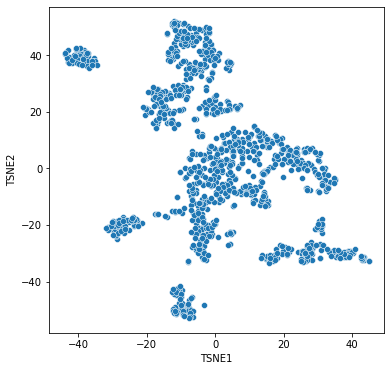

In [109]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', data=tsne_sig_cand_coord)

In [113]:
# add labels: hi-conf, moa
tsne_sig_cand_coord['hi-conf'] = 'No'
tsne_sig_cand_coord.loc[hi_conf_sig.index, 'hi-conf'] = 'Yes'

tsne_sig_cand_coord['moa'] = sig_cand_compound['MOA']

In [118]:
tsne_sig_cand_coord.value_counts('hi-conf')

hi-conf
No     866
Yes    213
dtype: int64

<AxesSubplot:xlabel='TSNE1', ylabel='TSNE2'>

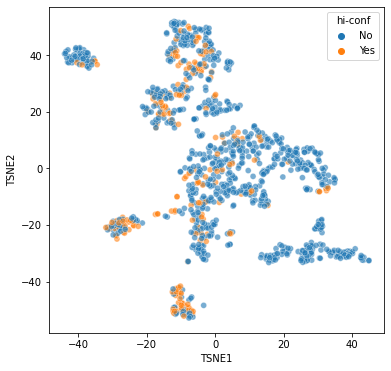

In [116]:
# color by hi-conf
plt.figure(figsize=(6, 6))
sns.scatterplot(x='TSNE1', y='TSNE2',
                alpha=0.6,
                hue='hi-conf', data=tsne_sig_cand_coord)

In [171]:
tsne_sig_cand_coord['shift_ability'] = sig_cand_compound['shift_ability']
tsne_sig_cand_coord['NREC'] = sig_cand_compound['NREC_profile']
tsne_sig_cand_coord['REC'] = sig_cand_compound['REC_profile']

<AxesSubplot:xlabel='TSNE1', ylabel='TSNE2'>

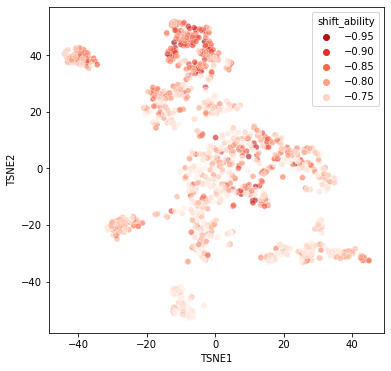

In [170]:
# color by sa
plt.figure(figsize=(6, 6))
sns.scatterplot(x='TSNE1', y='TSNE2',
                alpha=0.6,
                hue='shift_ability', data=tsne_sig_cand_coord, palette='Reds_r')

<AxesSubplot:xlabel='TSNE1', ylabel='TSNE2'>

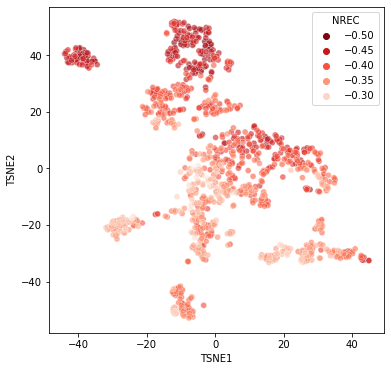

In [173]:
# color by NREC
plt.figure(figsize=(6, 6))
sns.scatterplot(x='TSNE1', y='TSNE2',
                alpha=0.6,
                hue='NREC', data=tsne_sig_cand_coord, palette='Reds_r')

<AxesSubplot:xlabel='TSNE1', ylabel='TSNE2'>

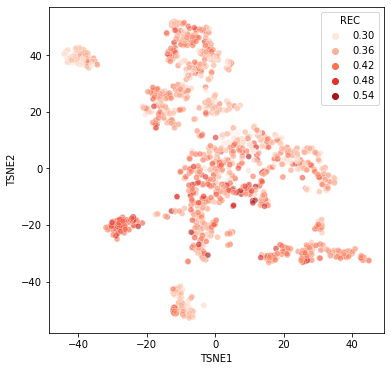

In [174]:
# color by REC
plt.figure(figsize=(6, 6))
sns.scatterplot(x='TSNE1', y='TSNE2',
                alpha=0.6,
                hue='REC', data=tsne_sig_cand_coord, palette='Reds')

In [162]:
def run_DBSCAN(coordinates, eps, min_samples):
    # scaled to [0, 1]
    coordinates_scaled = df(columns=['TSNE1', 'TSNE2'])
    coordinates_scaled['TSNE1'] = (coordinates['TSNE1'] - coordinates['TSNE1'].min()) / (coordinates['TSNE1'].max() - coordinates['TSNE1'].min())
    coordinates_scaled['TSNE2'] = (coordinates['TSNE2'] - coordinates['TSNE2'].min()) / (coordinates['TSNE2'].max() - coordinates['TSNE2'].min())

    # input hyperparameter
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coordinates_scaled)

    # initial assign
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    label_cell = df(index=coordinates.index, columns=['cluster'])
    label_cell['cluster'] = labels
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    
    # visualize
    # plt.subplots(figsize=(8, 8))
    # plt.scatter(coordinates_scaled['TSNE1'], coordinates_scaled['TSNE2'], c=label_cell['cluster'], s=20, linewidths=0, cmap='Dark2')
    # plt.title('Estimated number of clusters: %d' % n_clusters_)
    
    sil_score = metrics.silhouette_score(coordinates_scaled, labels)
    # print("Silhouette Coefficient: %0.3f"
    #       % sil_score)
    
    return label_cell, sil_score


def visual_DBSCAN(coordinates, eps, min_samples):
    # scaled to [0, 1]
    coordinates_scaled = df(columns=['TSNE1', 'TSNE2'])
    coordinates_scaled['TSNE1'] = (coordinates['TSNE1'] - coordinates['TSNE1'].min()) / (coordinates['TSNE1'].max() - coordinates['TSNE1'].min())
    coordinates_scaled['TSNE2'] = (coordinates['TSNE2'] - coordinates['TSNE2'].min()) / (coordinates['TSNE2'].max() - coordinates['TSNE2'].min())

    # input hyperparameter
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coordinates_scaled)

    # initial assign
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    label_cell = df(index=coordinates.index, columns=['cluster'])
    label_cell['cluster'] = labels
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    
    # visualize
    plt.subplots(figsize=(8, 8))
    plt.scatter(coordinates_scaled['TSNE1'], coordinates_scaled['TSNE2'], c=label_cell['cluster'], s=20, linewidths=0, cmap='Dark2')
    plt.title('Estimated number of clusters: %d' % n_clusters_)
    
    sil_score = metrics.silhouette_score(coordinates_scaled, labels)
    print("Silhouette Coefficient: %0.3f"
           % sil_score)
    
    return label_cell, sil_score

In [156]:
# parameter optimization
dbscan_para = df(columns=['eps', 'min_samples', 'sil_score'])
eps_ini = 0.04
eps_max = 0.07
ms_ini = 5
ms_max = 20
run = 0
while eps_ini < eps_max:
    while ms_ini < ms_max:
        dbscan_para.at[run, 'eps'] = eps_ini
        dbscan_para.at[run, 'min_samples'] = ms_ini
        dbscan_para.at[run, 'sil_score'] = run_DBSCAN(tsne_sig_cand_coord, eps=eps_ini, min_samples=ms_ini)[1]
        ms_ini += 1
        run += 1
    ms_ini = 5
    eps_ini += 0.001

In [161]:
dbscan_para.sort_values(by='sil_score', ascending=False)[:20]

eps min_samples sil_score
313   0.06          18  0.464248
359  0.063          19  0.464248
311   0.06          16  0.464248
312   0.06          17  0.464248
344  0.062          19  0.464248
343  0.062          18  0.464248
342  0.062          17  0.464248
326  0.061          16  0.464248
327  0.061          17  0.464248
328  0.061          18  0.464248
329  0.061          19  0.464248
186  0.052          11  0.463308
202  0.053          12  0.463308
217  0.054          12  0.463308
216  0.054          11  0.463308
201  0.053          11  0.463308
310   0.06          15  0.463154
233  0.055          13  0.462697
248  0.056          13  0.462697
230  0.055          10  0.462697

Silhouette Coefficient: 0.464


(                       cluster
 PBIOA018_A375_24H:A23        0
 REP.B021_A375_24H:E13        0
 REP.A019_A375_24H:M23        1
 PBIOA018_A375_24H:A24        0
 EMU001_SKMEL5_24H:G20        0
 ...                        ...
 MOAR019_A375_24H:K23         2
 REP.A011_A375_24H:H24        2
 MOAR003_A375_24H:C16         2
 CPC014_A375_6H:J02           5
 REP.B019_A375_24H:A07        2
 
 [1079 rows x 1 columns],
 0.46424849574260496)

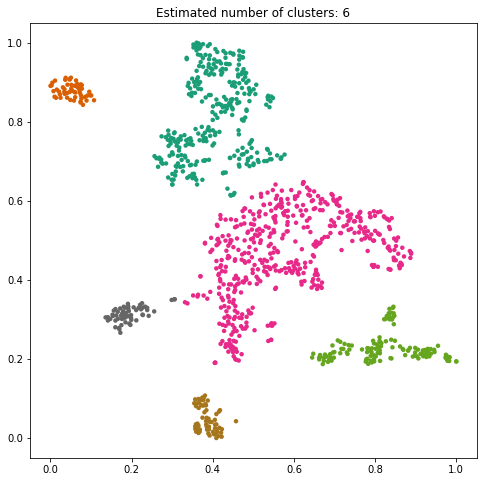

In [163]:
visual_DBSCAN(tsne_sig_cand_coord, eps=0.06, min_samples=18)

Silhouette Coefficient: 0.463


(                       cluster
 PBIOA018_A375_24H:A23        0
 REP.B021_A375_24H:E13        0
 REP.A019_A375_24H:M23        1
 PBIOA018_A375_24H:A24        0
 EMU001_SKMEL5_24H:G20        2
 ...                        ...
 MOAR019_A375_24H:K23         2
 REP.A011_A375_24H:H24        2
 MOAR003_A375_24H:C16         2
 CPC014_A375_6H:J02           5
 REP.B019_A375_24H:A07        2
 
 [1079 rows x 1 columns],
 0.4633080404097042)

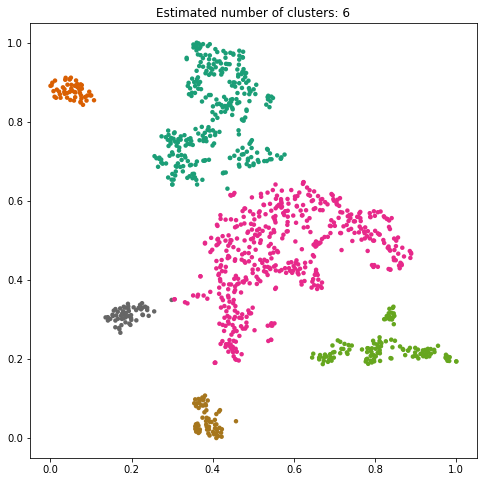

In [164]:
visual_DBSCAN(tsne_sig_cand_coord, eps=0.052, min_samples=11)

Silhouette Coefficient: 0.463


(                       cluster
 PBIOA018_A375_24H:A23        0
 REP.B021_A375_24H:E13        0
 REP.A019_A375_24H:M23        1
 PBIOA018_A375_24H:A24        0
 EMU001_SKMEL5_24H:G20        0
 ...                        ...
 MOAR019_A375_24H:K23         2
 REP.A011_A375_24H:H24        2
 MOAR003_A375_24H:C16         2
 CPC014_A375_6H:J02           5
 REP.B019_A375_24H:A07        2
 
 [1079 rows x 1 columns],
 0.4631544521150005)

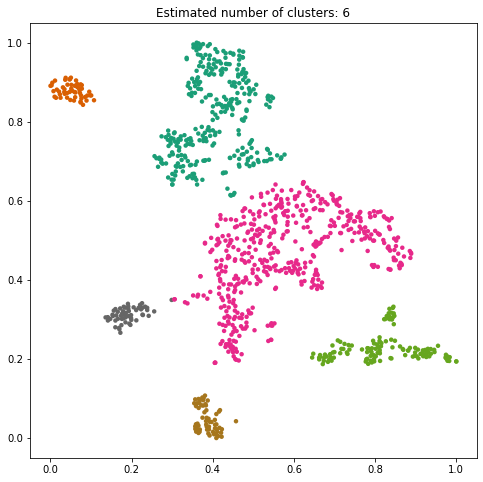

In [165]:
visual_DBSCAN(tsne_sig_cand_coord, eps=0.06, min_samples=15)

Silhouette Coefficient: 0.463


(                       cluster
 PBIOA018_A375_24H:A23        0
 REP.B021_A375_24H:E13        0
 REP.A019_A375_24H:M23        1
 PBIOA018_A375_24H:A24        0
 EMU001_SKMEL5_24H:G20        2
 ...                        ...
 MOAR019_A375_24H:K23         2
 REP.A011_A375_24H:H24        2
 MOAR003_A375_24H:C16         2
 CPC014_A375_6H:J02           5
 REP.B019_A375_24H:A07        2
 
 [1079 rows x 1 columns],
 0.46269706494835006)

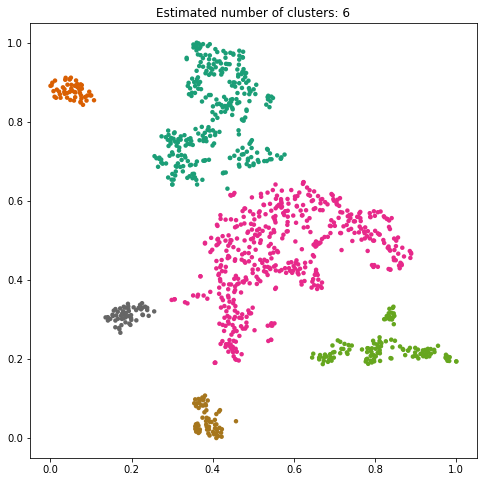

In [166]:
visual_DBSCAN(tsne_sig_cand_coord, eps=0.055, min_samples=10)

Silhouette Coefficient: 0.464


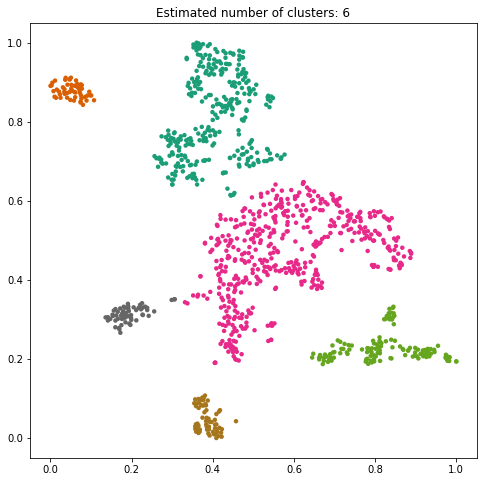

In [175]:
# final label
dbscan_sigcand = visual_DBSCAN(tsne_sig_cand_coord, eps=0.06, min_samples=18)[0]

In [178]:
tsne_sig_cand_coord['DBSCAN'] = dbscan_sigcand['cluster']

In [181]:
tsne_sig_cand_coord.to_csv(data_home + 'top_compound_cand/TSNE_sig_cand_DBSCAN.csv', sep=',')

In [190]:
cluster_color = {0: 'lightcoral', 1: 'navajowhite', 2: 'gold',
                 3: 'yellowgreen', 4: 'paleturquoise', 5: 'thistle'}

<AxesSubplot:xlabel='TSNE1', ylabel='TSNE2'>

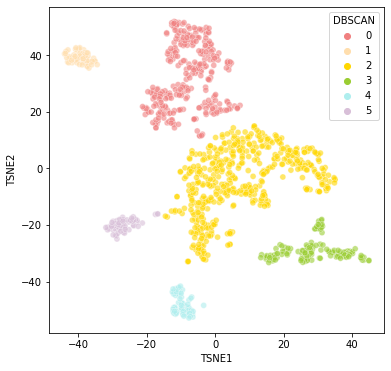

In [191]:
# color by cluster
plt.figure(figsize=(6, 6))
sns.scatterplot(x='TSNE1', y='TSNE2',
                alpha=0.6,
                hue='DBSCAN', data=tsne_sig_cand_coord, palette=cluster_color)

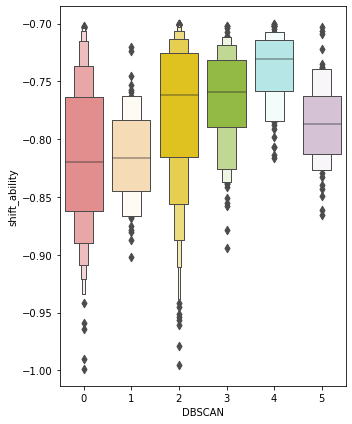

In [266]:
# shift_ability by cluster
plt.figure(figsize=(5, 6))
sns.boxenplot(x='DBSCAN', y='shift_ability', data=tsne_sig_cand_coord, palette=cluster_color)
plt.tight_layout()

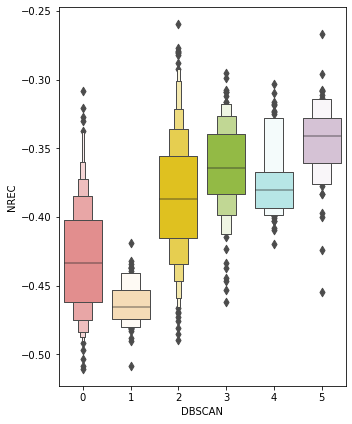

In [264]:
# NREC inhibition by cluster
plt.figure(figsize=(5, 6))
sns.boxenplot(x='DBSCAN', y='NREC', data=tsne_sig_cand_coord, palette=cluster_color)
plt.tight_layout()

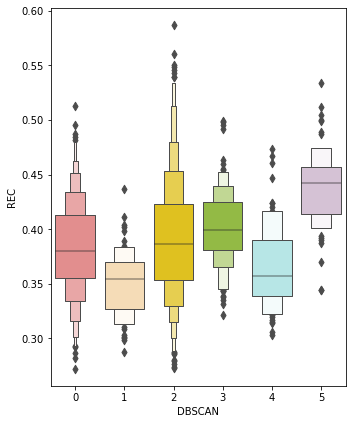

In [265]:
# REC activation by cluster
plt.figure(figsize=(5, 6))
sns.boxenplot(x='DBSCAN', y='REC', data=tsne_sig_cand_coord, palette=cluster_color)
plt.tight_layout()

In [200]:
tsne_sig_cand_coord['DBSCAN'].value_counts()

2    479
0    302
3    126
4     61
5     57
1     54
Name: DBSCAN, dtype: int64

In [196]:
# hi conf hits
pd.crosstab(tsne_sig_cand_coord['DBSCAN'], tsne_sig_cand_coord['hi-conf'])

hi-conf   No  Yes
DBSCAN           
0        224   78
1         48    6
2        415   64
3        126    0
4         25   36
5         28   29

In [199]:
# top moa in each cluster
for i in [0, 1, 2, 3, 4, 5]:
    print(i)
    tmp_sig = tsne_sig_cand_coord[tsne_sig_cand_coord['DBSCAN'] == i]
    print(tmp_sig['moa'].value_counts()[:3])

0
MEK inhibitor    92
RAF inhibitor    72
JAK inhibitor    13
Name: moa, dtype: int64
1
MEK inhibitor    34
RAF inhibitor     6
Name: moa, dtype: int64
2
Topoisomerase inhibitor               98
CDK inhibitor                         15
Ribonucleotide reductase inhibitor    13
Name: moa, dtype: int64
3
CDK inhibitor              40
Topoisomerase inhibitor    23
RNA synthesis inhibitor     6
Name: moa, dtype: int64
4
HDAC inhibitor    36
Name: moa, dtype: int64
5
HDAC inhibitor    29
Name: moa, dtype: int64


In [202]:
# top drug in each cluster
for i in [0, 1, 2, 3, 4, 5]:
    print(i)
    tmp_sig = tsne_sig_cand_coord[tsne_sig_cand_coord['DBSCAN'] == i]
    print(skcm_sig_info.loc[tmp_sig.index, 'cmap_name'].value_counts()[:5])

0
PD-0325901     35
dabrafenib     25
AZD-8330       20
selumetinib    19
trametinib     13
Name: cmap_name, dtype: int64
1
AS-703026      11
TAK-733        10
cobimetinib    10
PD-0325901      6
AZ-628          4
Name: cmap_name, dtype: int64
2
mitoxantrone    20
doxorubicin     14
amsacrine       12
pralatrexate    11
etoposide       11
Name: cmap_name, dtype: int64
3
dinaciclib      16
mitoxantrone    12
CGP-60474       10
alvocidib        7
triptolide       6
Name: cmap_name, dtype: int64
4
vorinostat       26
BRD-A19037878    25
panobinostat      7
dacinostat        2
romidepsin        1
Name: cmap_name, dtype: int64
5
BRD-A19037878    21
vorinostat       20
BRD-K68202742     2
dacinostat        1
NCH-51            1
Name: cmap_name, dtype: int64


In [295]:
# top drug in selected cluster
for i in [2, 3]:
    print(i)
    tmp_sig = tsne_sig_cand_coord[tsne_sig_cand_coord['DBSCAN'] == i]
    tmp_sig = tmp_sig[tmp_sig['moa'] == 'CDK inhibitor']
    print(skcm_sig_info.loc[tmp_sig.index, 'cmap_name'].value_counts())

2
palbociclib    8
PHA-793887     5
PHA-848125     2
Name: cmap_name, dtype: int64
3
dinaciclib    16
CGP-60474     10
alvocidib      7
BMS-387032     3
AT-7519        3
PHA-793887     1
Name: cmap_name, dtype: int64


In [223]:
# dosage vs. cluster
def cluster_dose(cmap_name, coord, sig_info):
    tmp_sig = coord[coord.index.isin(sig_info[sig_info['cmap_name'] == cmap_name].index)]
    tmp_sig['dose'] = sig_info['nearest_dose']
    tmp_sig['time'] = sig_info['pert_time']
    print(pd.crosstab(tmp_sig['DBSCAN'], tmp_sig['dose']))
    print(pd.crosstab(tmp_sig['DBSCAN'], tmp_sig['time']))
    return

In [224]:
cluster_dose(cmap_name='vorinostat',
             coord=tsne_sig_cand_coord,
             sig_info=skcm_sig_info)

dose    0.125   0.660   2.500   4.000   10.000  12.000  20.000
DBSCAN                                                        
2            1       0       0       0       1       0       0
4            0       0       1       3      20       0       2
5            0       2       2       0      15       1       0
time    6.0   24.0
DBSCAN            
2          2     0
4          0    26
5         17     3


<ipython-input-223-dd3108f8bfd9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_sig['dose'] = sig_info['nearest_dose']
<ipython-input-223-dd3108f8bfd9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_sig['time'] = sig_info['pert_time']


In [217]:
cluster_dose(cmap_name='BRD-A19037878',
             coord=tsne_sig_cand_coord,
             sig_info=skcm_sig_info)

dose    0.120   0.125   0.370   0.660   1.110   2.500   3.330   4.000   \
DBSCAN                                                                   
0            0       0       0       1       0       0       0       0   
2            0       0       0       0       0       0       0       0   
4            1       1       2       2       2       2       3       1   
5            0       2       0       2       0       2       0       0   

dose    10.000  20.000  
DBSCAN                  
0            0       0  
2            3       0  
4           10       1  
5           15       0  
time    6.0   24.0
DBSCAN            
0          0     1
2          3     0
4          0    25
5         21     0


<ipython-input-215-dd3108f8bfd9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_sig['dose'] = sig_info['nearest_dose']
<ipython-input-215-dd3108f8bfd9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_sig['time'] = sig_info['pert_time']


In [218]:
cluster_dose(cmap_name='mitoxantrone',
             coord=tsne_sig_cand_coord,
             sig_info=skcm_sig_info)

dose    0.030   0.040   0.125   0.370   0.660   1.110   2.220   2.500   \
DBSCAN                                                                   
2            1       2       4       2       4       1       1       4   
3            0       0       0       0       0       0       0       0   

dose    3.330   4.000   10.000  
DBSCAN                          
2            1       0       0  
3            1       4       7  
time    3.0   24.0
DBSCAN            
2          1    19
3          0    12


<ipython-input-215-dd3108f8bfd9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_sig['dose'] = sig_info['nearest_dose']
<ipython-input-215-dd3108f8bfd9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_sig['time'] = sig_info['pert_time']


In [225]:
cluster_dose(cmap_name='PD-0325901',
             coord=tsne_sig_cand_coord,
             sig_info=skcm_sig_info)

dose    0.010   0.030   0.040   0.080   0.120   0.125   0.250   0.370   \
DBSCAN                                                                   
0            1       1       5       1       4       1       1       3   
1            0       0       1       0       0       1       0       1   

dose    0.660   0.740   1.110   2.220   3.330   10.000  
DBSCAN                                                  
0            2       1       5       1       6       3  
1            0       0       1       0       1       1  
time    24.0
DBSCAN      
0         35
1          6


<ipython-input-223-dd3108f8bfd9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_sig['dose'] = sig_info['nearest_dose']
<ipython-input-223-dd3108f8bfd9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_sig['time'] = sig_info['pert_time']


In [227]:
immune_nes

CHANG_CORE_SERUM_RESPONSE_UP  \
PBIOA017_A375_24H:M03                                           -2.971609   
MOAR002_A375_24H:F16                                            -1.686477   
REP.A005_A375_24H:I19                                           -3.047375   
BRAF001_A375_24H:BRD-K09951645-001-02-7:2.5                     -3.215131   
REP.A021_A375_24H:C13                                           -2.893602   
...                                                                   ...   
MOAR006_A375_24H:C09                                             1.360783   
DOSVAL001_A375_24H:BRD-K81418486:10                             -2.611629   
PBIOA017_A375_24H:I13                                           -1.896223   
REP.A026_A375_24H:D14                                           -1.969440   
DOSVAL004_A375_24H:BRD-K81418486:10                             -2.765290   

                                             Module11_Prolif_score  \
PBIOA017_A375_24H:M03                                    -3.536944   
MOAR002_A375_24H:F16                                     -2.693303   
REP.A005_A375_24H:I19                                    -3.896198   
BRAF001_A375_24H:BRD-K09951645-001-02-7:2.5              -4.092546   
REP.A021_A375_24H:C13                                    -3.462131   
...                                                            ...   
MOAR006_A375_24H:C09                                     -1.712882   
DOSVAL001_A375_24H:BRD-K81418486:10                      -3.636186   
PBIOA017_A375_24H:I13                                    -3.518934   
REP.A026_A375_24H:D14                                    -1.655337   
DOSVAL004_A375_24H:BRD-K81418486:10                      -3.742439   

                                             CSR_Activated_15701700  \
PBIOA017_A375_24H:M03                                     -1.922849   
MOAR002_A375_24H:F16                                      -1.025951   
REP.A005_A375_24H:I19                                     -1.991531   
BRAF001_A375_24H:BRD-K09951645-001-02-7:2.5               -2.122341   
REP.A021_A375_24H:C13                                     -1.936984   
...                                                             ...   
MOAR006_A375_24H:C09                                      -0.898831   
DOSVAL001_A375_24H:BRD-K81418486:10                       -1.657088   
PBIOA017_A375_24H:I13                                     -1.540487   
REP.A026_A375_24H:D14                                     -1.406361   
DOSVAL004_A375_24H:BRD-K81418486:10                       -1.515383   

                                             CD8_PCA_16704732  \
PBIOA017_A375_24H:M03                               -1.382859   
MOAR002_A375_24H:F16                                 0.516035   
REP.A005_A375_24H:I19                               -0.733955   
BRAF001_A375_24H:BRD-K09951645-001-02-7:2.5          0.721505   
REP.A021_A375_24H:C13                                1.969808   
...                                                       ...   
MOAR006_A375_24H:C09                                 2.055287   
DOSVAL001_A375_24H:BRD-K81418486:10                  0.831139   
PBIOA017_A375_24H:I13                                1.244342   
REP.A026_A375_24H:D14                                0.689547   
DOSVAL004_A375_24H:BRD-K81418486:10                  0.873777   

                                             IL12_score_21050467  \
PBIOA017_A375_24H:M03                                   1.354563   
MOAR002_A375_24H:F16                                    0.611190   
REP.A005_A375_24H:I19                                   1.020707   
BRAF001_A375_24H:BRD-K09951645-001-02-7:2.5             1.251156   
REP.A021_A375_24H:C13                                   1.626301   
...                                                          ...   
MOAR006_A375_24H:C09                                    1.349031   
DOSVAL001_A375_24H:BRD-K81418486:10                     0.427937   
PBIOA017_A375_24H:I13            

In [234]:
clean_immune_nes = immune_nes.T[~immune_nes.columns.isin(['cmap_name'])].T.dropna(axis=1, how='all').fillna(0)

In [235]:
clean_immune_nes

CHANG_CORE_SERUM_RESPONSE_UP  \
PBIOA017_A375_24H:M03                                           -2.971609   
MOAR002_A375_24H:F16                                            -1.686477   
REP.A005_A375_24H:I19                                           -3.047375   
BRAF001_A375_24H:BRD-K09951645-001-02-7:2.5                     -3.215131   
REP.A021_A375_24H:C13                                           -2.893602   
...                                                                   ...   
MOAR006_A375_24H:C09                                             1.360783   
DOSVAL001_A375_24H:BRD-K81418486:10                             -2.611629   
PBIOA017_A375_24H:I13                                           -1.896223   
REP.A026_A375_24H:D14                                           -1.969440   
DOSVAL004_A375_24H:BRD-K81418486:10                             -2.765290   

                                             Module11_Prolif_score  \
PBIOA017_A375_24H:M03                                    -3.536944   
MOAR002_A375_24H:F16                                     -2.693303   
REP.A005_A375_24H:I19                                    -3.896198   
BRAF001_A375_24H:BRD-K09951645-001-02-7:2.5              -4.092546   
REP.A021_A375_24H:C13                                    -3.462131   
...                                                            ...   
MOAR006_A375_24H:C09                                     -1.712882   
DOSVAL001_A375_24H:BRD-K81418486:10                      -3.636186   
PBIOA017_A375_24H:I13                                    -3.518934   
REP.A026_A375_24H:D14                                    -1.655337   
DOSVAL004_A375_24H:BRD-K81418486:10                      -3.742439   

                                             CSR_Activated_15701700  \
PBIOA017_A375_24H:M03                                     -1.922849   
MOAR002_A375_24H:F16                                      -1.025951   
REP.A005_A375_24H:I19                                     -1.991531   
BRAF001_A375_24H:BRD-K09951645-001-02-7:2.5               -2.122341   
REP.A021_A375_24H:C13                                     -1.936984   
...                                                             ...   
MOAR006_A375_24H:C09                                      -0.898831   
DOSVAL001_A375_24H:BRD-K81418486:10                       -1.657088   
PBIOA017_A375_24H:I13                                     -1.540487   
REP.A026_A375_24H:D14                                     -1.406361   
DOSVAL004_A375_24H:BRD-K81418486:10                       -1.515383   

                                             CD8_PCA_16704732  \
PBIOA017_A375_24H:M03                               -1.382859   
MOAR002_A375_24H:F16                                 0.516035   
REP.A005_A375_24H:I19                               -0.733955   
BRAF001_A375_24H:BRD-K09951645-001-02-7:2.5          0.721505   
REP.A021_A375_24H:C13                                1.969808   
...                                                       ...   
MOAR006_A375_24H:C09                                 2.055287   
DOSVAL001_A375_24H:BRD-K81418486:10                  0.831139   
PBIOA017_A375_24H:I13                                1.244342   
REP.A026_A375_24H:D14                                0.689547   
DOSVAL004_A375_24H:BRD-K81418486:10                  0.873777   

                                             IL12_score_21050467  \
PBIOA017_A375_24H:M03                                   1.354563   
MOAR002_A375_24H:F16                                    0.611190   
REP.A005_A375_24H:I19                                   1.020707   
BRAF001_A375_24H:BRD-K09951645-001-02-7:2.5             1.251156   
REP.A021_A375_24H:C13                                   1.626301   
...                                                          ...   
MOAR006_A375_24H:C09                                    1.349031   
DOSVAL001_A375_24H:BRD-K81418486:10                     0.427937   
PBIOA017_A375_24H:I13            

In [246]:
def nes_class_cluster(cluster_info, clean_immune_nes, immuneSig_class, immune_lut):
    nes_cc_matrix = df(index=immuneSig_class['class'].unique(),  columns=cluster_info['DBSCAN'].unique())
    for c in cluster_info['DBSCAN'].unique():
        tmp_c = cluster_info[cluster_info['DBSCAN'] == c]
        tmp_c_hi = tmp_c[tmp_c['hi-conf'] == 'Yes'].index
        if len(tmp_c_hi) > 0:
            nes_sub = df(clean_immune_nes.loc[tmp_c_hi, :].mean(axis=0)).rename(columns={0: 'average_NES'})
            nes_sub['class'] = immuneSig_class['class']
            sns.boxplot(x='class', y='average_NES', data=nes_sub,
                        order=nes_sub.groupby('class').mean().sort_values(by='average_NES', ascending=False).index,
                        palette=immune_lut)
            plt.xticks(rotation=90)
            plt.axhline(y=0., ls='--', c='r')
            plt.title('Immune Response induced by cluster ' + str(c))
            plt.show()
            
            # write nes_cc_matrix
            nes_cc_matrix[c] = nes_sub.groupby('class').mean()
    return nes_cc_matrix

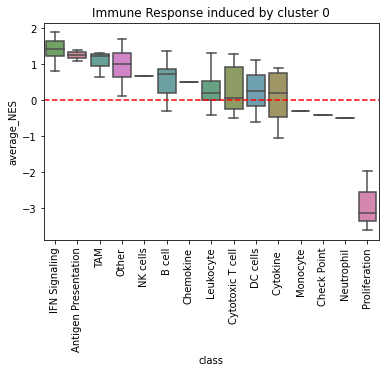

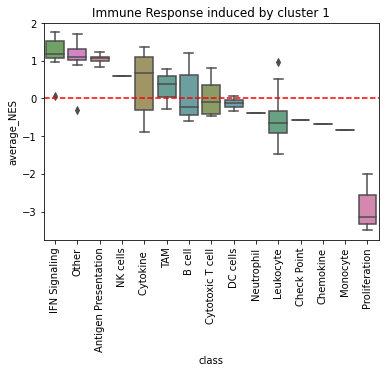

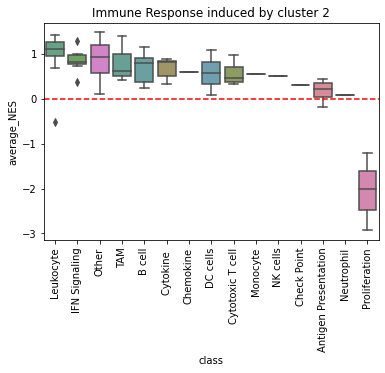

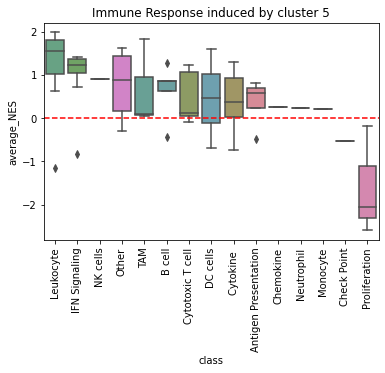

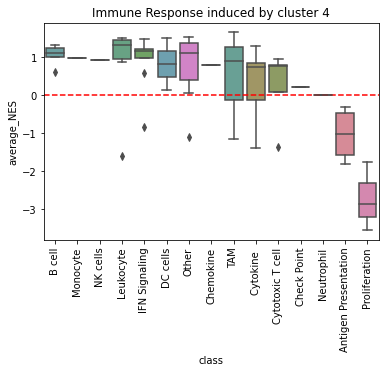

In [247]:
nes_c_matrix = nes_class_cluster(cluster_info=tsne_sig_cand_coord,
                  clean_immune_nes=clean_immune_nes,
                  immuneSig_class=immune_class,
                  immune_lut=immune_lut)

In [248]:
nes_c_matrix 

0         1         2    3         5         4
Antigen Presentation  1.257273  1.047322  0.173757  NaN  0.368014 -1.038947
Check Point          -0.397806 -0.561381  0.307283  NaN -0.520437  0.204973
Chemokine             0.514300 -0.689170  0.600456  NaN  0.267862  0.787362
Cytokine              0.093117  0.394924  0.677355  NaN  0.410211  0.295698
Cytotoxic T cell      0.308477  0.031878  0.564794  NaN  0.471903  0.241754
IFN Signaling         1.415883  1.185498  0.842371  NaN  0.966890  0.905493
Leukocyte             0.315111 -0.488662  0.925804  NaN  1.167906  0.917632
TAM                   1.065744  0.289939  0.804715  NaN  0.656121  0.463795
B cell                0.574775  0.114349  0.691226  NaN  0.636722  1.060378
DC cells              0.263671 -0.134912  0.579188  NaN  0.454418  0.820106
Neutrophil           -0.500449 -0.398166  0.080343  NaN  0.224835  0.009851
Monocyte             -0.292465 -0.834787  0.551404  NaN  0.221387  0.973363
NK cells              0.680438  0.592497  0.499495  NaN  0.896649  0.937528
Other                 0.950728  1.055398  0.839790  NaN  0.797664  0.816263
Proliferation        -2.903103 -2.878555 -2.048529  NaN -1.605454 -2.727910

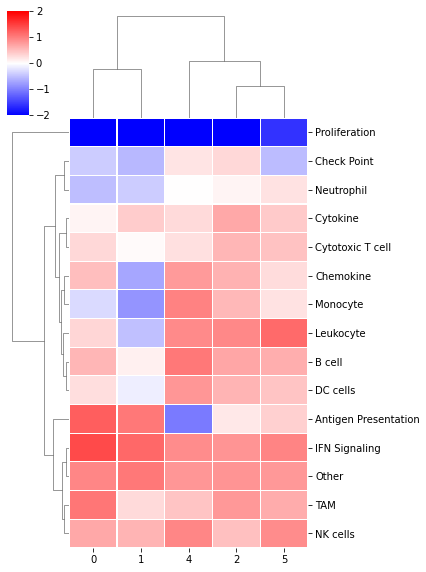

In [263]:
sns.clustermap(nes_c_matrix.fillna(0)[[0, 1, 2, 4, 5]],
               figsize=(6, 8), method='ward',
               linewidths=0.1, linecolor='white',
               cmap='bwr', vmin=-2, vmax=2)

# immune markers on TSNE plots

In [267]:
immune_tsne = tsne_sig_cand_coord.copy()

In [268]:
immune_tsne['CD8A'] = skcm_trt_cp_original.T.loc[immune_tsne.index, 'CD8A']

In [270]:
immune_tsne['CCL4'] = skcm_trt_cp_original.T.loc[immune_tsne.index, 'CCL4']

In [272]:
immune_tsne['CXCL10'] = skcm_trt_cp_original.T.loc[immune_tsne.index, 'CXCL10']

In [273]:
immune_tsne['HLA-A'] = skcm_trt_cp_original.T.loc[immune_tsne.index, 'HLA-A']

In [275]:
immune_tsne['GZMA'] = skcm_trt_cp_original.T.loc[immune_tsne.index, 'GZMA']

In [283]:
immune_tsne['TAP1'] = skcm_trt_cp_original.T.loc[immune_tsne.index, 'TAP1']

<AxesSubplot:xlabel='TSNE1', ylabel='TSNE2'>

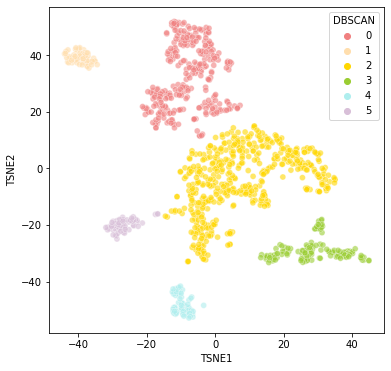

In [285]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='TSNE1', y='TSNE2',
                alpha=0.6,
                hue='DBSCAN', data=immune_tsne, palette=cluster_color)

<AxesSubplot:xlabel='TSNE1', ylabel='TSNE2'>

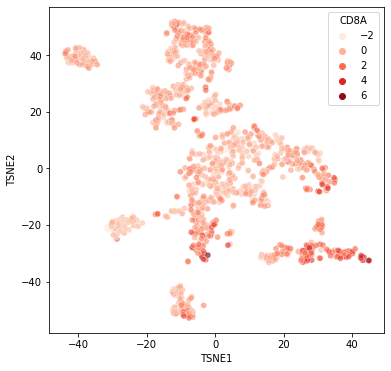

In [278]:
# color by selected gene
plt.figure(figsize=(6, 6))
sns.scatterplot(x='TSNE1', y='TSNE2',
                alpha=0.6,
                hue='CD8A', data=immune_tsne, palette='Reds')

<AxesSubplot:xlabel='TSNE1', ylabel='TSNE2'>

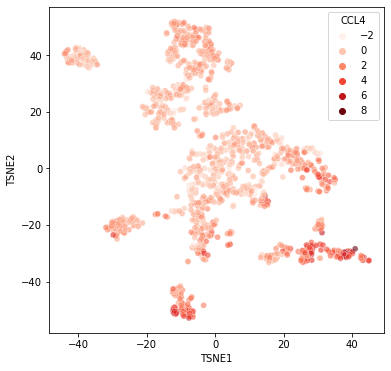

In [279]:
# color by selected gene
plt.figure(figsize=(6, 6))
sns.scatterplot(x='TSNE1', y='TSNE2',
                alpha=0.6,
                hue='CCL4', data=immune_tsne, palette='Reds')

<AxesSubplot:xlabel='TSNE1', ylabel='TSNE2'>

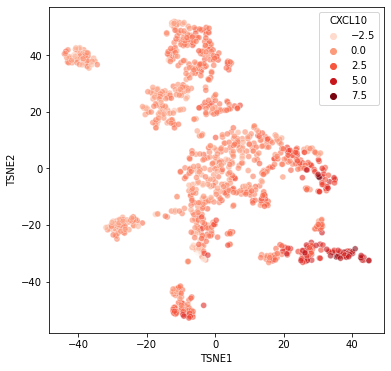

In [280]:
# color by selected gene
plt.figure(figsize=(6, 6))
sns.scatterplot(x='TSNE1', y='TSNE2',
                alpha=0.6,
                hue='CXCL10', data=immune_tsne, palette='Reds')

<AxesSubplot:xlabel='TSNE1', ylabel='TSNE2'>

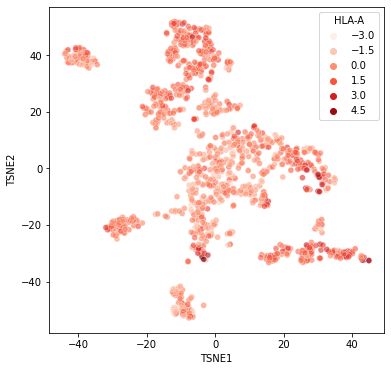

In [288]:
# color by selected gene
plt.figure(figsize=(6, 6))
sns.scatterplot(x='TSNE1', y='TSNE2',
                alpha=0.6,
                hue='HLA-A', data=immune_tsne, palette='Reds')

<AxesSubplot:xlabel='TSNE1', ylabel='TSNE2'>

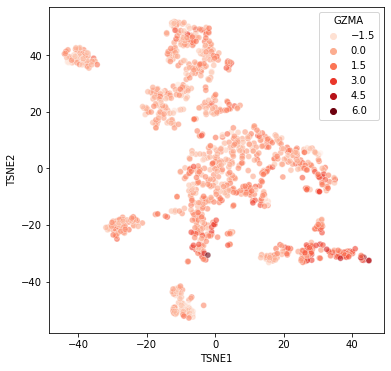

In [282]:
# color by selected gene
plt.figure(figsize=(6, 6))
sns.scatterplot(x='TSNE1', y='TSNE2',
                alpha=0.6,
                hue='GZMA', data=immune_tsne, palette='Reds')

In [1]:
# color by selected gene
plt.figure(figsize=(6, 6))
sns.scatterplot(x='TSNE1', y='TSNE2',
                alpha=0.6,
                hue='TAP1', data=immune_tsne, palette='Reds')

NameError: name 'plt' is not defined